In [1]:
import h5py
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

import pydove as dv
from statannot import add_stat_annotation
import scipy
from scipy.stats import rankdata, spearmanr

import matplotlib as mpl
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

blue = sns.color_palette("colorblind")[0]
orange = sns.color_palette("colorblind")[1]
turquoise = sns.color_palette("colorblind")[2]
bloodorange = sns.color_palette("colorblind")[3]
turquoise2 = np.array(turquoise)-0.00784313725490196

In [2]:
# Get repo directory (for data paths)
pre = "/".join(os.getcwd().split("/")[:-1])+"/"
print(pre)

/global/home/users/rkchung/personalized-expression-benchmark/


In [3]:
GEUVADIS_PATH = pre+"predictions/geuvadis.csv"
#GEUVADIS_PATH = "/clusterfs/nilah/ruchir/src/personalized_genomes/connie_data/all_geuvadis_df.csv"
ENFORMER_PREDS_PATH = pre+"predictions/enformer_sample_preds.csv"
BASENJI_PREDS_PATH = pre+"predictions/basenji2_sample_preds.csv"
XPRESSO_PREDS_PATH = pre+"predictions/xpresso_sample_preds.csv"
EXPECTO_PREDS_PATH = pre+"predictions/expecto_sample_preds.csv"
PREDIXCAN_PREDS_PATH = pre+"predictions/predixcan_197KB_sample_preds.csv"
META_PREDS_PATH = pre+"predictions/meta_sample_preds.csv"

path_mapping = {"Enformer":ENFORMER_PREDS_PATH, "Basenji2":BASENJI_PREDS_PATH, 
                "Xpresso": XPRESSO_PREDS_PATH, "ExPecto": EXPECTO_PREDS_PATH,
                "AverageModel": META_PREDS_PATH}

In [4]:
eval_genes = pd.read_csv(pre+"data/gene_list.csv", 
                         names=["gene_id", "Chr", "Position", "name", "Strand"])
eval_genes.name = eval_genes.name.fillna(eval_genes.gene_id)
eval_genes.name = eval_genes.name.apply(lambda n: n.lower() if isinstance(n, str) else n)
eval_genes

gene_id  Chr   Position             name Strand
0     ENSG00000000457    1  169863408            scyl3      -
1     ENSG00000001630    7   91772266          cyp51a1      -
2     ENSG00000002549    4   17578815             lap3      +
3     ENSG00000002745    7  120965421            wnt16      +
4     ENSG00000003056   12    9102551             m6pr      -
...               ...  ...        ...              ...    ...
3254  ENSG00000262879   17   45177689       ac005670.3      -
3255  ENSG00000262951   17   54946308  ensg00000262951      +
3256  ENSG00000262992   17   18932637  ensg00000262992      +
3257  ENSG00000263004   17   55162385       ac007114.1      -
3258  ENSG00000263280   16    2917619       ac003965.1      -

[3259 rows x 5 columns]

In [5]:
def compute_spearman_with_nans(X, Y):
    X_subset = [x for i, x in enumerate(X) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    Y_subset = [y for i, y in enumerate(Y) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    return spearmanr(X_subset, Y_subset)[0]

def compute_pearson_with_nans(X, Y):
    X_subset = [x for i, x in enumerate(X) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    Y_subset = [y for i, y in enumerate(Y) if not (np.isnan(X[i]) or np.isnan(Y[i]))]
    return scipy.stats.pearsonr(X_subset, Y_subset)

def log_transform(arr, pseudocount=1e-3):
    return np.log(arr + pseudocount)

In [6]:
def cross_individual_correlations(preds_path: str, absolute=False):
    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    preds_df = pd.read_csv(preds_path, index_col=0)
    assert geuvadis_df.index.equals(preds_df.index)
    
    unpredicted_genes = set(geuvadis_df.columns) - set(preds_df.columns)
    print(f"There are {len(unpredicted_genes)} unpredicted genes: {unpredicted_genes}")
    
    outdf = []
    for gene in preds_df.columns:
        rho, p = spearmanr(geuvadis_df[gene], preds_df[gene])
        outdf += [[gene, rho, p, preds_df[gene].max()-preds_df[gene].min()]]
    outdf = pd.DataFrame(outdf, columns=["name", "spearman", "pvalue", "predrange"])
    return outdf

def cross_gene_correlations(preds_path):
    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    preds_df = pd.read_csv(preds_path, index_col=0)
    assert geuvadis_df.index.equals(preds_df.index)
    
    unpredicted_genes = set(geuvadis_df.columns) - set(preds_df.columns)
    print(f"There are {len(unpredicted_genes)} unpredicted genes: {unpredicted_genes}")

    geuvadis_df = geuvadis_df.stack().reset_index().rename(
        {"level_0":"samples", "level_1":"gene", 0:"geuvadis"}, axis=1)
    preds_df = preds_df.stack().reset_index().rename(
        {"level_0":"samples", "level_1":"gene", 0:"pred"}, axis=1)
    
    merged = geuvadis_df.merge(preds_df, on=["gene", "samples"])

    crossgene_spearmans = merged.groupby("samples").apply(
        lambda row: compute_spearman_with_nans(list(row["geuvadis"]), list(row["pred"])))
    return crossgene_spearmans

def meta_predictions(ENFORMER_PREDS_PATH, BASENJI_PREDS_PATH, XPRESSO_PREDS_PATH, EXPECTO_PREDS_PATH):
    enformer_preds = pd.read_csv(ENFORMER_PREDS_PATH, index_col=0)
    basenji_preds = pd.read_csv(BASENJI_PREDS_PATH, index_col=0)
    xpresso_preds = pd.read_csv(XPRESSO_PREDS_PATH, index_col=0)
    expecto_preds = pd.read_csv(EXPECTO_PREDS_PATH, index_col=0)
    
    # Standardize all predictions
    enformer_preds = (enformer_preds-enformer_preds.mean())/enformer_preds.std()
    basenji_preds = (basenji_preds-basenji_preds.mean())/basenji_preds.std()
    xpresso_preds = (xpresso_preds-xpresso_preds.mean())/xpresso_preds.std() 
    expecto_preds = (expecto_preds-expecto_preds.mean())/expecto_preds.std()
    
    # Set of overlapping genes
    genes = list(set(enformer_preds.columns)\
                 .intersection(basenji_preds.columns)\
                 .intersection(xpresso_preds.columns)\
                 .intersection(expecto_preds.columns))
    
    # Initalize dataframe
    meta_preds = pd.DataFrame(list(enformer_preds.index), columns=["indiv"])
    meta_preds = meta_preds.set_index("indiv")
    print(meta_preds)
    for g in genes:
        print(g)
        meta_preds.loc[enformer_preds.index, g] = \
                        (
                            enformer_preds.loc[enformer_preds.index,g] \
                            + basenji_preds.loc[enformer_preds.index,g]\
                            + xpresso_preds.loc[enformer_preds.index,g]\
                            + expecto_preds.loc[enformer_preds.index,g]
                        )/4
    return meta_preds

def meta_predictions3(ENFORMER_PREDS_PATH, BASENJI_PREDS_PATH, EXPECTO_PREDS_PATH):
    enformer_preds = pd.read_csv(ENFORMER_PREDS_PATH, index_col=0)
    basenji_preds = pd.read_csv(BASENJI_PREDS_PATH, index_col=0)
    expecto_preds = pd.read_csv(EXPECTO_PREDS_PATH, index_col=0)
    
    # Standardize all predictions
    enformer_preds = (enformer_preds-enformer_preds.mean())/enformer_preds.std()
    basenji_preds = (basenji_preds-basenji_preds.mean())/basenji_preds.std()
    expecto_preds = (expecto_preds-expecto_preds.mean())/expecto_preds.std()
    
    # Set of overlapping genes
    genes = list(set(enformer_preds.columns)\
                 .intersection(basenji_preds.columns)\
                 .intersection(expecto_preds.columns))
    
    # Initalize dataframe
    meta_preds = pd.DataFrame(list(enformer_preds.index), columns=["indiv"])
    meta_preds = meta_preds.set_index("indiv")
    print(meta_preds)
    for g in genes:
        print(g)
        meta_preds.loc[enformer_preds.index, g] = \
                        (
                            enformer_preds.loc[enformer_preds.index,g] \
                            + basenji_preds.loc[enformer_preds.index,g]\
                            + expecto_preds.loc[enformer_preds.index,g]
                        )/3
    return meta_preds


In [7]:
enformer_corrs = cross_individual_correlations(ENFORMER_PREDS_PATH)
basenji_corrs = cross_individual_correlations(BASENJI_PREDS_PATH)
xpresso_corrs = cross_individual_correlations(XPRESSO_PREDS_PATH)
expecto_corrs = cross_individual_correlations(EXPECTO_PREDS_PATH)
meta_corrs = cross_individual_correlations(META_PREDS_PATH)
predixcan_corrs = cross_individual_correlations(PREDIXCAN_PREDS_PATH)

enformer_crossgene_corrs = cross_gene_correlations(ENFORMER_PREDS_PATH)
basenji_crossgene_corrs = cross_gene_correlations(BASENJI_PREDS_PATH)
xpresso_crossgene_corrs = cross_gene_correlations(XPRESSO_PREDS_PATH)
expecto_crossgene_corrs = cross_gene_correlations(EXPECTO_PREDS_PATH)

corr_mapping = {"Enformer":enformer_corrs, "Basenji2":basenji_corrs, 
                "Xpresso": xpresso_corrs, "ExPecto": expecto_corrs,
                "AverageModel": meta_corrs, "PrediXcan": predixcan_corrs}

crossgene_corr_mapping = {"Enformer":enformer_crossgene_corrs, "Basenji2":basenji_crossgene_corrs, 
                          "Xpresso": xpresso_crossgene_corrs, "ExPecto": expecto_crossgene_corrs}

There are 0 unpredicted genes: set()


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


There are 0 unpredicted genes: set()
There are 2 unpredicted genes: {'al035071.1', 'ensg00000205233'}
There are 0 unpredicted genes: set()
There are 2 unpredicted genes: {'al035071.1', 'ensg00000205233'}
There are 2 unpredicted genes: {'ensg00000235398', 'ensg00000231360'}
There are 0 unpredicted genes: set()
There are 0 unpredicted genes: set()
There are 2 unpredicted genes: {'al035071.1', 'ensg00000205233'}
There are 0 unpredicted genes: set()


In [8]:
def pull_ref_predictions(method_name):
    all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")

    preds_label = r"$log("+method_name+r"_{ref} + 10^{-3})$"
    preds_df = all_ref_preds[["gene", method_name]].rename({method_name: preds_label}, axis=1)

    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    geuv_label = r"$log(Median Expression + 10^{-3}))$"
    geuvadis_df = geuvadis_df.median().T.reset_index().rename(
        {"index":"gene", 0:geuv_label}, axis=1)
    geuvadis_df[geuv_label] = log_transform(geuvadis_df[geuv_label])
    if method_name == "Enformer":
        preds_df[preds_label] = log_transform(preds_df[preds_label])

    merged = geuvadis_df.merge(preds_df, on=["gene"])
    merged = merged.dropna()
    return merged

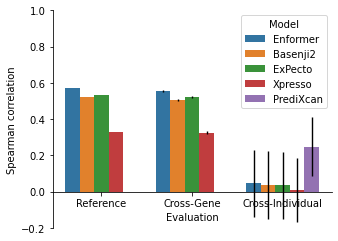

<Figure size 360x288 with 0 Axes>

In [45]:
# Figure 1b
## TODO upload figure to drive
models = ["Enformer", "Basenji2", "ExPecto", "Xpresso", "PrediXcan"]

all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")
allresults = []
for method_name in models:
    if method_name != "PrediXcan":
        merged = pull_ref_predictions(method_name)
        geuv_label, preds_label = merged.columns[-2:]
        ref_spearman = compute_spearman_with_nans(list(merged[geuv_label]), 
                                                  list(merged[preds_label]))
        allresults += [[ref_spearman, 
                        0, 
                        "Reference", 
                        method_name]]

        allresults += [[np.mean(crossgene_corr_mapping[method_name]), 
                        np.std(crossgene_corr_mapping[method_name]), 
                        "Cross-Gene", 
                        method_name]]
        
    allresults += [[np.mean(corr_mapping[method_name]["spearman"]), 
                    np.std(corr_mapping[method_name]["spearman"]), 
                    "Cross-Individual", 
                    method_name]]

allresults = pd.DataFrame(allresults, 
                          columns=["Spearman correlation", 
                                   "std", 
                                   "Evaluation",
                                   "Model"])

ax = sns.barplot(data=allresults, 
                 y="Spearman correlation", 
                 x="Evaluation", 
                 hue="Model"
                )

#allresults = allresults.sort_values(['Evaluation'])
allresults['Evaluation'] = pd.Categorical(allresults['Evaluation'], allresults['Evaluation'].unique())
allresults['Model'] = pd.Categorical(allresults['Model'], allresults['Model'].unique())
allresults = allresults.sort_values(['Evaluation'])
std = list(allresults["std"])
std.insert(4, 0)
std.insert(9, 0)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]

coords = pd.DataFrame(np.array([x_coords, y_coords]).T, columns=["x", "y"])
coords = coords.sort_values("x").fillna(0)
ax.errorbar(x=list(coords["x"]), y=list(coords["y"]), yerr=std, fmt="none", c="k", elinewidth=1.4)
plt.ylim(-0.2, 1)
ax.spines['bottom'].set_position("zero")

plt.savefig("allModelEvaluation.pdf", format="pdf")
plt.show()
plt.clf()

In [63]:
def plot_model_histogram(
    corrs,
    modelname,
    filename,
    absolute=False
):    
    fig, ax = plt.subplots(dpi=200)
    if not absolute:
        corrs = list(corrs["spearman"])
    else:
        corrs = list(corrs["spearman"].abs())

    print(len(corrs))
    sns.histplot(corrs, color="green", ax=ax)
    xlabel = "|Spearman R|" if absolute else "Spearman R"
    ax.set(
        xlabel=xlabel, 
        title=f"{modelname} vs Geuvadis {xlabel} across individuals\n mean={np.nanmean(corrs):.4f} std={np.nanstd(corrs):.4f}"
    )
    plt.savefig(f"{filename}", format="pdf", bbox_inches="tight")
    plt.show()

In [64]:
print(corr_mapping["Basenji2"])

         name  spearman    pvalue  predrange
0        a1bg  0.084977  0.081586   0.166764
1      a4galt  0.178121  0.000239   0.832578
2       aanat  0.009892  0.839623   0.063662
3       aasdh  0.081202  0.096127   0.076171
4       abcb6  0.018303  0.708058   0.151180
...       ...       ...       ...        ...
3254  zscan21 -0.230899  0.000002   0.106587
3255  zscan23 -0.103255  0.034176   0.301554
3256   zswim4  0.137161  0.004813   0.057910
3257     zxdc  0.073765  0.130763   0.039826
3258   zyg11a  0.020904  0.668876   0.165260

[3259 rows x 4 columns]


3259


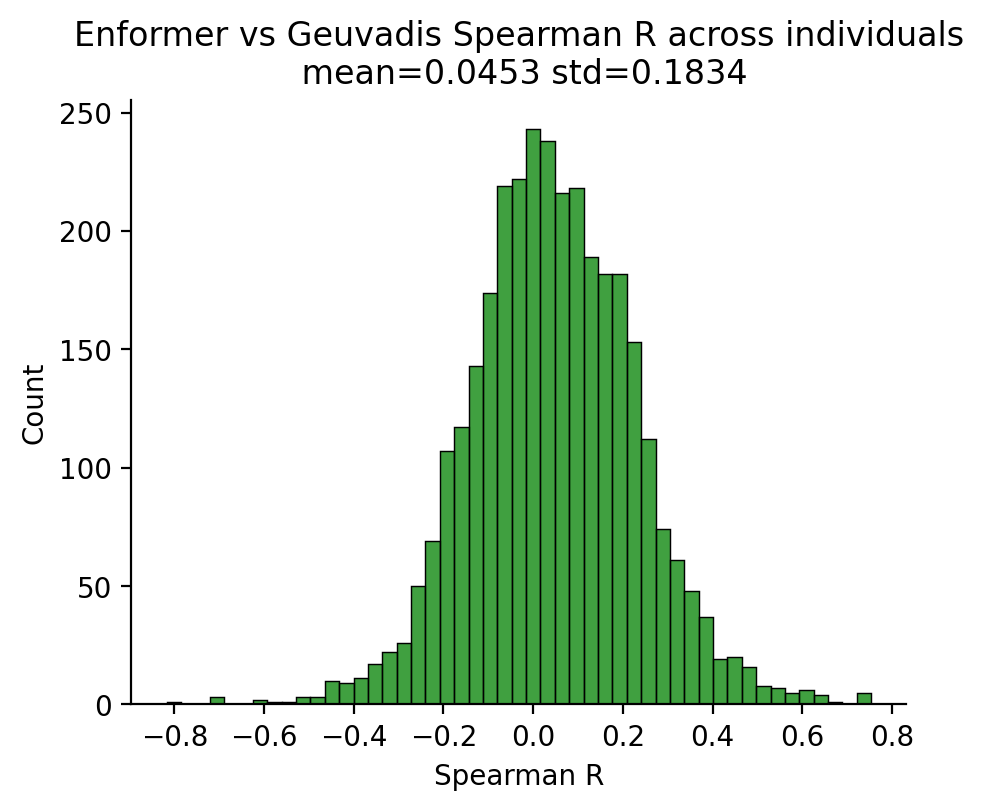

3259


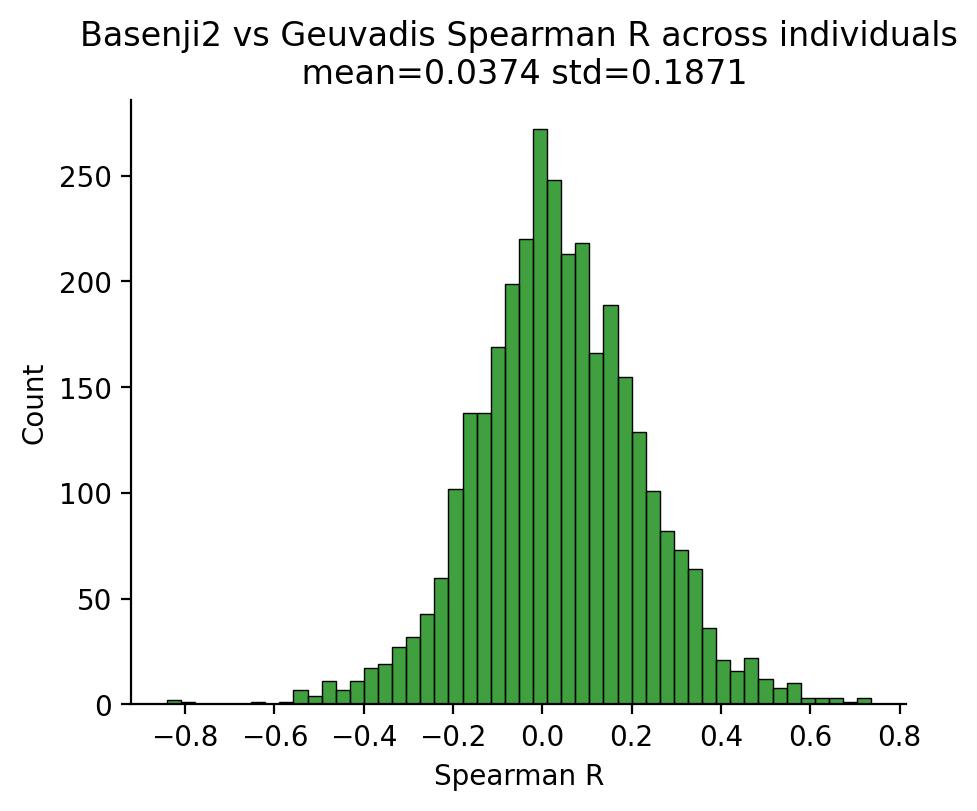

3257


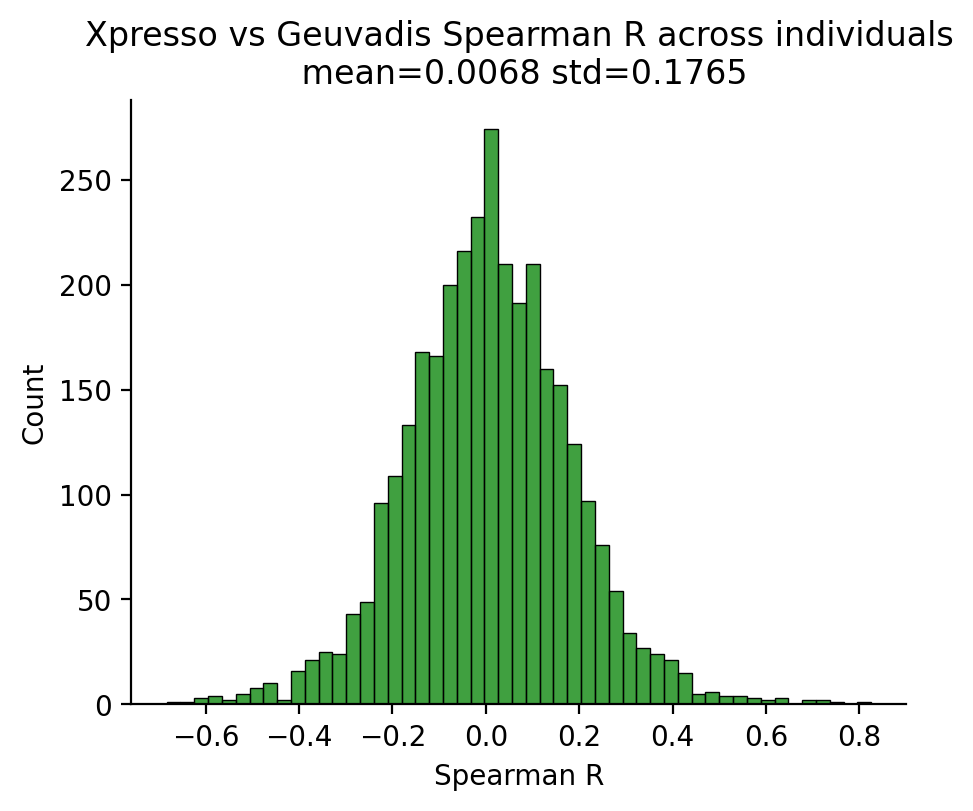

3259


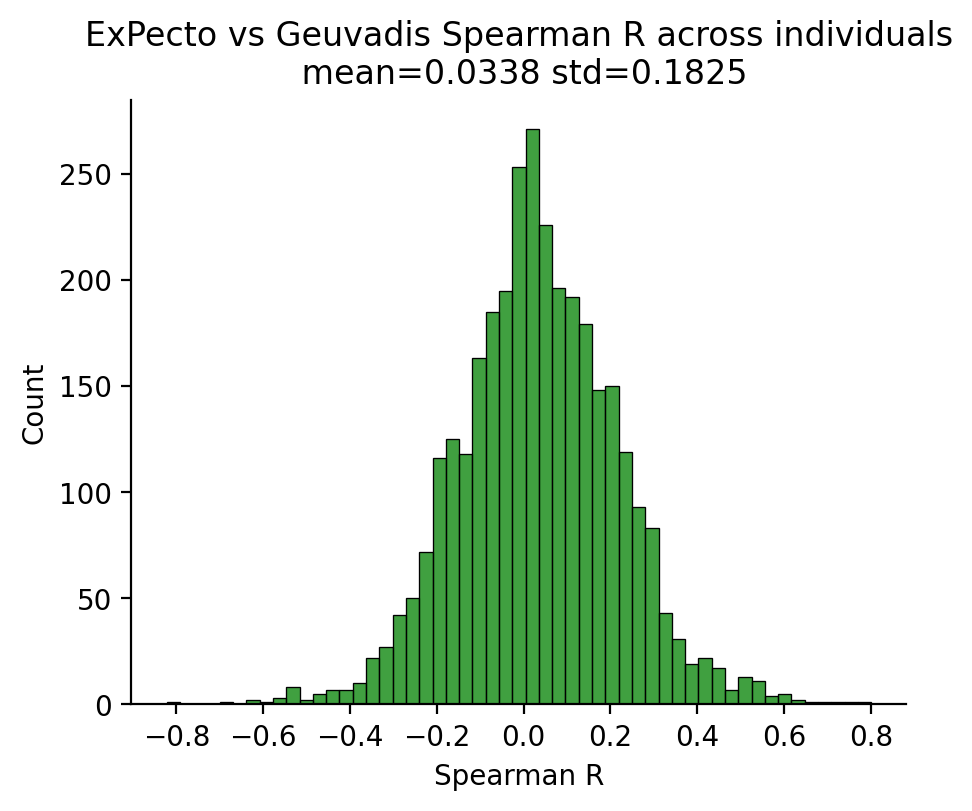

3257


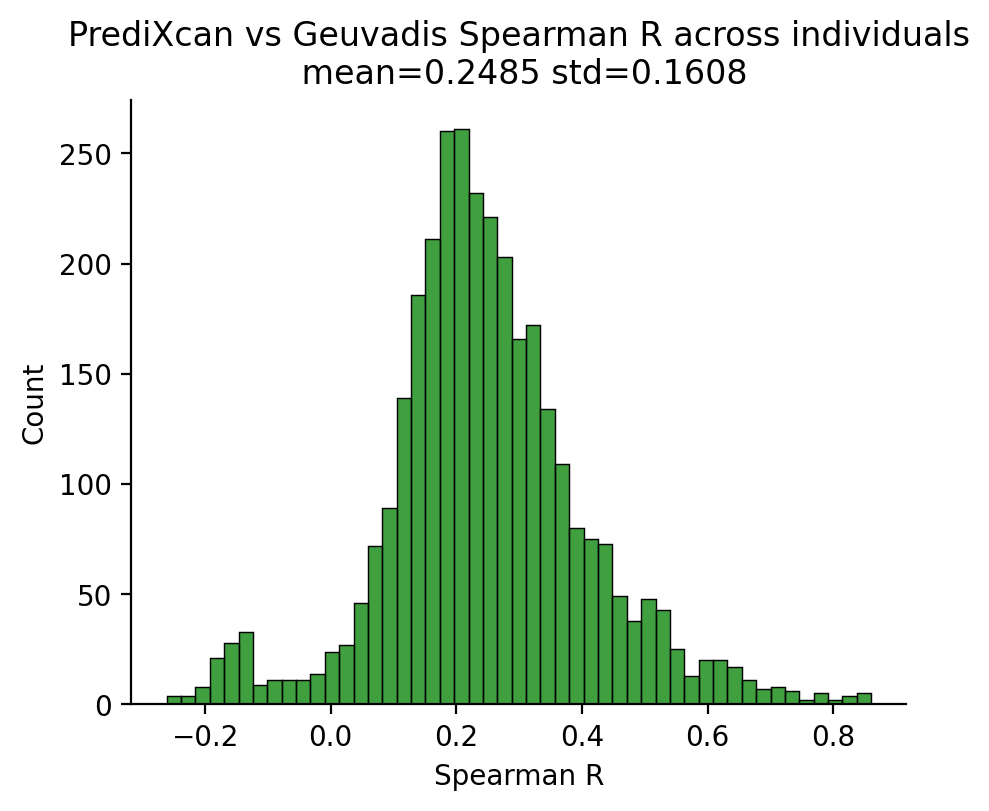

In [71]:
#  Extended Data Fig 3
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto", "PrediXcan"]

for method_name in models:
    plot_model_histogram(corr_mapping[method_name], 
                         method_name,
                         method_name.lower()+"spearman.pdf")

3259


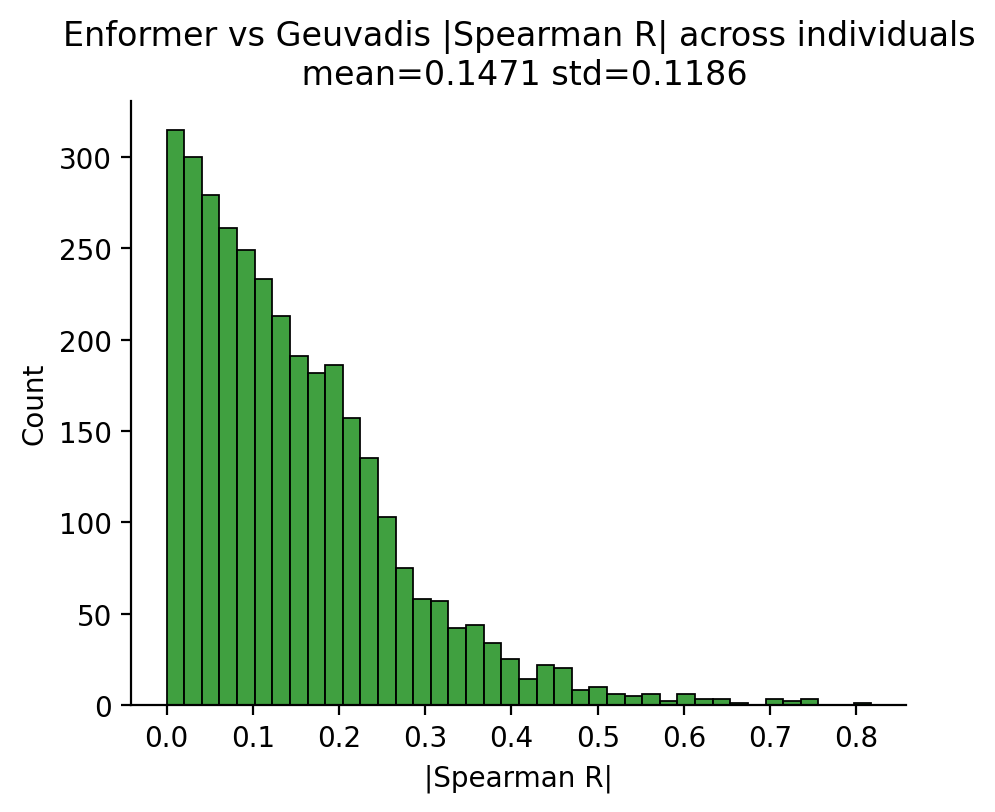

3259


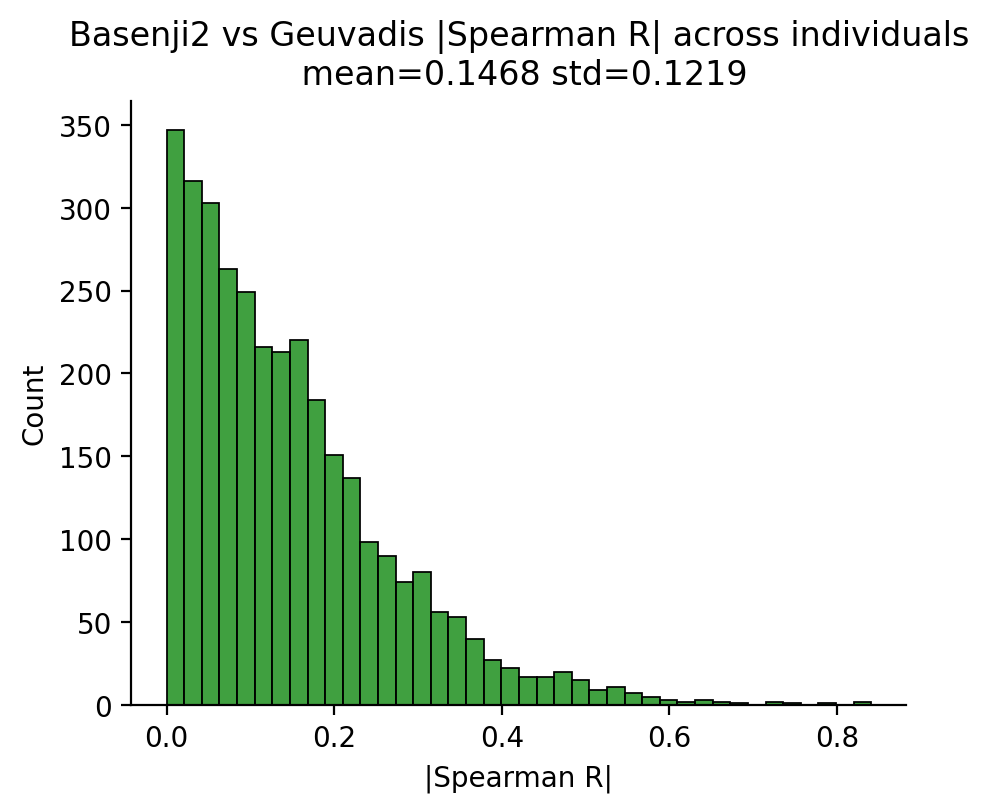

3257


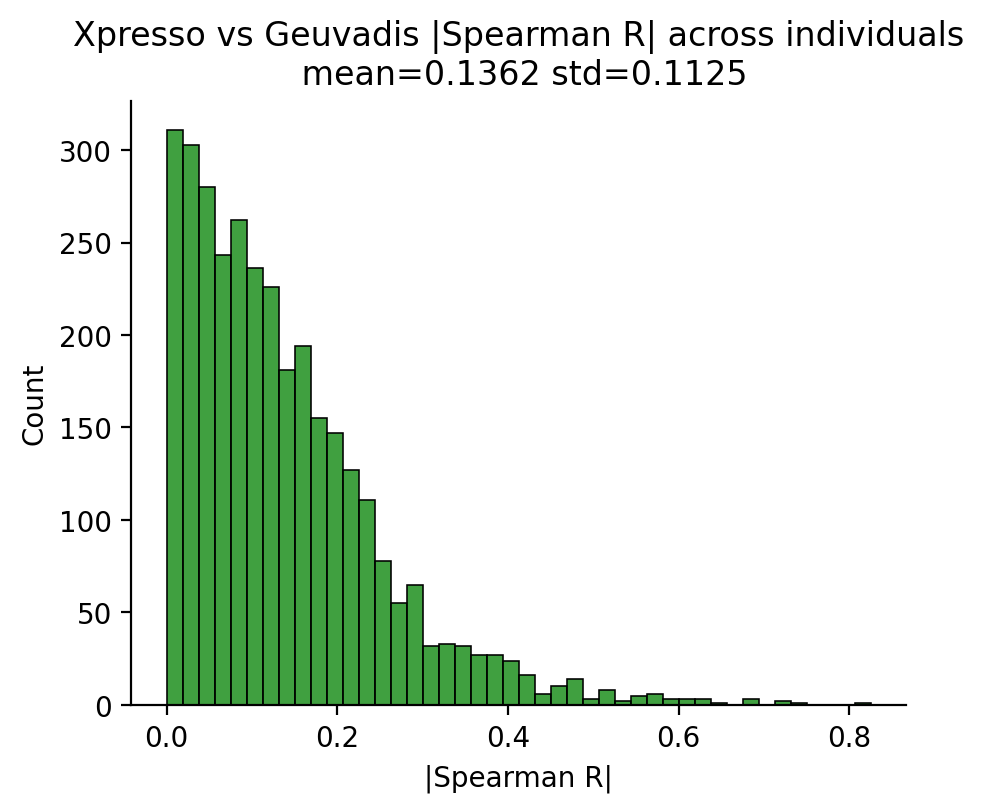

3259


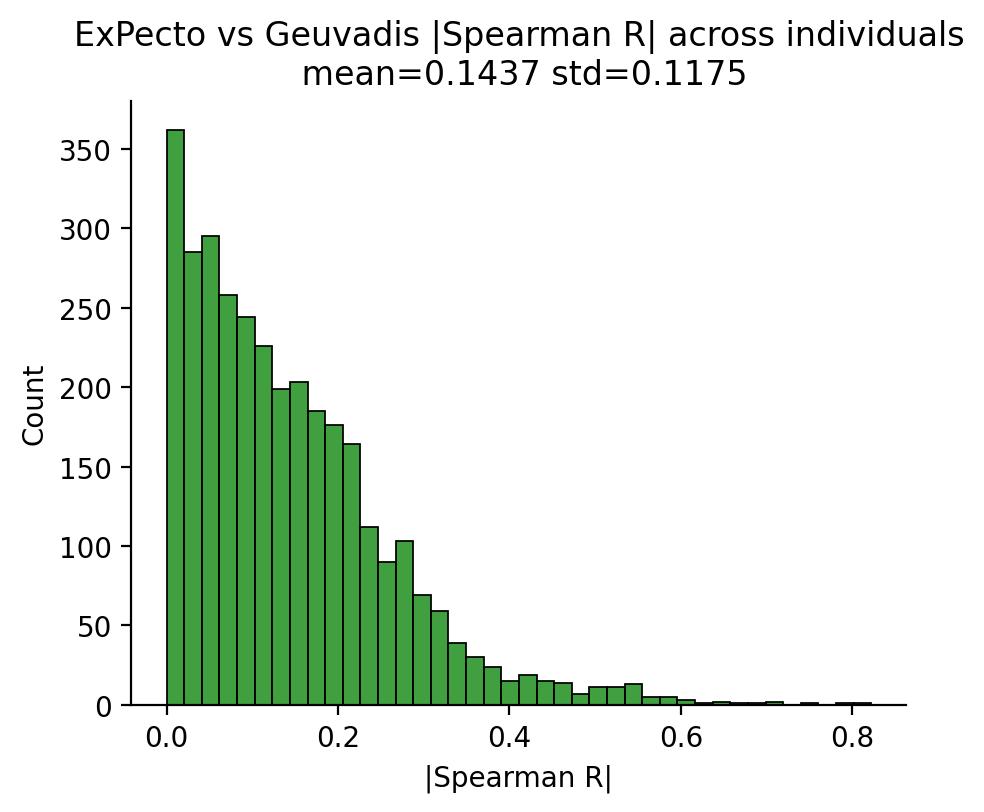

3257


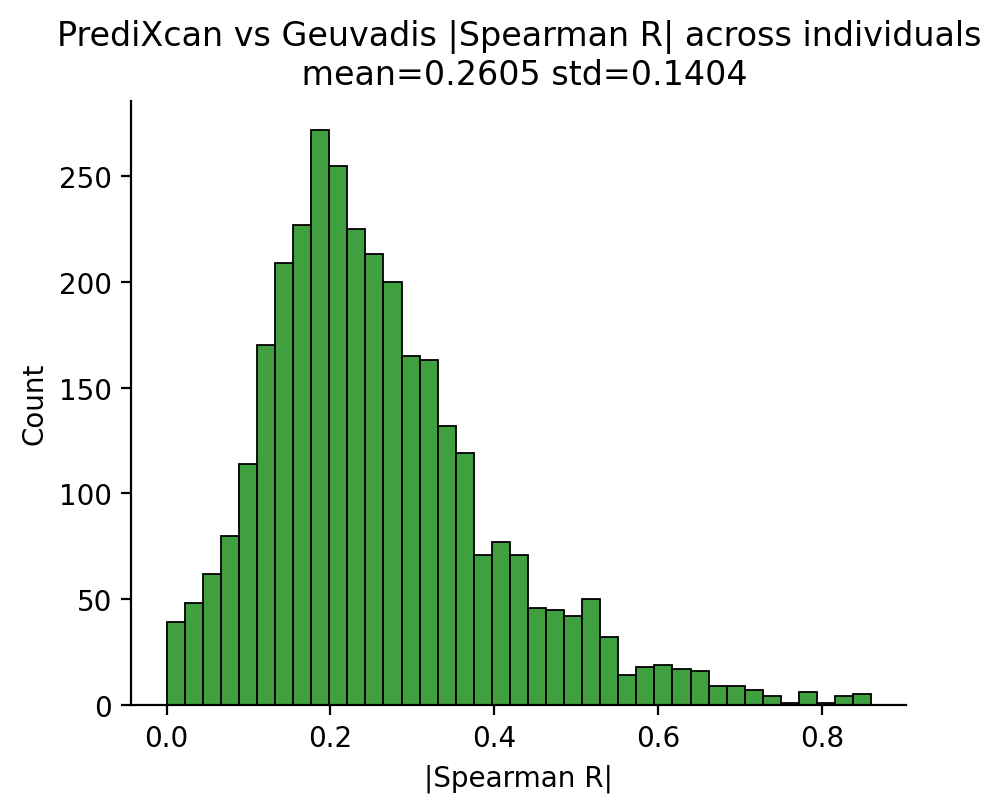

In [73]:
#  Supplementary Fig 1
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto", "PrediXcan"]

for method_name in models:
    m = models[i]
    plot_model_histogram(corr_mapping[method_name], 
                         method_name, 
                         method_name.lower()+"absspearman.pdf", 
                         absolute=True)

# Ensemble models (Supplementary Figure 2)

In [74]:
def get_rank_dict(df_path: str): #-> dict[str, dict[str, float]]:
    """
    Returns a dictionary mapping a gene to a dictionary mapping a sample name to a rank.
    Smaller ranks indicate lower expression
    """
    ranks_by_gene = {}
    df = pd.read_csv(df_path, index_col=0)
    samples = df.index
    for gene in df.columns:
        values = np.asarray(df[gene])
        if np.all(values == values[0]):
            # If all values are the same, then we can't compute a rank per sample so skip.
            continue
        assert not np.any(np.isnan(values))
        ranks = rankdata(values, method='average')
        ranks_by_gene[gene] = {s: r for s, r in zip(samples, ranks)}
    return ranks_by_gene

In [140]:
## Average prediction rank across all models
geuvadis_ranks = get_rank_dict(GEUVADIS_PATH)
enformer_ranks = get_rank_dict(ENFORMER_PREDS_PATH)
basenji_ranks = get_rank_dict(BASENJI_PREDS_PATH)
xpresso_ranks = get_rank_dict(XPRESSO_PREDS_PATH)
expecto_ranks = get_rank_dict(EXPECTO_PREDS_PATH)

plt.rcParams['figure.figsize'] = [6.4, 4.8]


In [141]:
def plot_ensemble_model_histogram(
    geuvadis_ranks,
    enformer_ranks,
    basenji_ranks,
    xpresso_ranks,
    expecto_ranks
):
    method_ranks_l = [enformer_ranks, basenji_ranks, xpresso_ranks, expecto_ranks]
    
    # First, we need to compute correlations between the ranks averaged over all methods and the Geuvaids ranks
    corrs_by_gene = {}
    shared_genes = set(geuvadis_ranks.keys()) & set.union(*[set(m.keys()) for m in method_ranks_l])
    
    for gene in shared_genes:
        samples = geuvadis_ranks[gene].keys()
        obs_ranks = np.asarray([geuvadis_ranks[gene][s] for s in samples])
            
        pred_ranks_per_method = []
        for method_ranks in method_ranks_l:
            if gene not in method_ranks:
                continue
            pred_ranks = [method_ranks[gene][s] for s in samples]
            pred_ranks_per_method.append(pred_ranks)
            
        average_pred_ranks = np.mean(pred_ranks_per_method, axis=0)
        assert average_pred_ranks.shape == obs_ranks.shape
        
        corrs_by_gene[gene] = spearmanr(obs_ranks, average_pred_ranks)[0]
    
    corrs_l = list(corrs_by_gene.values())
    
    fig, ax = plt.subplots(dpi=100)
    sns.histplot(corrs_l, ax=ax, color="green")
    ax.set(
        xlabel="Cross-individual correlation of rank averaged ensemble model", 
        title=f"mean={np.mean(corrs_l):.3}"
    )
    plt.savefig("rankaveragedmodelcorrelation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

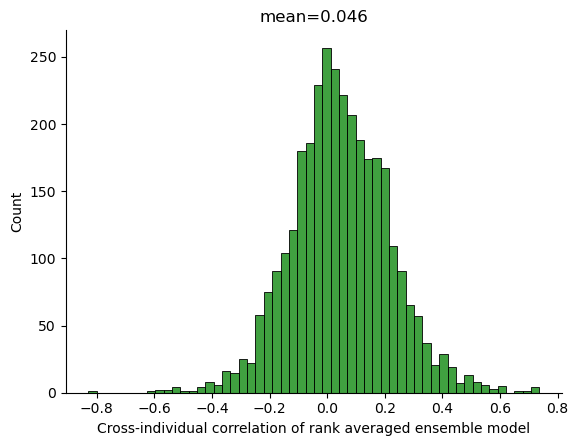

In [142]:
plot_ensemble_model_histogram(
    geuvadis_ranks,
    enformer_ranks,
    basenji_ranks,
    xpresso_ranks,
    expecto_ranks
)

In [157]:
def plot_max_model_histogram(
    enformer_corrs,
    basenji_corrs,
    xpresso_corrs,
    expecto_corrs
):
    method_corrs_l = [enformer_corrs, basenji_corrs, xpresso_corrs, expecto_corrs]
    allcorrs = pd.concat(method_corrs_l)
    max_corrs = allcorrs.groupby("name")["spearman"].apply(lambda row: np.nanmax(row))
        
    fig, ax = plt.subplots(dpi=100)
    sns.histplot(data=max_corrs, ax=ax, color="green")
    ax.set(
        xlabel="Maximum cross-individual correlation across all 4 models", 
        title=f"Mean={np.mean(max_corrs):.3f}"
    )
    plt.savefig("maxmodelcorrelation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

         name  spearman        pvalue  predrange
0        a1bg  0.060370  2.164088e-01   0.031624
1      a4galt  0.035531  4.671720e-01   1.229835
2       aanat -0.161949  8.527388e-04   0.179517
3       aasdh -0.057020  2.430405e-01   1.314168
4       abcb6 -0.001865  9.695616e-01   3.846416
...       ...       ...           ...        ...
3254  zscan21  0.193247  6.580057e-05   0.886979
3255  zscan23  0.353509  7.747243e-14   1.885491
3256   zswim4  0.356063  4.983407e-14   2.714708
3257     zxdc  0.019515  6.897041e-01   2.573414
3258   zyg11a -0.037700  4.404083e-01   1.723560

[3259 rows x 4 columns]


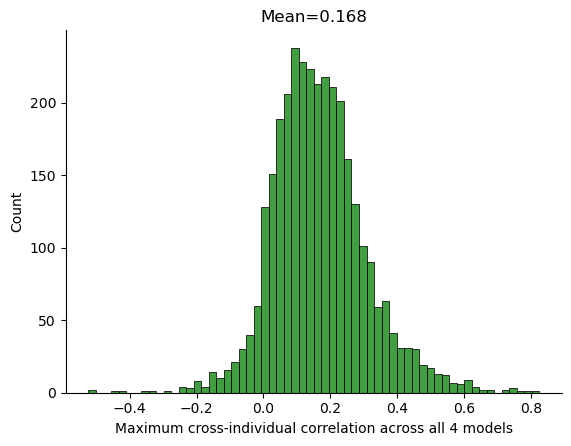

In [158]:
# Ex
print(enformer_corrs)
plot_max_model_histogram(
    enformer_corrs,
    basenji_corrs,
    xpresso_corrs,
    expecto_corrs
)

In [221]:
def get_zscores(df_path: str): #-> dataframe
    """
    Returns a dataframe of normalized expression/predictions
    """
    zscores_by_gene = {}
    df = pd.read_csv(df_path, index_col=0)
    df = df.apply(lambda row: (row-np.mean(row))/np.std(row) if not np.all(np.array(row)==row[-1]) else np.nan)
    return df

In [222]:
geuvadis_zscore = get_zscores(GEUVADIS_PATH)
enformer_zscore = get_zscores(ENFORMER_PREDS_PATH)
basenji_zscore = get_zscores(BASENJI_PREDS_PATH)
xpresso_zscore = get_zscores(XPRESSO_PREDS_PATH)
expecto_zscore = get_zscores(EXPECTO_PREDS_PATH)

In [223]:
geuvadis_zscore

a1bg    a4galt     aanat     aasdh     abcb6     abcd2    abhd10  \
HG00096  0.321882 -0.754473 -0.589254 -1.283972 -0.928701 -0.274532 -0.303763   
HG00097 -0.251180 -0.714295 -0.540667 -0.566219  0.093762  0.141634 -0.521939   
HG00099 -0.840047 -1.381281 -0.780370 -1.671752 -1.120858 -1.315170 -1.802393   
HG00100 -0.140660 -0.214292  1.169217 -0.742742 -0.621850 -0.261452  0.248347   
HG00101  0.493373 -1.297906  1.825916 -0.259707 -0.600258  0.406457  0.289241   
...           ...       ...       ...       ...       ...       ...       ...   
NA20815  1.212424 -0.162583 -0.652477 -0.575862 -0.403732 -1.036383  0.376400   
NA20816  0.182861 -0.650996  0.047304  1.890575  0.011989 -0.592603 -0.367073   
NA20819 -0.710684  0.100835  1.561237 -0.408449 -0.016839  0.541346  0.297445   
NA20826 -1.052552  0.210831 -0.477168 -0.329210 -1.043537 -0.290230 -0.535144   
NA20828 -1.337343 -0.375332  0.175883  0.247498  1.655333 -0.697427 -0.374163   

           abhd12    abhd15   abhd16b  ...    znf879    znf880    znhit6  \
HG00096  0.088613 -0.790854  0.212855  ...  0.873817  1.327040 -0.272497   
HG00097 -0.546156 -1.645565  0.347996  ... -0.493523  0.670914  0.028396   
HG00099 -3.495460 -1.997164 -2.218479  ...  5.551964 -1.286329 -1.934552   
HG00100 -0.121708 -0.572463  0.028848  ... -0.602660 -0.346081  0.047155   
HG00101  0.033789 -0.721086  1.196655  ... -0.501189 -1.062398 -0.412530   
...           ...       ...       ...  ...       ...       ...       ...   
NA20815  0.910229 -0.194368 -0.137815  ...  0.217168  0.525294  2.471094   
NA20816 -0.035327  0.949656  0.861409  ... -0.527976  0.081421 -0.569036   
NA20819 -1.124106  0.080807 -1.833279  ... -0.279303  2.603512 -0.993618   
NA20826 -0.151986  0.163180  0.643682  ...  0.156041  2.081076 -0.436272   
NA20828 -0.342982  0.583103  0.807374  ... -0.483151 -0.608205 -0.030751   

              zp3     zpbp2   zscan21   zscan23    zswim4      zxdc    zyg11a  
HG00096 -0.911125 -0.441206 -1.389426  2.244290  0.388940  0.784330 -0.380131  
HG00097 -0.397045 -0.267313 -0.967299  1.734049 -0.316452 -0.348603 -0.346737  
HG00099 -0.107105 -0.780208 -2.657719 -0.438812 -1.790292 -2.138181 -1.018004  
HG00100  0.308241 -0.475665  0.431611  1.997618 -0.552368  0.660142 -0.568906  
HG00101 -0.250062 -1.048250  0.631502 -1.029677 -0.784803 -1.065653 -1.083618  
...           ...       ...       ...       ...       ...       ...       ...  
NA20815  0.873514 -0.834018  0.541591 -0.921919  0.936308  0.886154 -0.137671  
NA20816 -0.454215  0.524125  0.028124 -1.842442 -0.691487  0.784227 -0.301963  
NA20819 -0.778945 -0.468059 -0.464671 -1.225033  0.336523 -0.657063 -0.181170  
NA20826 -0.742870 -0.247420 -0.181755  0.391967 -2.085337  0.176655  0.035425  
NA20828  0.987674  0.808881  1.815795 -0.831673  1.681560  2.406050  0.190808  

[421 rows x 3259 columns]

In [226]:
def plot_zscore_ensemble_model_histogram(
    geuvadis_zscore,
    enformer_zscore,
    basenji_zscore,
    xpresso_zscore,
    expecto_zscore
):
    method_zscores_l = [enformer_zscore, basenji_zscore, xpresso_zscore, expecto_zscore]
    
    # First, we need to compute correlations between the zscores averaged over all methods and the Geuvaids ranks
    allzscores = pd.concat(method_zscores_l)
    allzscores = allzscores.reset_index().groupby(["index"]).agg(np.nanmean)

    geuvadis_zscore = geuvadis_zscore.stack().reset_index().rename(
        {"level_0":"samples", "level_1":"gene", 0:"geuvadis"}, axis=1)
    allzscores = allzscores.stack().reset_index().rename(
        {"index":"samples", "level_1":"gene", 0:"pred"}, axis=1)

    merged = geuvadis_zscore.merge(allzscores, on=["gene", "samples"])
    spearmans = merged.groupby("gene").apply(
        lambda row: compute_spearman_with_nans(list(row["geuvadis"]), list(row["pred"])))    
    
    fig, ax = plt.subplots(dpi=100)
    sns.histplot(spearmans, ax=ax, color="green")
    ax.set(
        xlabel="Cross-individual correlation of expression averaged ensemble model", 
        title=f"mean={np.mean(spearmans):.3}"
    )
    plt.savefig("expressionaveragedmodelcorrelation.pdf", format="pdf", bbox_inches="tight")

    plt.show()

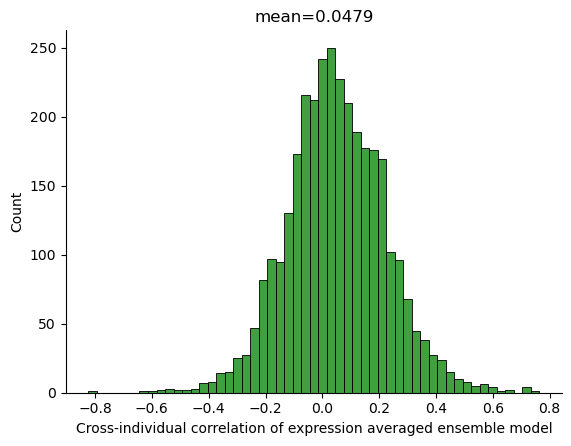

In [227]:
plot_zscore_ensemble_model_histogram(
    geuvadis_zscore,
    enformer_zscore,
    basenji_zscore,
    xpresso_zscore,
    expecto_zscore
)

In [212]:
# Plot all gene, all individual prediction comparision
def plot_ref_predictions_vs_geuvadis(method_name, label="", pdf=""):
    merged = pull_ref_predictions(method_name)
    geuv_label, preds_label = merged.columns[-2:]

    ax = plt.subplot(111)
    sns.scatterplot(data=merged, x=geuv_label, y=preds_label, s=10, color="black", ax=ax)
    spearman = compute_spearman_with_nans(list(merged[geuv_label]), list(merged[preds_label]))
    text_top = 0.02*(np.max(merged[preds_label])-np.min(merged[preds_label]))+np.max(merged[preds_label])
    text_middle = 0.5*(np.max(merged[geuv_label])-np.min(merged[geuv_label]))+np.min(merged[geuv_label])

    plt.text(text_middle, text_top, f"Spearman correlation {spearman:.4f}", ha="center", fontsize=12)
    plt.yticks(fontsize=9)
    plt.xticks(fontsize=9)
    
    if pdf != "":
        plt.savefig(pdf, format="pdf")
        
    plt.show()
    plt.clf()


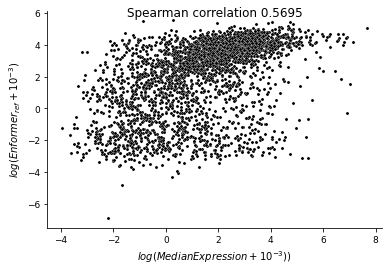

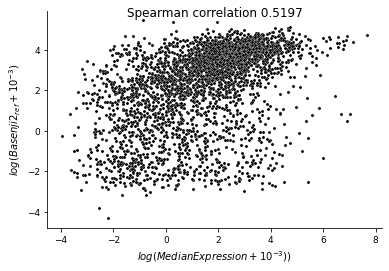

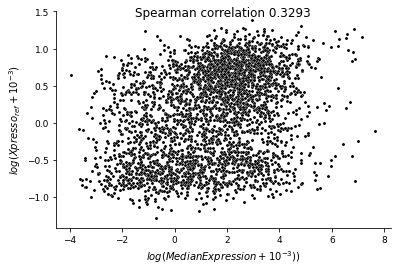

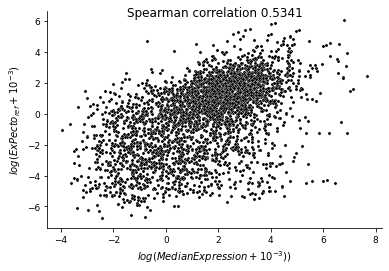

<Figure size 432x288 with 0 Axes>

In [22]:
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")
for method_name in models:
    plot_ref_predictions_vs_geuvadis(method_name, 
                                     pdf=method_name.lower()+"GeuvadisMedianExpression.pdf")

Enformer


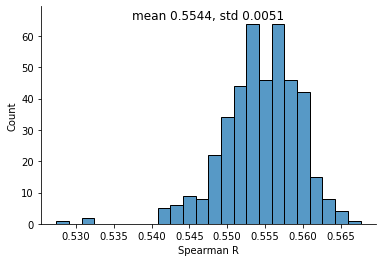

Basenji2


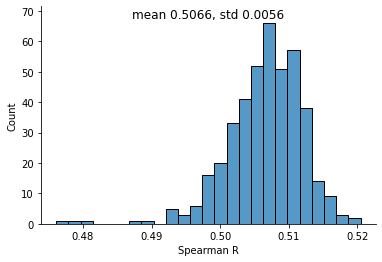

Xpresso


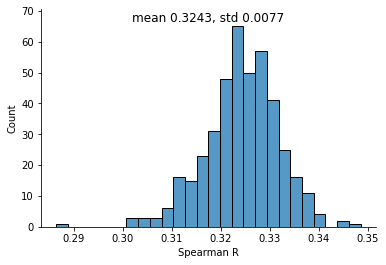

ExPecto


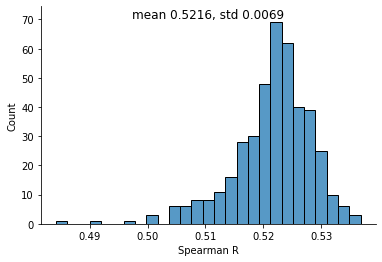

<Figure size 432x288 with 0 Axes>

In [23]:
# Plot all gene, all individual prediction comparision
def plot_cross_gene_correlations(corrs, pdf=""):
    ax = plt.subplot(111)
    sns.histplot(data=corrs, ax=ax)
    plt.xlabel("Spearman R")
    
    text_top = np.max([p.get_height() for p in ax.patches])+1.5
    text_middle = 0.5*(np.max(corrs)-np.min(corrs))+np.min(corrs)
    plt.text(text_middle, text_top, 
             f"mean {np.mean(list(corrs)):.4f}, std {np.std(list(corrs)):.4f}", 
             ha="center", fontsize=12)

    plt.ylim(0,text_top+4)

    
    if pdf != "":
        plt.savefig(pdf, format="pdf")
        
    plt.show()
    plt.clf()

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]
for method_name in models:
    print(method_name)
    plot_cross_gene_correlations(crossgene_corr_mapping[method_name], 
                                 pdf=method_name.lower()+"CrossGeneSpearman.pdf")

In [114]:
# Plots model predictions vs expression data for given gene
def plot_preds_vs_geuvadis_gene(preds_path, gene, label="", pdf="", break_axis=False, 
                                ref_pred=None, alt_pred=None, dosage_df=None):
    print(pdf)
    geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
    preds_df = pd.read_csv(preds_path, index_col=0)
    assert geuvadis_df.index.equals(preds_df.index)
    
    geuv_label = "Observed expression"
    geuvadis_column = geuvadis_df[gene].to_frame().rename({gene:geuv_label}, axis=1)
    preds_column = preds_df[gene].to_frame().rename({gene:label}, axis=1)
    
    if "Enformer" not in label:
        preds_column = np.exp(preds_column)-0.001
    merged = geuvadis_column.join(preds_column)
    if dosage_df is not None:
        merged = merged.join(dosage_df.T.rename({0:"dosage"}, axis=1))
        dosages = ["Dosage: 0", "Dosage: 1", "Dosage: 2"]
        merged["dosage"] = merged["dosage"].apply(lambda d: dosages[d])
    
    if not break_axis:
        fig, ax = plt.subplots(1,1, figsize=(5.5,4))
        sns.scatterplot(data=merged, x=geuv_label, y=label, 
                        s=14, color="black", ax=ax, 
                        hue="dosage" if dosage_df is not None else None,
                        hue_order=["Dosage: 0", "Dosage: 1", "Dosage: 2"], 
                        alpha=0.8, palette="tab10")
        plt.title(gene.upper())
        if ref_pred is not None:
            ax.get_legend().remove()
            plt.plot((np.min(merged[geuv_label]), np.max(merged[geuv_label])), 
                     ((ref_pred, ref_pred)),
                     linestyle="--"
                    )
        if alt_pred is not None:
            plt.plot((np.min(merged[geuv_label]), np.max(merged[geuv_label])),
                     ((alt_pred, alt_pred)),
                     linestyle="--",
                     color="green"
                    )

    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,
                                      gridspec_kw={
                                           'width_ratios': [4.57, 1]})
        fig.subplots_adjust(wspace=0.05)  # adjust space between axes

        # plot the same data on both axes
        sns.scatterplot(data=merged, x=geuv_label, y=label, s=12, color="black", ax=ax1)
        sns.scatterplot(data=merged, x=geuv_label, y=label, s=12, color="black", ax=ax2)
        #ax1.plot(merged[geuv_label], merged[label])
        #ax2.plot(merged[geuv_label], merged[label])
        # zoom-in / limit the view to different portions of the data
        ax1.set_xlim(-6, 26)  # most of the data
        ax2.set_xlim(33, 40)  # outliers only

        # hide the spines between ax and ax2
        ax1.spines["right"].set_visible(False)
        ax2.spines["left"].set_visible(False)
        #ax1.xaxis.tick_top()
        ax2.tick_params(labeltop=False)  # don't put tick labels at the top
        ax2.tick_params(left = False) 
        
        # Now, let's turn towards the cut-out slanted lines.
        # We create line objects in axes coordinates, in which (0,0), (0,1),
        # (1,0), and (1,1) are the four corners of the axes.
        # The slanted lines themselves are markers at those locations, such that the
        # lines keep their angle and position, independent of the axes size or scale
        # Finally, we need to disable clipping.

        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=12,
                      linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax1.plot([1], [0], transform=ax1.transAxes, **kwargs)
        ax2.plot([0], [0], transform=ax2.transAxes, **kwargs)

        ax1.set_title(gene.upper())
        ax2.set_xlabel("")
        ax1.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

    if pdf != "":
        plt.savefig(pdf, format="pdf")
        
    plt.show()
    plt.clf()

enformerGeuvadisScatterSLFN5.pdf


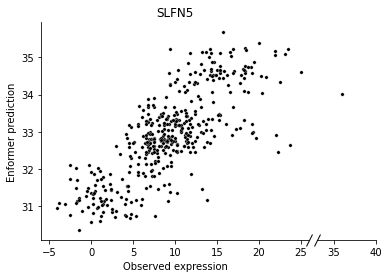

enformerGeuvadisScatterSNHG5.pdf


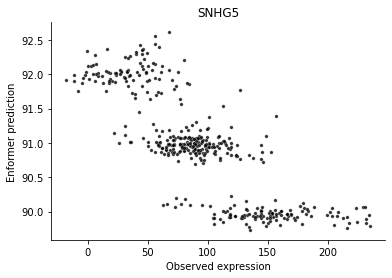

<Figure size 432x288 with 0 Axes>

In [25]:
models = ["Enformer"]
genes = ["slfn5", "snhg5"]
for method_name in models:
    for gene in genes:
        plot_preds_vs_geuvadis_gene(path_mapping[method_name], 
                                    gene,
                                    f"{method_name} prediction",
                                    pdf=f"{method_name.lower()}GeuvadisScatter{gene.upper()}.pdf",
                                    break_axis=(gene=="slfn5"))

In [255]:
f = h5py.File("/clusterfs/nilah/personalized_expression/model_predictions/enformer/enformer_ref_preds/ref_preds1.h5", "r")
genes, ref_preds = list(f["genes"]), np.array(f["ref_preds"]).astype(np.float)
print(ref_preds.shape)
preds = []
for i in range(len(genes)):
    preds += [np.max(ref_preds[i][896//2])]
df = pd.DataFrame(np.array([genes, preds]).T, columns=["gene", "Enformer"])
print(df)

(3259, 896)
            gene                Enformer
0        b'a1bg'   b'24.008745193481445'
1      b'a4galt'  b'0.14745961129665375'
2       b'aanat'   b'16.060928344726562'
3       b'aasdh'  b'0.05306750535964966'
4       b'abcb6'   b'118.30854034423828'
...          ...                     ...
3254  b'zscan21'    b'6.402346134185791'
3255  b'zscan23'  b'0.38416779041290283'
3256   b'zswim4'  b'0.02286934293806553'
3257     b'zxdc'   b'35.541439056396484'
3258   b'zyg11a'  b'0.05540885031223297'

[3259 rows x 2 columns]


In [98]:
np.array([15/4, 20/6])*1.3

array([4.875     , 4.33333333])

In [199]:
xpressoalt = pd.read_csv("/clusterfs/nilah/parth/xpresso_preds/alt_sig_eqtls.GM12878.preds.txt", sep="\t")
xpressoalt["gene"] = xpressoalt["ID"].apply(lambda i: i.split("|")[2])
#alt[alt["gene"]=="snhg5"]
basenjialt = pd.read_csv("/clusterfs/nilah/personalized_expression/top30_eqtl_40kb_preds/top30_eqtls_40kb_with_sed.csv")
basenjialt["name"] == 

SyntaxError: invalid syntax (<ipython-input-199-9ddc50f0fc4d>, line 5)

snhg5
enformerGeuvadisScatterSNHG5refalt.pdf


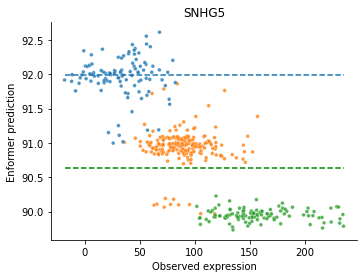

snhg5
basenji2GeuvadisScatterSNHG5refalt.pdf


<Figure size 360x288 with 0 Axes>

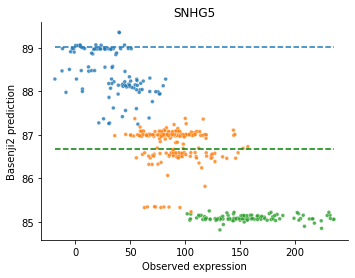

snhg5
xpressoGeuvadisScatterSNHG5refalt.pdf


<Figure size 360x288 with 0 Axes>

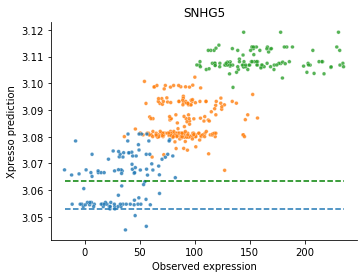

snhg5
expectoGeuvadisScatterSNHG5refalt.pdf


<Figure size 360x288 with 0 Axes>

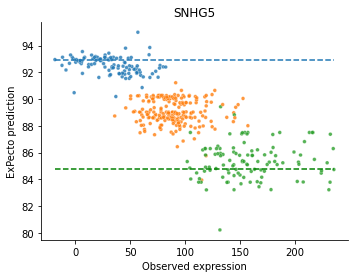

<Figure size 360x288 with 0 Axes>

In [115]:
all_ref_preds = pd.read_csv(pre+"predictions/all_models_ref_preds.csv")

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]
genes = ["snhg5"]
eqtldf = pd.read_csv("/clusterfs/nilah/personalized_expression/top30_eqtl_40kb_preds/top30_eqtls_40kb_with_sed.csv")

for method_name in models:
    for gene in genes:
        print(gene)
        row = eqtldf[eqtldf["name"]==gene] 
        dosage_df = pd.read_csv("/clusterfs/nilah/connie/enformer/data/dosages.tsv", sep="\t")
        dosage_df["#CHROM"] = dosage_df["#CHROM"].apply(lambda c: c.split("chr")[1]).astype(int)
        dosage_df = row.merge(dosage_df.rename({"#CHROM":"CHR_SNP","POS":"SNPpos"}, axis=1), on=["CHR_SNP", "SNPpos"])
        ref_pred = float(all_ref_preds[all_ref_preds["gene"] == gene][method_name])

        if method_name == "Enformer":
            f = h5py.File("/clusterfs/nilah/personalized_expression/model_predictions/enformer/enformer_eqtl_preds/enformer_eqtl_preds_top_10.h5", "r")
            gs, ref_preds, alt_preds = list(f["genes"]), np.array(f["ref_preds"]), np.array(f["alt_preds"]) 
            gindex = gs.index(bytes(gene, 'utf-8'))
            alt_pred = np.mean(f["alt_preds"][0][896//2-5:896//2+5])
            ref_pred = np.mean(f["ref_preds"][0][896//2-5:896//2+5])
        elif (method_name == "Basenji2") or (method_name == "ExPecto"):
            alt = pd.read_csv("/clusterfs/nilah/personalized_expression/top30_eqtl_40kb_preds/top30_eqtls_40kb_with_sed.csv")
            alt = alt[alt["name"]==gene]
            if method_name == "Basenji2":
                alt_pred = float(alt["basenji_ALT"])
            else:
                alt_pred = float(alt["expecto_ALT"])
                alt_pred = np.exp(alt_pred)-0.001
            ref_pred = np.exp(ref_pred)-0.001
        else:
            xpressoalt = pd.read_csv("/clusterfs/nilah/parth/xpresso_preds/alt_sig_eqtls.GM12878.preds.txt", sep="\t")
            xpressoalt["gene"] = xpressoalt["ID"].apply(lambda i: i.split("|")[2])
            alt_pred = float(xpressoalt[xpressoalt["gene"]==gene]["SCORE"])
            ref_pred = np.exp(ref_pred)-0.001
            alt_pred = np.exp(alt_pred)-0.001

        plot_preds_vs_geuvadis_gene(path_mapping[method_name], 
                                    gene,
                                    f"{method_name} prediction",
                                    pdf=f"{method_name.lower()}GeuvadisScatter{gene.upper()}refalt.pdf",
                                    ref_pred=ref_pred,
                                    alt_pred=alt_pred,
                                    dosage_df=dosage_df
                                   )

In [206]:
alt = pd.read_csv("/clusterfs/nilah/personalized_expression/top30_eqtl_40kb_preds/top30_eqtls_40kb_with_sed.csv")
alt = alt[alt["name"]==gene]
alt

name            GENE_ID     SNP_ID  CHR_SNP      SNPpos  TSSpos_x  \
0  snhg5  ENSG00000203875.4  rs1059307        6  86387888.0  86388451   

   log10pvalue REF ALT  basenji_REF  basenji_ALT  expecto_REF  expecto_ALT  
0   129.949608   G   T     89.03148     86.67549     4.531572     4.440489

In [223]:
dosage_df

#CHROM          POS               ID REF ALT  NA20826  NA07357  NA12058  \
0      chr6   86387888.0   snp_6_86387888   G   T        2        2        0   
1      chr1  213049214.0  snp_1_213049214   A   G        1        1        0   
2     chr17   33571546.0  snp_17_33571546   G   A        2        2        1   
3      chr6   42944850.0   snp_6_42944850   C   T        0        1        1   
4      chr7   23143113.0   snp_7_23143113   G   A        1        1        0   
...     ...          ...              ...  ..  ..      ...      ...      ...   
1600  chr19   58841548.0  snp_19_58841548   C   T        0        0        0   
1601  chr19   47812689.0  snp_19_47812689   G   A        0        0        1   
1602   chr8  145664673.0  snp_8_145664673   G   A        1        1        1   
1603   chr4   17574023.0   snp_4_17574023   A   G        2        1        2   
1604   chr6  132726355.0  snp_6_132726355   G   A        0        1        0   

      HG00378  HG00273  ...  NA19198  NA18508  NA18858  NA18910  NA18912  \
0           1        0  ...        0        1        0        0        0   
1           2        2  ...        1        1        2        1        0   
2           2        2  ...        2        2        2        1        1   
3           0        0  ...        0        0        1        1        2   
4           0        0  ...        1        2        2        1        1   
...       ...      ...  ...      ...      ...      ...      ...      ...   
1600        1        2  ...        0        0        0        0        0   
1601        1        1  ...        0        1        0        1        0   
1602        2        0  ...        0        1        2        0        1   
1603        1        2  ...        0        1        1        1        1   
1604        0        1  ...        0        1        0        1        0   

      NA18917  NA18916  NA19108  NA19107  NA19102  
0           0        0        1        2        0  
1           1        0        0        1        0  
2           2        1        2        1        1  
3           1        0        2        2        1  
4           2        1        0        1        1  
...       ...      ...      ...      ...      ...  
1600        0        0        0        0        0  
1601        0        0        1        0        2  
1602        0        1        0        2        1  
1603        0        1        1        1        1  
1604        0        1        1        0        0  

[1605 rows x 428 columns]

In [133]:
def plot_scatterplot(
    method_x_corrs, 
    method_y_corrs,
    method_x_name,
    method_y_name,
    s=3,
):
    
    merged_corrs = method_x_corrs.merge(method_y_corrs, on="name")
    
    method_x_corrs_l = merged_corrs["spearman_x"]
    method_y_corrs_l = merged_corrs["spearman_y"]
    spearman = compute_spearman_with_nans(method_x_corrs_l, method_y_corrs_l)
    
    fig, ax = plt.subplots(dpi=300)
    sns.scatterplot(x=method_x_corrs_l, y=method_y_corrs_l, s=s, ax=ax)
    ax.set(
        xlabel=f"cross-individual correlation of {method_x_name} to Geuvadis",
        ylabel=f"cross-individual correlation of {method_y_name} to Geuvadis",
        title=f"Spearman {spearman:.3f}"
    )
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(-1.0, 1.0)
    ax.set_aspect('equal', adjustable='box')
    plt.show()

def plot_contour_ryan(
    method_x_corrs, 
    method_y_corrs, 
    method_x_name,
    method_y_name,
    huedata=None,
    n_bins=36, 
    abs_x=False, # Absolute value of x axis
    abs_y=False, # Absolute value of y axis
    xpad=-40, 
    ypad=-50,
    pdf="", # Save model as pdf with given name
    contour=True, # Contour plot underneath scatter plot
    nonzero_analysis=False # Compare performance for genes with nonzero predixcan weights
):
    merged_corrs = method_x_corrs.merge(method_y_corrs, on="name")
    if huedata is not None:
        merged_corrs = merged_corrs.merge(huedata[["name", "nonzero weights"]])

    bonferroni = False
    if bonferroni:
        print(len(merged_corrs))
        merged_corrs_sig = merged_corrs[(merged_corrs["pvalue_x"]<(0.05/len(merged_corrs))) | 
                                       (merged_corrs["pvalue_y"]<(0.05/len(merged_corrs)))]
        merged_corrs = merged_corrs_sig
        print(len(merged_corrs))

    if abs_x:
        merged_corrs["spearman_x"] = np.abs(merged_corrs["spearman_x"])
    if abs_y:
        merged_corrs["spearman_y"] = np.abs(merged_corrs["spearman_y"])
    spearman = compute_spearman_with_nans(list(merged_corrs["spearman_y"]), list(merged_corrs["spearman_x"]))
    analyzing_corrs = merged_corrs[merged_corrs["spearman_x"]>0]
    
    if nonzero_analysis:
        thresh = 0.075
        thresh2 = 0.2

        analyzing_corrs["thresh"] = analyzing_corrs["spearman_y"].apply(
            lambda x: f"x<{thresh}" if np.abs(x)<thresh else 
            (f"{thresh}<x<{thresh2}" if np.abs(x)<thresh2 else f"x>{thresh2}"))


        analyzing_corrs["thresh"] = analyzing_corrs["thresh"].astype(str)
        ax = sns.boxplot(data=analyzing_corrs, y="nonzero weights", x="thresh", order=[f"x<{thresh}", 
                                                                                       f"{thresh}<x<{thresh2}", 
                                                                                       f"x>{thresh2}"])
        test_results = add_stat_annotation(ax, data=analyzing_corrs, y="nonzero weights", x="thresh",
                                           order=[f"x<{thresh}", f"{thresh}<x<{thresh2}", f"x>{thresh2}"],
                                           box_pairs=[(f"x<{thresh}", f"{thresh}<x<{thresh2}"), 
                                                      (f"x<{thresh}", f"x>{thresh2}"),
                                                      (f"{thresh}<x<{thresh2}", f"x>{thresh2}")],
                                           test='Mann-Whitney', text_format='full',
                                           loc='inside', verbose=2) 
        plt.xlabel(r"$|Spearman_{Enformer}|$")
    #    plt.xlabel(r"$|Spearman_{Enformer}-Spearman_{PrediXcan}|$")
        plt.ylabel("Average number of nonzero PrediXcan weights")
        #plt.xticks([0,1], [f">{thresh}", f"<{thresh}"])
        plt.show()
        plt.clf()
    
            
    #fig, ax = plt.subplots(dpi=300, subplot_kw=dict(projection='polar'))
    #patches = ax.bar(
    #    bin_centers, radii, 
    #    zorder=1, align='center', width=widths, edgecolor='C0', fill=False, linewidth=1
    #)
    

    theta = np.linspace(0.0, 2 * np.pi, n_bins, endpoint=False)
    plt.rcParams['figure.figsize'] = [10, 10]

    fig = plt.figure()
    #ax = fig.add_subplot()
    #axp = fig.add_axes(ax.get_position().bounds, polar=True, frameon=False)
    axp = fig.add_subplot()
    ax = fig.add_subplot(frameon=False)

    if contour:
        sns.kdeplot(data=merged_corrs, x="spearman_x", y="spearman_y", ax=axp, cmap="Reds", shade=True, bw_adjust=0.8)
        axp.set_xlim(-1,1)
        axp.set_ylim(-1,1)
    
    
    if not huedata is None:
        merged_corrs["nonzero weights"] = merged_corrs["nonzero weights"].apply(lambda w: np.minimum(40,w))
        plt.plot((0,0), (thresh2, -thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (thresh, 0.8+thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (-thresh, -0.8-thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh,0.8), (0, 0.8-thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh,0.8), (0, -0.8+thresh), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (thresh2, 0.8+thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((0,0.8), (-thresh2, -0.8-thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh2,0.8), (0, 0.8-thresh2), color="grey", linestyle="--", alpha=0.5)
        plt.plot((thresh2,0.8), (0, -0.8+thresh2), color="grey", linestyle="--", alpha=0.5)
    sns.scatterplot(data=merged_corrs, x="spearman_x", y="spearman_y", 
                    hue="nonzero weights" if huedata is not None else None, 
                    color="black", s=10, alpha=0.7, ax=ax)
    plt.xlabel("")
    plt.ylabel("")
    if huedata is not None:
        L=plt.legend(title="Average number of nonzero PrediXcan weights")
        L.get_texts()[-1].set_text('>40')
    
    if contour:
        ax.set_frame_on(True)
        ax.spines['bottom'].set_position('zero')
        ax.spines['bottom'].set_bounds(low=-1, high=1)
        ax.spines['left'].set_position('zero')
        ax.spines['left'].set_bounds(low=-1, high=1)
        ax.set_facecolor('none')
        ax.set_yticks([-1,-0.5,0.5,1])
        ax.set_xticks([-1,-0.5,0.5,1])
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_linewidth(1.5)
        ax.xaxis.set_tick_params(labelsize=22)
        ax.yaxis.set_tick_params(labelsize=22)
    else:
        ax.set_frame_on(True)

    axp.set_xticklabels([])
    axp.set_yticklabels([])
    axp.set_xticks([])
    axp.set_yticks([])
    [v.set_visible(False) for k,v in axp.spines.items()]
    absx = "|" if abs_x else ""
    absy = "|" if abs_y else ""
    if contour:
        axp.set_xlabel(f"{absx}{method_x_name}{absx} cross-individual correlation", size=26, labelpad=16)
        axp.set_ylabel(f"{absy}{method_y_name}{absy} cross-individual correlation", size=26, labelpad=16)
    else:
        ax.set_xlabel(f"{absx}{method_x_name}{absx} cross-individual correlation", size=20)
        ax.set_ylabel(f"{absy}{method_y_name}{absy} cross-individual correlation", size=20, labelpad=8)

    
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    #axp.set_title(f"Spearman correlation={spearman:.3f}", fontsize=10)
    if contour:
        plt.text(0, 1.1, f"Spearman {spearman:.3f}", ha="center", fontsize=27)
    if pdf != "":
        plt.savefig(pdf, format="pdf")
    plt.show()
    #plt.tight_layout()
    return 

Enformer
Basenji2


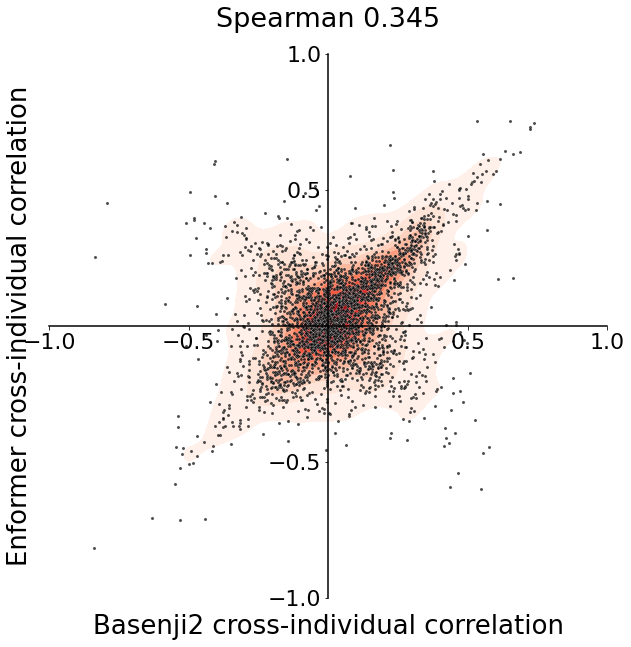

Enformer
Xpresso


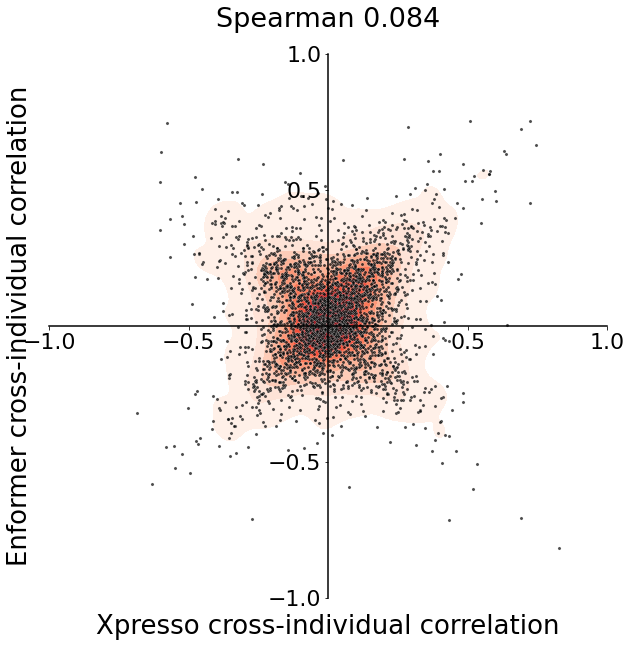

Enformer
ExPecto


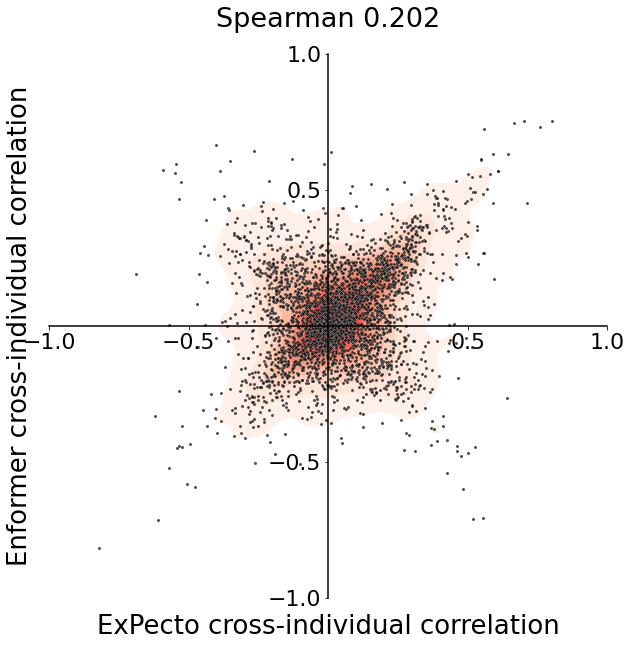

Enformer
PrediXcan


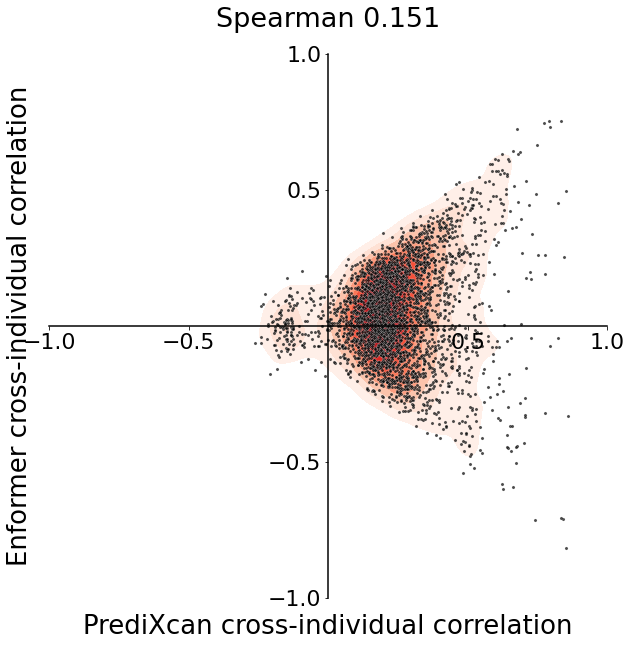

Basenji2
Xpresso


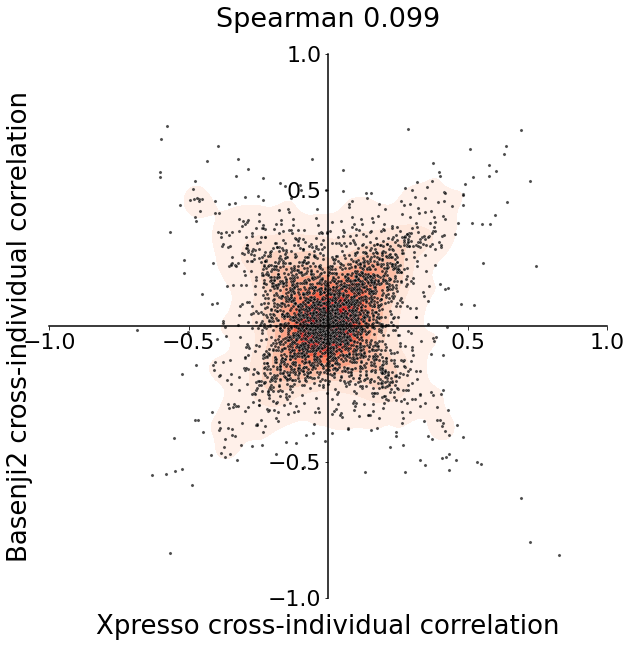

Basenji2
ExPecto


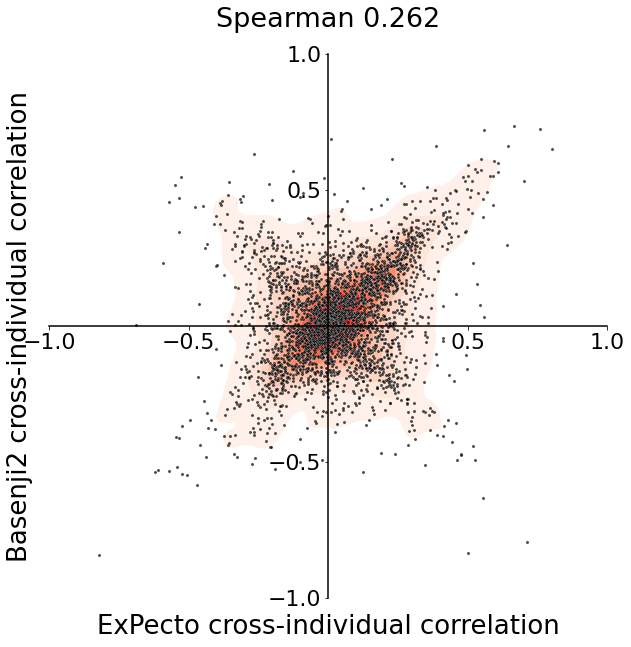

Basenji2
PrediXcan


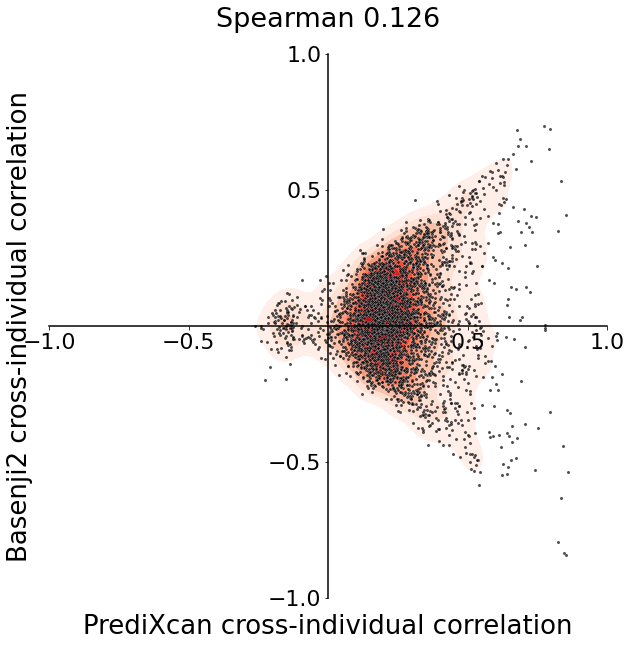

Xpresso
ExPecto


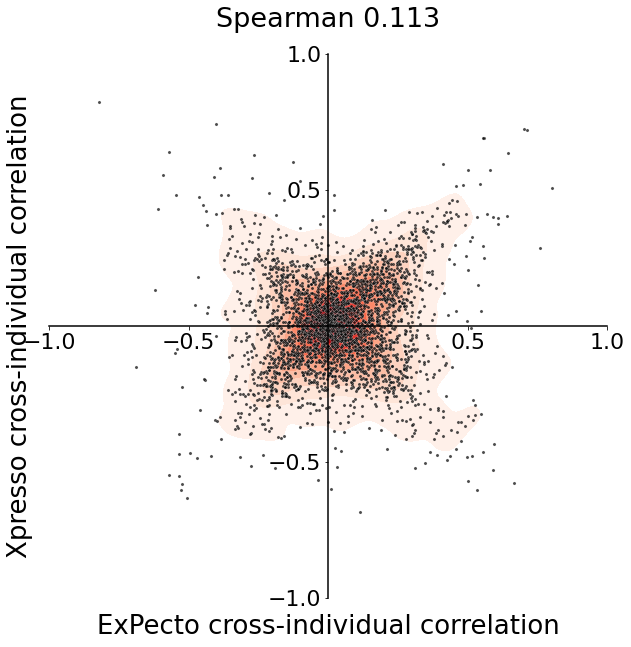

Xpresso
PrediXcan


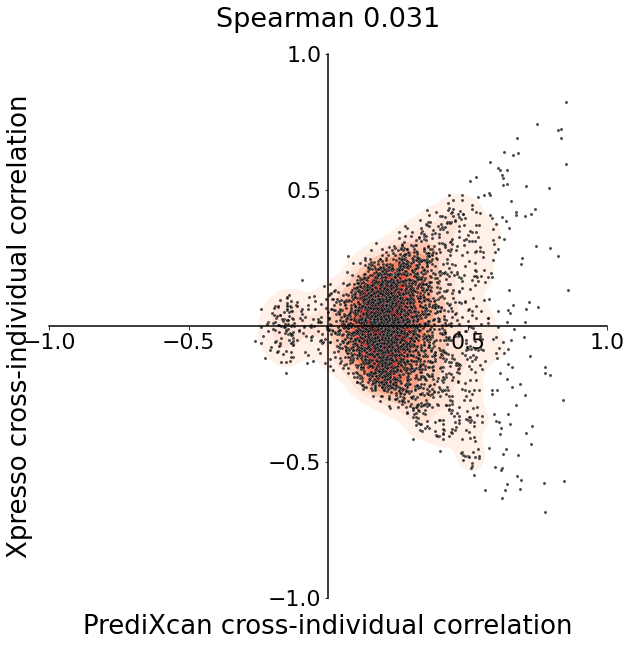

ExPecto
PrediXcan


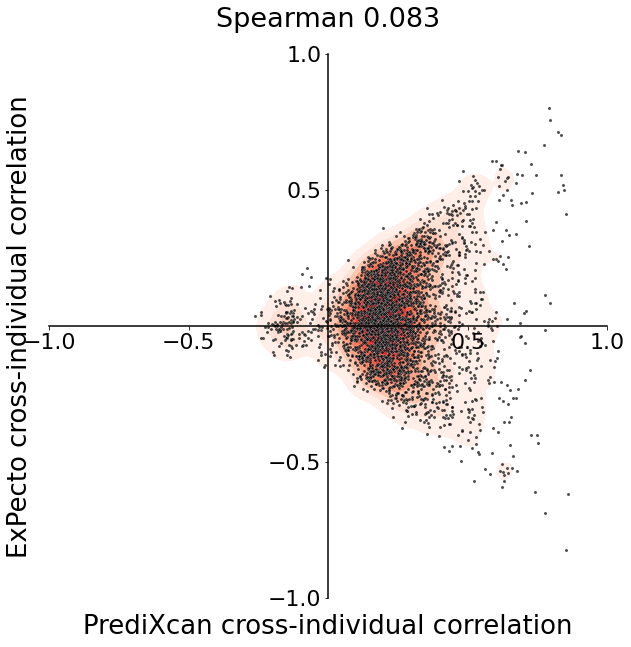

In [134]:
# Figure 2B, Extended Data Fig 4
## TODO: increase size of x and ytick labels
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto", "PrediXcan"]

for i in range(len(models)):
    for j in range(len(models)-i):
        if j+i+1 < len(models):
            m1 = models[i]
            m2 = models[j+i+1]
            print(m1)
            print(m2)
            _ = plot_contour_ryan(corr_mapping[m2], corr_mapping[m1], m2, m1, 
                                             xpad=-45, ypad=-35, pdf=m1.lower()+m2+"Spearman.pdf")

In [14]:
eqtl_df = pd.read_csv("/clusterfs/nilah/rkchung/data/geuvadis/pvalues_rvalues_top_eqtls_within_20kb.csv")
eqtl_df

name        pvalue  log10pvalue    rvalue
0      a4galt  1.359868e-10     9.866503 -0.324575
1       aanat  1.501777e-11    10.823394  0.340164
2       aasdh  5.640776e-11    10.248661 -0.330907
3       abcd2  2.358498e-06     5.627365 -0.241613
4      abhd10  6.540089e-07     6.184416 -0.254228
...       ...           ...          ...       ...
2473  zscan21  3.110748e-06     5.507135 -0.238798
2474  zscan23  2.819083e-21    20.549892  0.463879
2475   zswim4  3.299800e-23    22.481512  0.483380
2476     zxdc  2.935877e-08     7.532262  0.282272
2477   zyg11a  6.067940e-06     5.216959  0.231859

[2478 rows x 4 columns]

In [15]:
all_eqtl = pd.read_csv("/clusterfs/nilah/Geuvadis/E-GEUV-1/analysis_results/EUR373.gene.cis.FDR5.all.rs137.txt.gz", 
                       sep="\t")
all_eqtl["SNP_ID"]

all_eqtl = all_eqtl[all_eqtl["distance"]<20000]
all_eqtl = all_eqtl.sort_values('log10pvalue', ascending=False).drop_duplicates(['GENE_ID'])
all_eqtl["Gene stable ID"] = all_eqtl["GENE_ID"].apply(lambda g: g.split(".")[0])
all_eqtl
# TODO look at allele frequency in gnomad (correlates with model performance?)
# finemapped eqtls from Alan (and check if eqtl effect size and distance for top PIP correlates with performance)
# can we get per base transformer perplexity for drivers (from saras paper)

SNP_ID ID             GENE_ID            PROBE_ID  CHR_SNP  \
167673   rs1059307  -   ENSG00000203875.4   ENSG00000203875.4        6   
226243  rs12123978  -   ENSG00000198468.2   ENSG00000198468.2        1   
265620   rs1131017  -   ENSG00000197728.5   ENSG00000197728.5       12   
322299  rs11080327  -   ENSG00000166750.4   ENSG00000166750.4       17   
84178    rs6907751  -   ENSG00000124587.9   ENSG00000124587.9        6   
...            ... ..                 ...                 ...      ...   
399222  rs60925053  -   ENSG00000197405.2   ENSG00000197405.2       19   
270169  rs35129588  -   ENSG00000258365.1   ENSG00000258365.1       12   
215211   rs2242268  -  ENSG00000160949.11  ENSG00000160949.11        8   
50781   rs28822977  -   ENSG00000002549.7   ENSG00000002549.7        4   
176067   rs1338937  -  ENSG00000079931.10  ENSG00000079931.10        6   

        CHR_GENE       SNPpos     TSSpos  distance    rvalue         pvalue  \
167673         6   86387888.0   86388451     563.0  0.893956  1.123032e-130   
226243         1  213049214.0  213031430   17784.0  0.889099  2.654481e-127   
265620        12   56435929.0   56435637     292.0 -0.879921  2.460191e-121   
322299        17   33571546.0   33570086    1460.0  0.851917  9.037055e-106   
84178          6   42944850.0   42946958    2108.0  0.850969  2.664694e-105   
...          ...          ...        ...       ...       ...            ...   
399222        19   47812689.0   47813104     415.0 -0.231362   6.359950e-06   
270169        12   94691556.0   94676620   14936.0 -0.231290   6.403593e-06   
215211         8  145664673.0  145669827    5154.0  0.231265   6.418490e-06   
50781          4   17574023.0   17578815    4792.0 -0.231189   6.464992e-06   
176067         6  132726355.0  132722684    3671.0 -0.231025   6.566144e-06   

        log10pvalue   Gene stable ID  
167673   129.949608  ENSG00000203875  
226243   126.576020  ENSG00000198468  
265620   120.609031  ENSG00000197728  
322299   105.043973  ENSG00000166750  
84178    104.574353  ENSG00000124587  
...             ...              ...  
399222     5.196546  ENSG00000197405  
270169     5.193576  ENSG00000258365  
215211     5.192567  ENSG00000160949  
50781      5.189432  ENSG00000002549  
176067     5.182690  ENSG00000079931  

[2478 rows x 13 columns]

In [16]:
afs = pd.read_csv("/clusterfs/nilah/rkchung/data/geuvadis/EUR373.gene.cis.top.rsid.biomartaf.csv")
all_eqtl = afs[["refsnp_id", "minor_allele_freq"]].rename({"refsnp_id":"SNP_ID"},axis=1)\
                                                  .merge(all_eqtl, on="SNP_ID")
all_eqtl = all_eqtl.drop_duplicates()

In [17]:
all_eqtl

SNP_ID  minor_allele_freq ID             GENE_ID  \
0      rs67529032            0.28020  -   ENSG00000153898.8   
1        rs425437            0.21980  -   ENSG00000162817.6   
2        rs500812            0.22720  -  ENSG00000187145.10   
3      rs10920208            0.43930  -   ENSG00000224818.1   
4     rs113191295            0.02216  -   ENSG00000198837.5   
...           ...                ... ..                 ...   
2613    rs7790545            0.28160  -   ENSG00000106302.5   
2614   rs10258097            0.31150  -   ENSG00000240583.5   
2615   rs11068338            0.17350  -  ENSG00000088992.13   
2616   rs10261515            0.48540  -   ENSG00000257093.2   
2618   rs10263380            0.29210  -  ENSG00000105877.12   

                PROBE_ID  CHR_SNP  CHR_GENE       SNPpos     TSSpos  distance  \
0      ENSG00000153898.8        1         1   85453471.0   85462796    9325.0   
1      ENSG00000162817.6        1         1  220868508.0  220863187    5321.0   
2     ENSG00000187145.10        1         1  150269545.0  150266289    3256.0   
3      ENSG00000224818.1        1         1  201431247.0  201434274    3027.0   
4      ENSG00000198837.5        1         1  153912623.0  153919172    6549.0   
...                  ...      ...       ...          ...        ...       ...   
2613   ENSG00000106302.5        7         7  123474227.0  123469037    5190.0   
2614   ENSG00000240583.5        7         7   30876432.0   30893010   16578.0   
2615  ENSG00000088992.13       12        12  117542107.0  117537284    4823.0   
2616   ENSG00000257093.2        7         7  141398707.0  141401953    3246.0   
2618  ENSG00000105877.12        7         7   21578343.0   21582833    4490.0   

        rvalue        pvalue  log10pvalue   Gene stable ID  
0     0.509700  5.102732e-26    25.292197  ENSG00000153898  
1     0.482543  4.018199e-23    22.395969  ENSG00000162817  
2     0.323455  1.585554e-10     9.799819  ENSG00000187145  
3    -0.324138  1.444062e-10     9.840414  ENSG00000224818  
4     0.269419  1.272269e-07     6.895421  ENSG00000198837  
...        ...           ...          ...              ...  
2613 -0.244288  1.807255e-06     5.742981  ENSG00000106302  
2614  0.361364  6.120910e-13    12.213184  ENSG00000240583  
2615 -0.270796  1.091188e-07     6.962100  ENSG00000088992  
2616  0.545375  3.072046e-30    29.512572  ENSG00000257093  
2618 -0.273960  7.643427e-08     7.116712  ENSG00000105877  

[2352 rows x 14 columns]

In [43]:
eqtl_df = eval_genes.merge(all_eqtl.rename({"Gene stable ID": "gene_id"}, axis=1), 
                 on="gene_id", how="outer")[["GENE_ID", "name", "distance", "minor_allele_freq", 
                                                        "rvalue", "log10pvalue"]]
#plidf = pd.read_csv("/clusterfs/nilah/rkchung/data/expred/exac_data_pLI.txt", sep="\t")
#plidf["name"] = plidf["gene"].apply(lambda t: t.lower())
#eqtl_df = eqtl_df.merge(plidf[["name", "pLI"]], on="name")

In [44]:
eqtl_df

GENE_ID             name  distance  minor_allele_freq  \
0     ENSG00000000457.8            scyl3   12249.0             0.3822   
1                   NaN          cyp51a1       NaN                NaN   
2     ENSG00000002549.7             lap3    4792.0             0.3698   
3     ENSG00000002745.7            wnt16    7824.0             0.1597   
4                   NaN             m6pr       NaN                NaN   
...                 ...              ...       ...                ...   
3254  ENSG00000262879.1       ac005670.3    1419.0             0.2378   
3255  ENSG00000262951.1  ensg00000262951    2326.0             0.3019   
3256  ENSG00000262992.1  ensg00000262992   14379.0             0.4109   
3257  ENSG00000263004.1       ac007114.1    3333.0             0.2714   
3258  ENSG00000263280.1       ac003965.1     917.0             0.1320   

        rvalue  log10pvalue  
0    -0.250791     6.029674  
1          NaN          NaN  
2    -0.231189     5.189432  
3     0.296125     8.255660  
4          NaN          NaN  
...        ...          ...  
3254  0.367439    12.630879  
3255 -0.343021    11.004666  
3256  0.306743     8.836833  
3257 -0.394058    14.567516  
3258  0.389772    14.243682  

[3259 rows x 6 columns]

In [9]:
def reject_outliers(data, m=2):
    data = data[np.isfinite(data)]
    return data[abs(data - np.nanmean(data)) < (m * np.nanstd(data))]
    
def compare_to_feat(corrs, xlabel=r"$log(distanceToTSS)$", ylabel="", pdf="", feat="median"):
    plt.rcParams['figure.figsize'] = [5, 4]
    
    if feat == "median":
        geuvadis_df = pd.read_csv(GEUVADIS_PATH, index_col=0)
        genes = list(set(list(corrs.name)).intersection(set(geuvadis_df.columns)))
    else:
        genes = list(set(list(corrs.name)))
        
    if feat in ["distance","minor_allele_freq","rvalue","log10pvalue"]:
        corrs = corrs.merge(eqtl_df, on="name")

    corrs_l = []
    for g in genes:
        corrs_l += [list(corrs[corrs["name"]==g]["spearman"])[0]]
    if feat == "median":
        feat = [log_transform(np.median(geuvadis_df[g])) for g in genes]
    elif feat == "pLI":
        feat = corrs["pLI"]
    
    fig, ax = plt.subplots(dpi=300)
    res = dv.regplot(y=corrs_l, x=feat, ci = 0,
                     line_kws={"c":"black"}, scatter_kws={"s":2, "c":"black"})
    #nona = merged[merged[y]<0][[x, y]].dropna()
    pearsonout = compute_pearson_with_nans(corrs_l, feat)
    text_left = 0.01*(np.nanmax(feat)-np.nanmin(feat))+np.nanmin(feat)
    text_bottom = 0.01*(np.nanmax(corrs_l)-np.nanmin(corrs_l))+np.nanmin(corrs_l)
    print(text_left)
    print(text_bottom)
    plt.text(text_left, text_bottom, "Pearson %.3f" %  pearsonout[0], color="black")

    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        #title=f"Spearman correlation = {spearman:.3f}"
    )

    if pdf!="":
        plt.savefig(pdf, format="pdf")
    plt.show()
    
def compare_to_model_coefficient_of_variation(corrs, PREDS_PATH, 
                                              xlabel="", 
                                              ylabel="",
                                              pdf=""):
    plt.rcParams['figure.figsize'] = [5, 4]
    model_df = pd.read_csv(PREDS_PATH, index_col=0)
    
    genes = list(set(list(corrs.name)).intersection(set(model_df.columns)))
            
    corrs_l = []
    model_cvs = []
    for g in genes:
        data = model_df[g]
        cv = np.std(data) / np.mean(data)
        model_cvs.append(cv)
        corrs_l += [list(corrs[corrs["name"]==g]["spearman"])[0]]
    #spearman = compute_spearman_with_nans(corrs_l, model_cvs)
    
    fig, ax = plt.subplots(dpi=300)
    
    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
        #title=f"Spearman correlation = {spearman:.3f}",
        #xscale='log'
    )
    model_cvs = np.log(model_cvs)
    res = dv.regplot(y=corrs_l, x=model_cvs, ci = 0,
                     line_kws={"c":"black"}, scatter_kws={"s":2, "c":"black"}, ax=ax)
    #sns.scatterplot(y=corrs_l, x=model_cvs, s=3)
    #nona = model_df[model_df["spearman"]<0][[x, y]].dropna()
    
    pearsonout = compute_pearson_with_nans(corrs_l, model_cvs)
    
    #text_middle = 0.3*(np.min(model_cvs)-np.max(model_cvs))+np.max(model_cvs)
    text_left = 0.05*(np.nanmax(reject_outliers(model_cvs))-\
                      np.nanmin(reject_outliers(model_cvs))
                     )+np.nanmin(reject_outliers(model_cvs))
    text_bottom = 0.01*(np.nanmax(corrs_l)-np.nanmin(corrs_l))+np.nanmin(corrs_l)
    plt.text(text_left, text_bottom, "Pearson %.3f" %  pearsonout[0], ha='center', color="black")
    
    #plt.text(text_middle, 0.75, "Pearson %.3f; P=%.1e" %  pearsonout, ha='center', color="black")
    if pdf!="":
        plt.savefig(pdf, format="pdf")
    plt.show()

enformerMedianExpression.pdf
-3.829939112485899
-0.8015004418719252


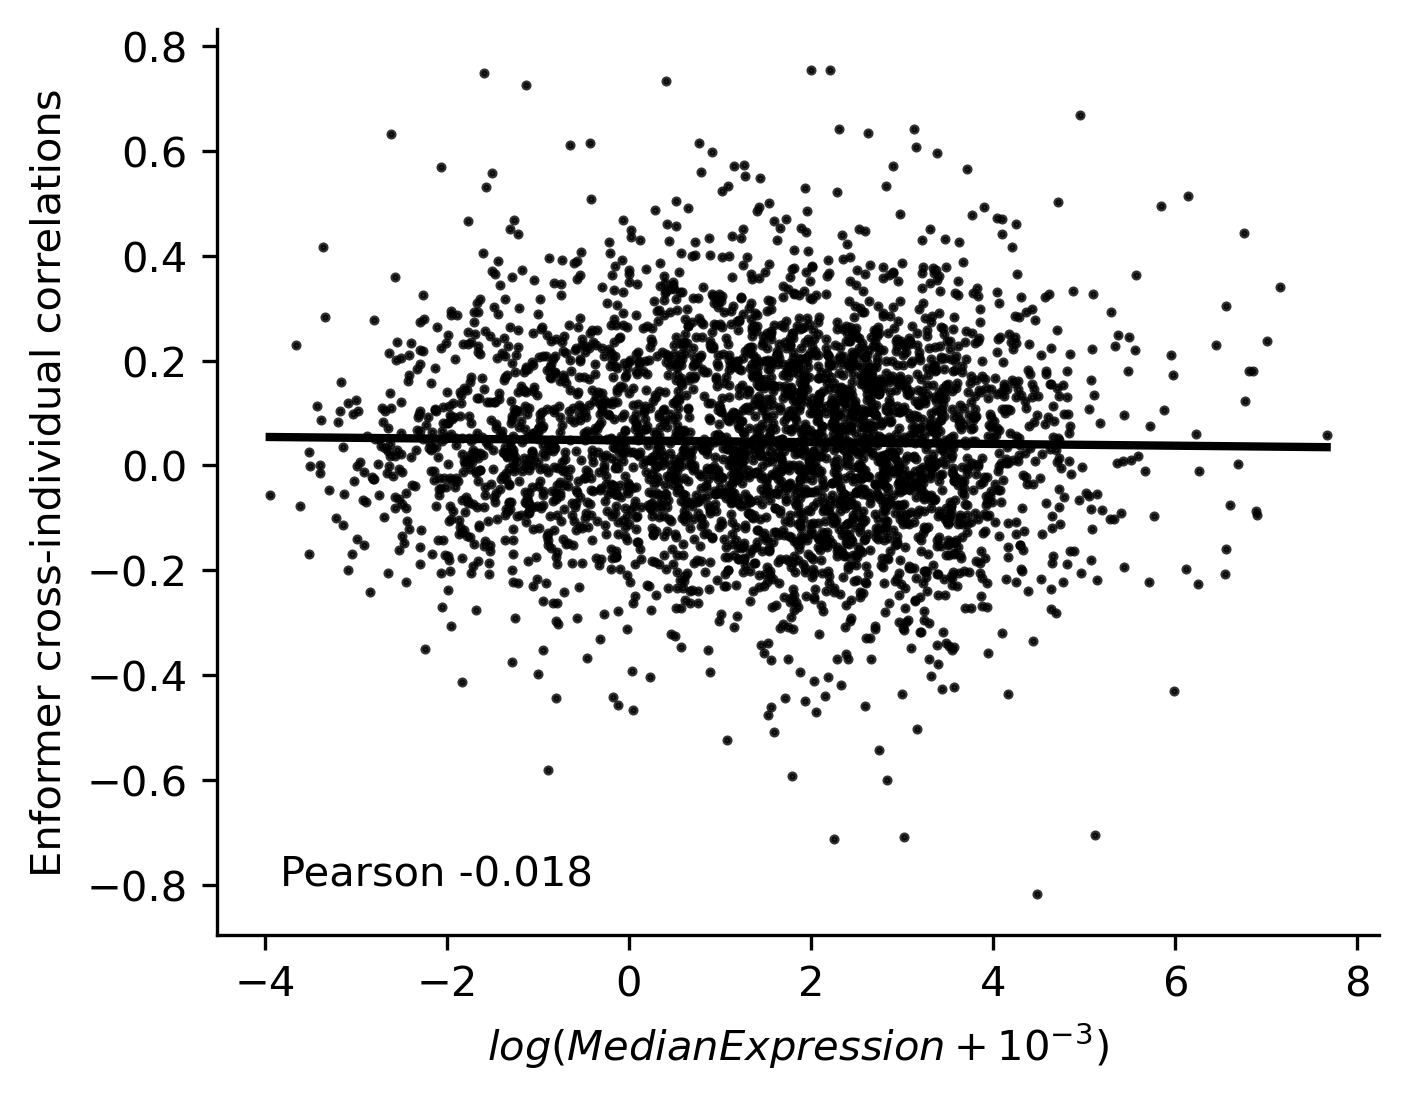

basenji2MedianExpression.pdf
-3.829939112485899
-0.8253033708346778


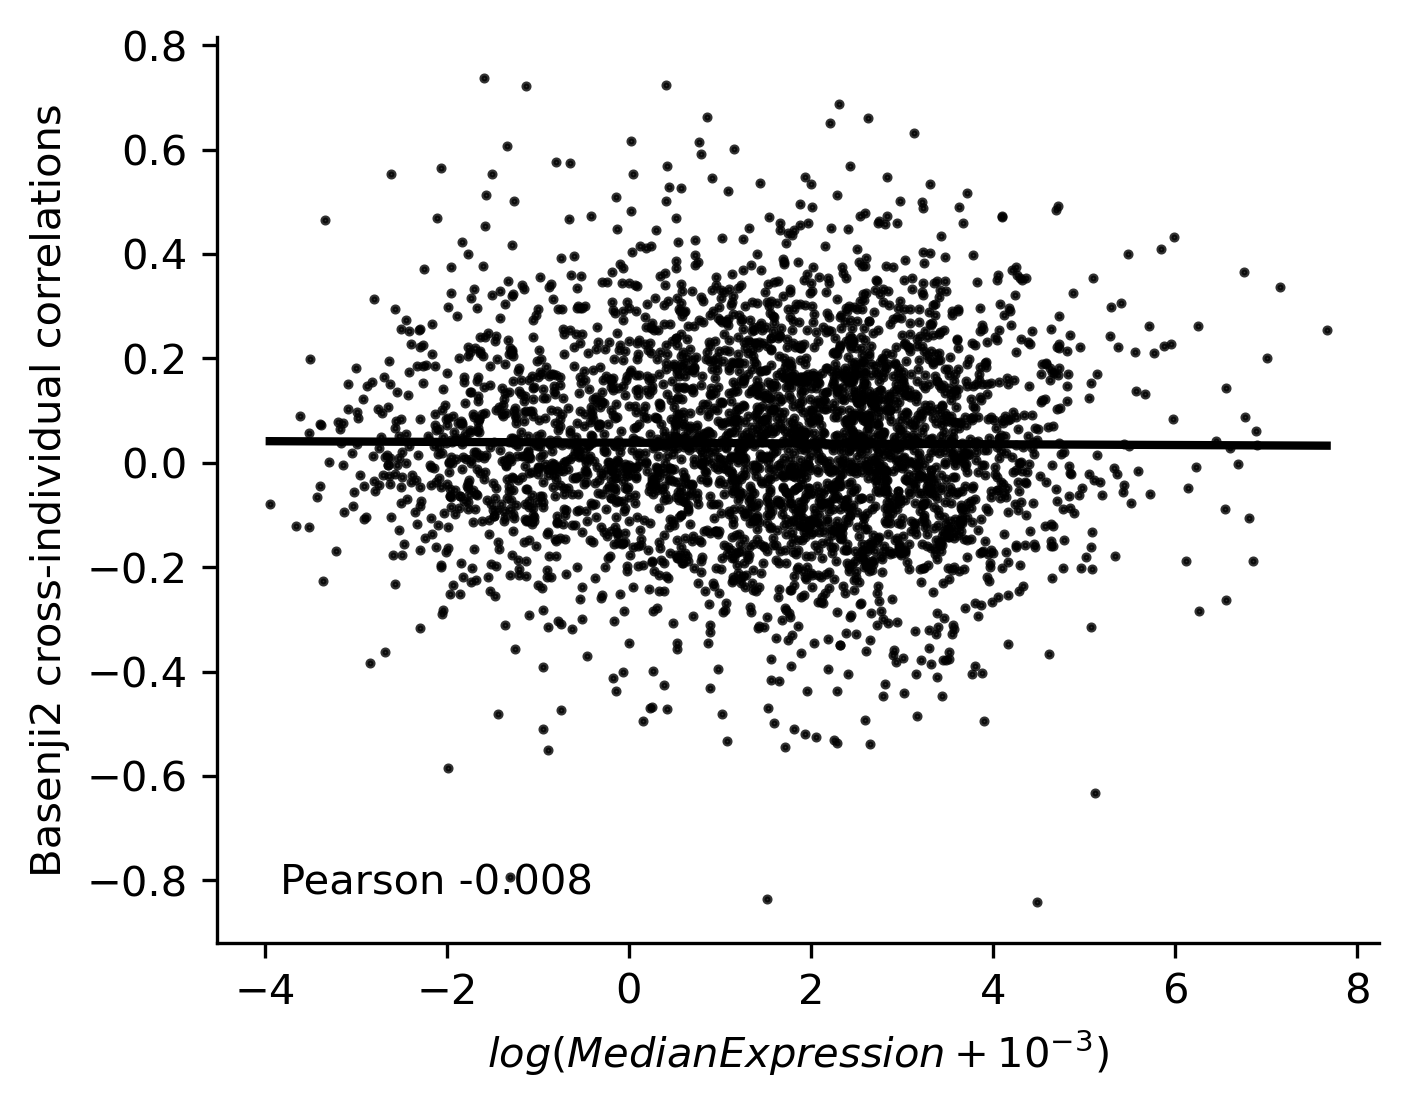

xpressoMedianExpression.pdf
-3.829939112485899
-0.6687226119781547


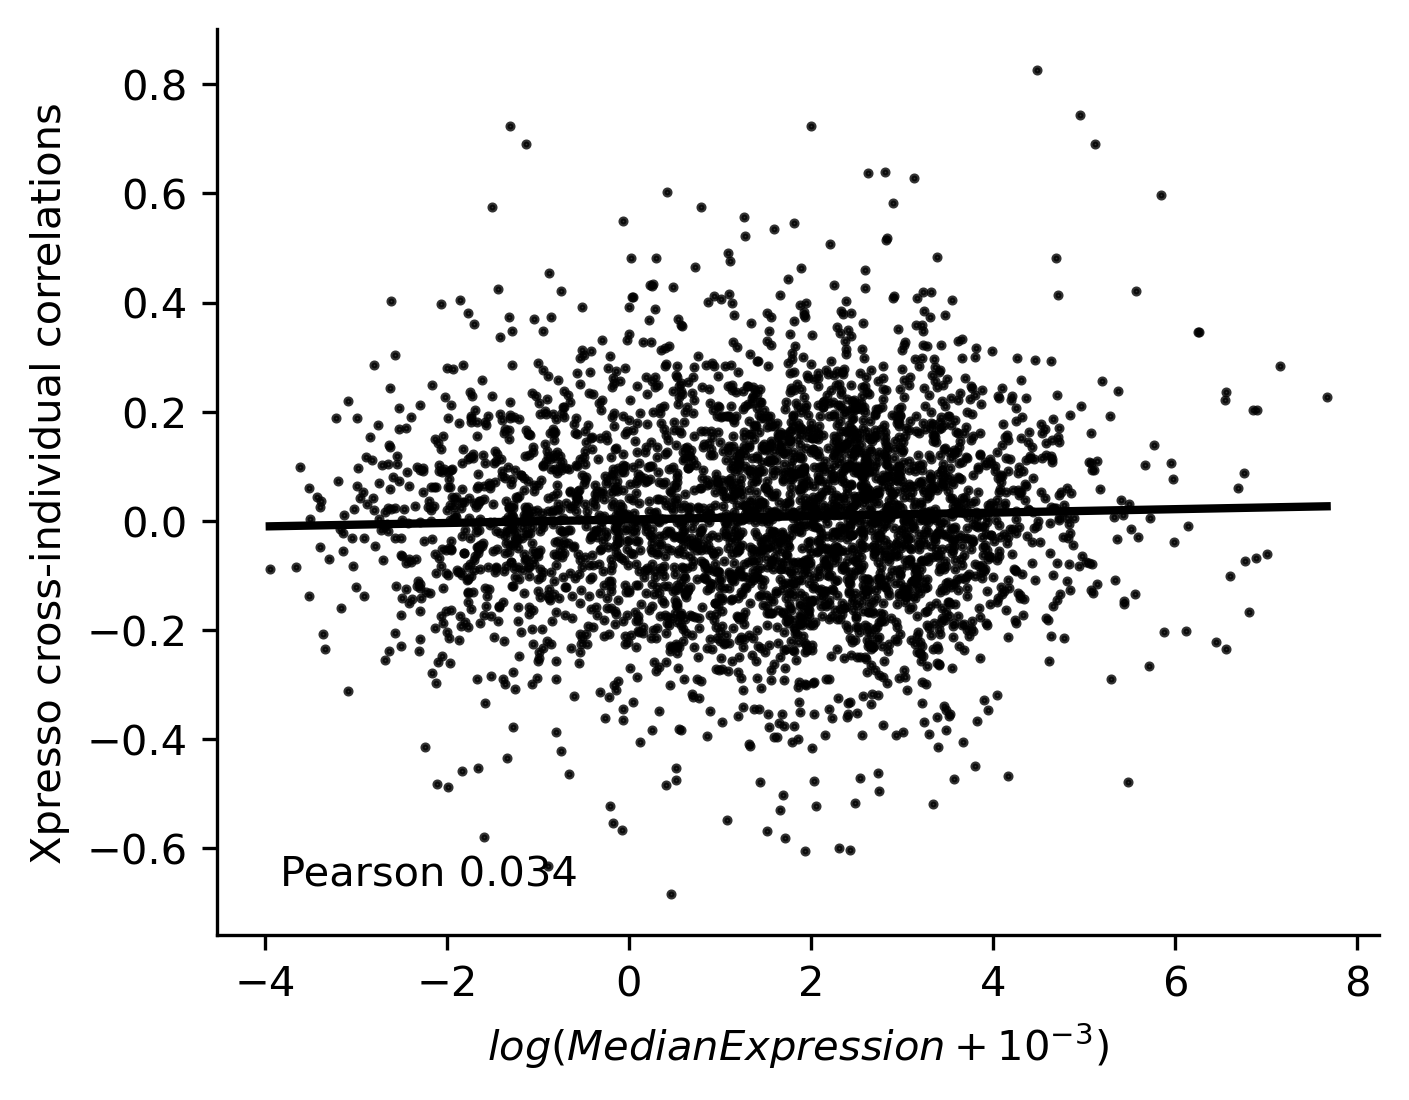

expectoMedianExpression.pdf
-3.829939112485899
-0.8061337797257346


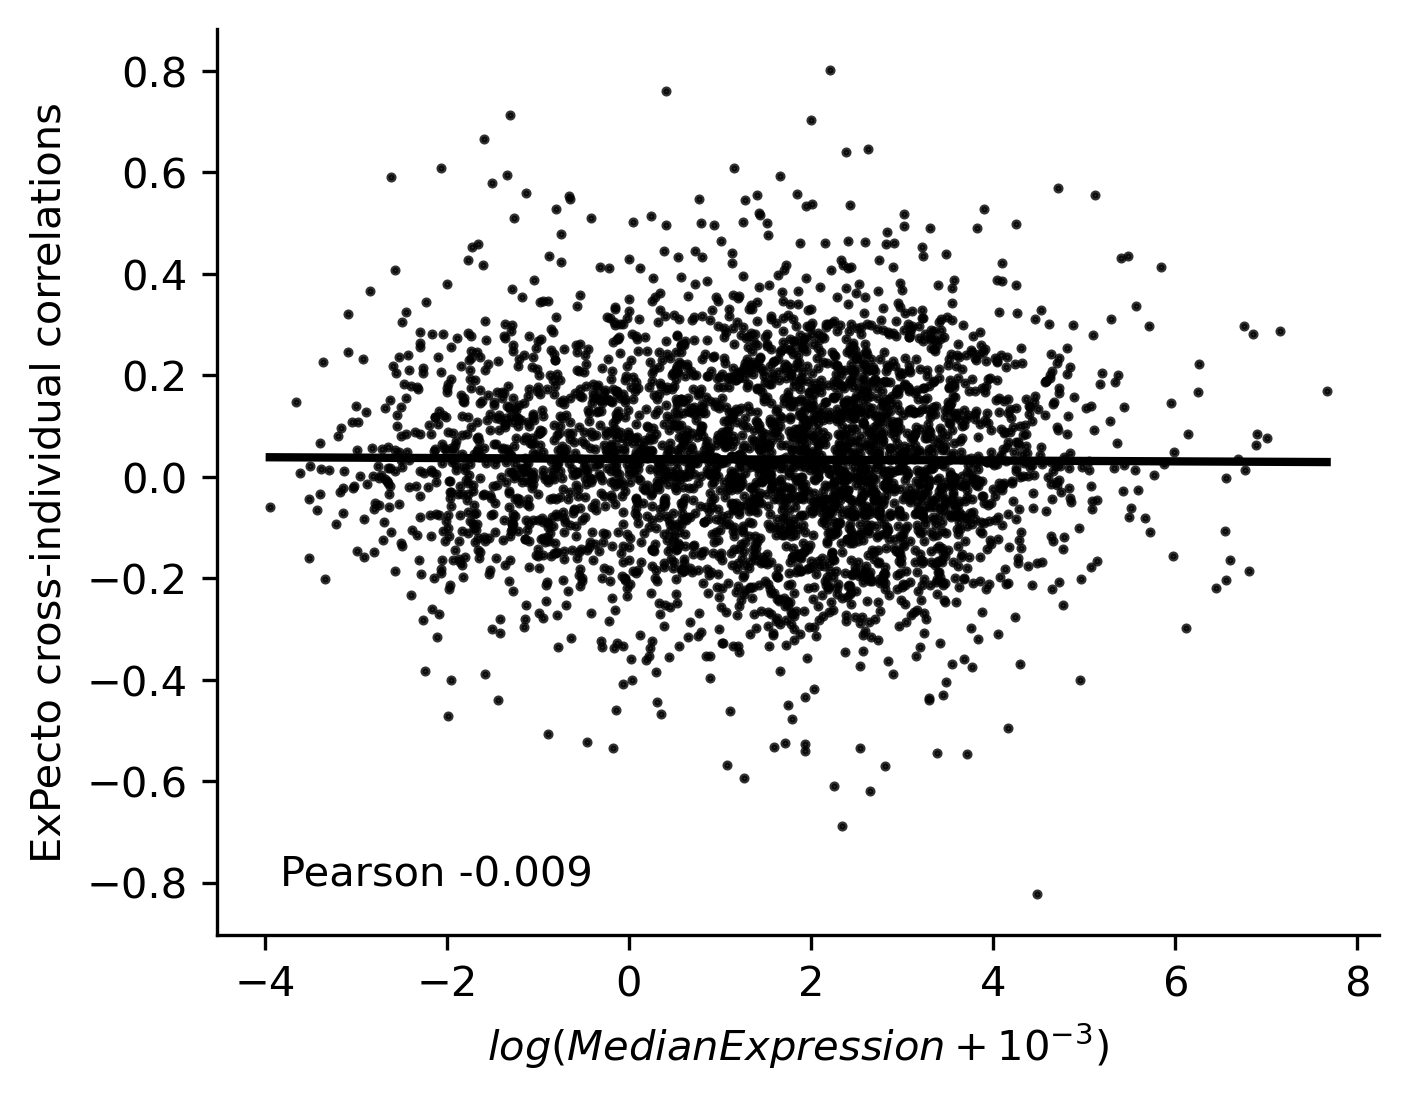

In [20]:
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]
#models = ["AverageModel"]

for method_name in models:
    print(method_name.lower()+"MedianExpression.pdf")
    compare_to_feat(corr_mapping[method_name],
                    xlabel=r"$log(MedianExpression + 10^{-3})$",
                    ylabel=f"{method_name} cross-individual correlations",
                    pdf=method_name.lower()+"MedianExpression.pdf")

enformerCoefVar.pdf


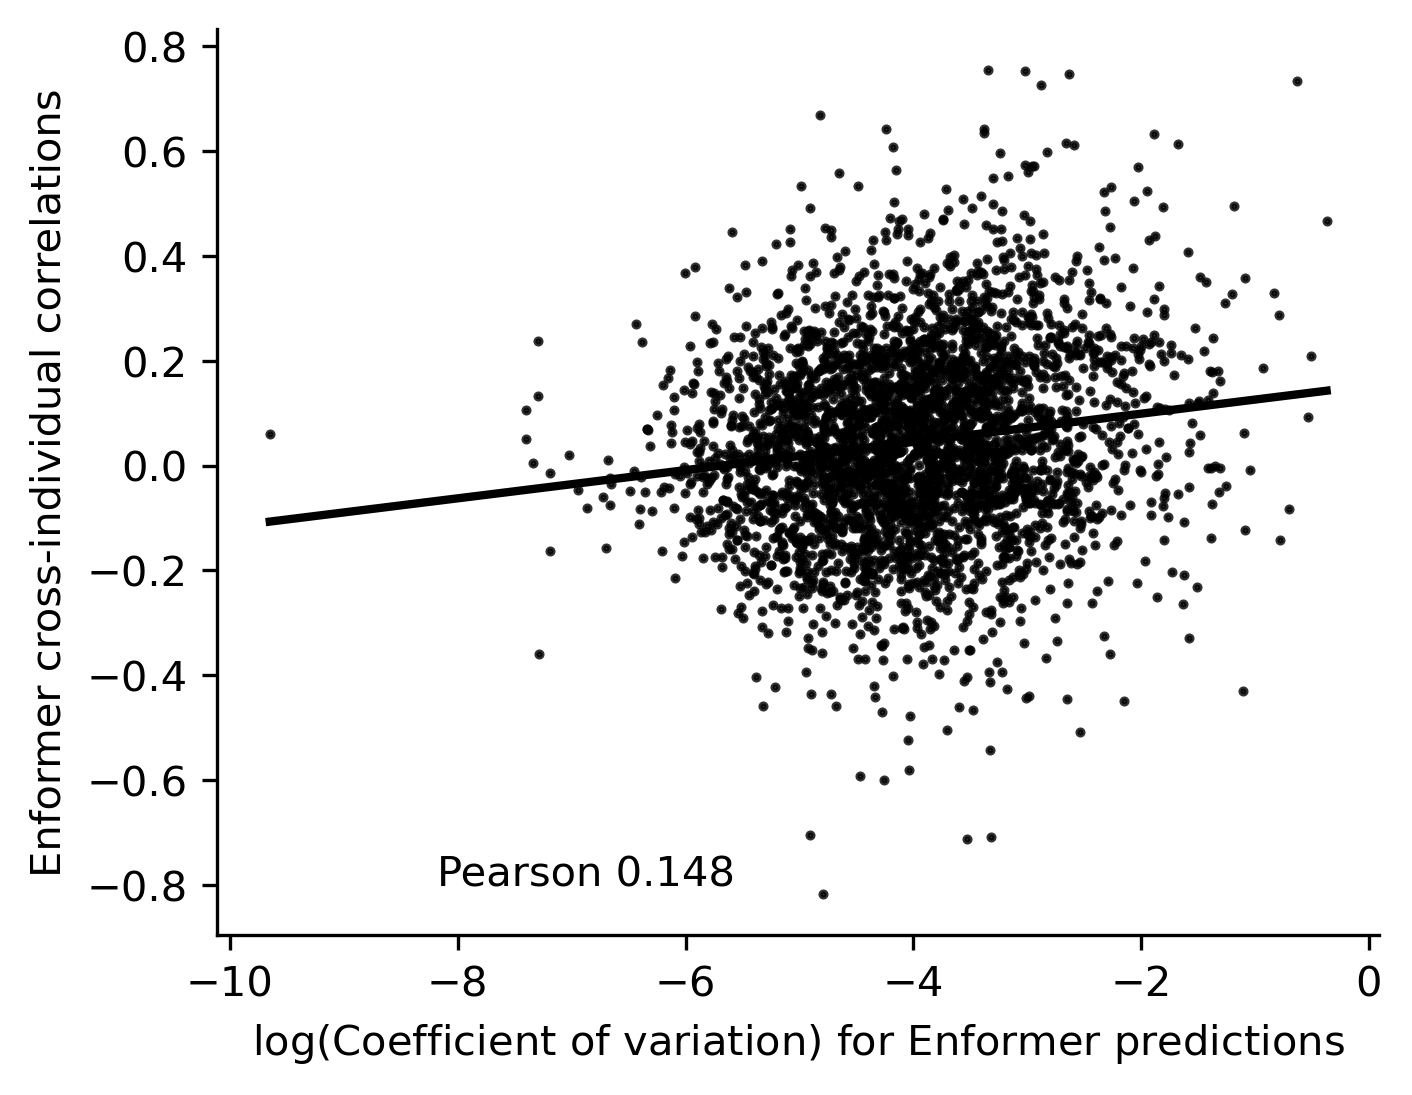

basenji2CoefVar.pdf


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log


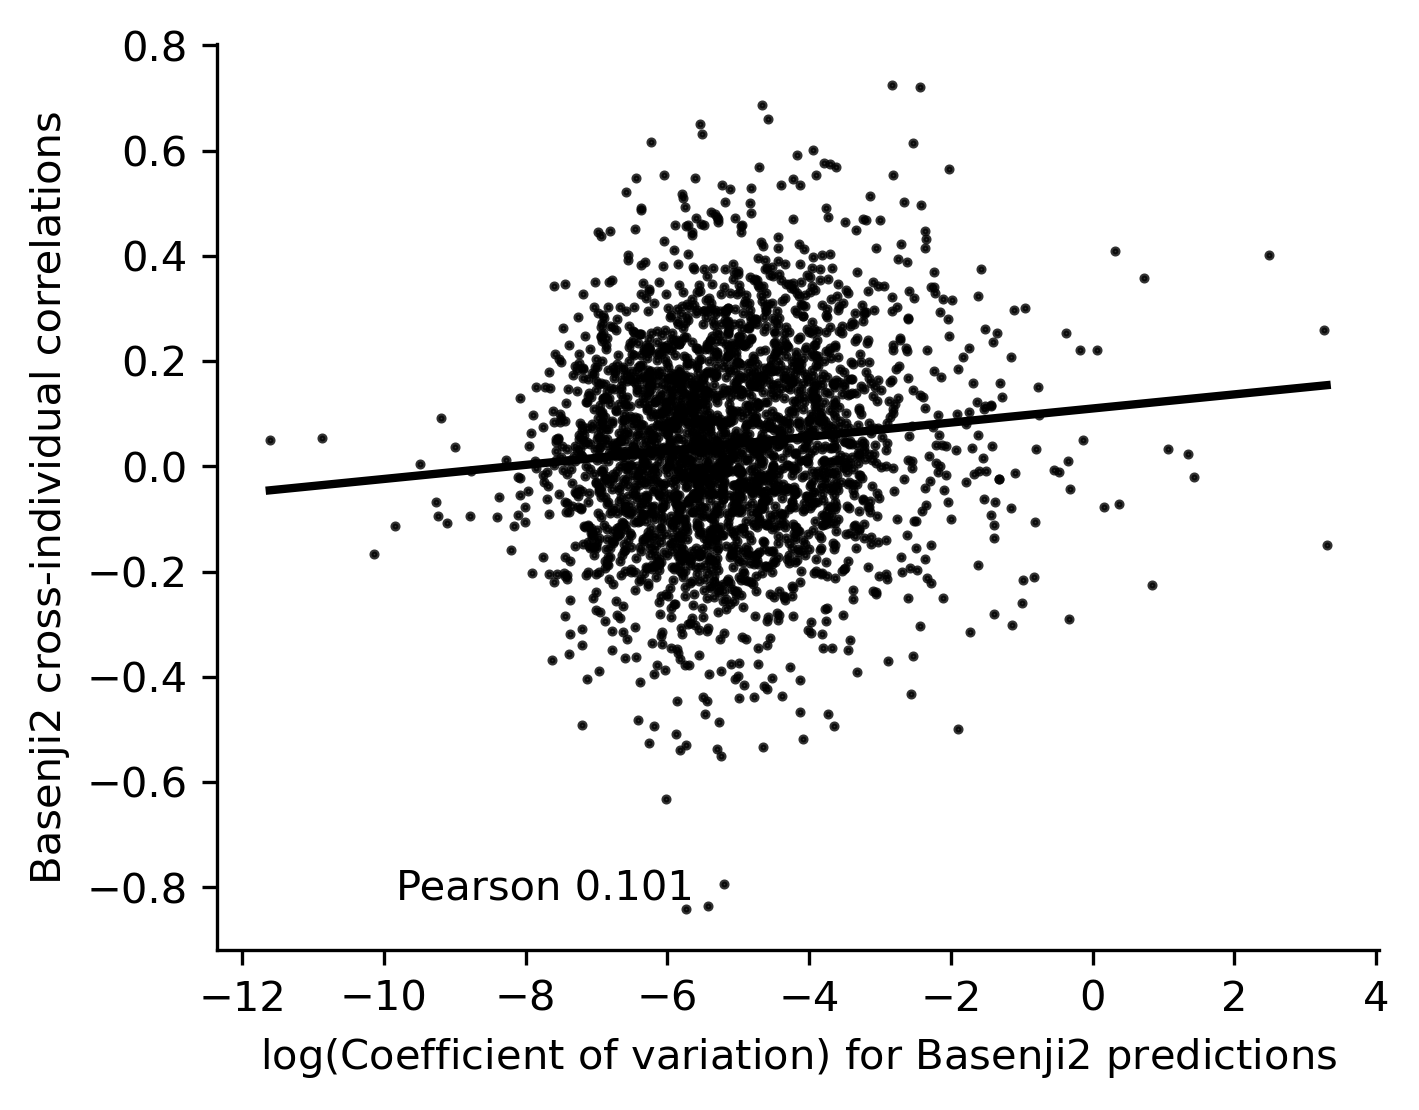

xpressoCoefVar.pdf


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log


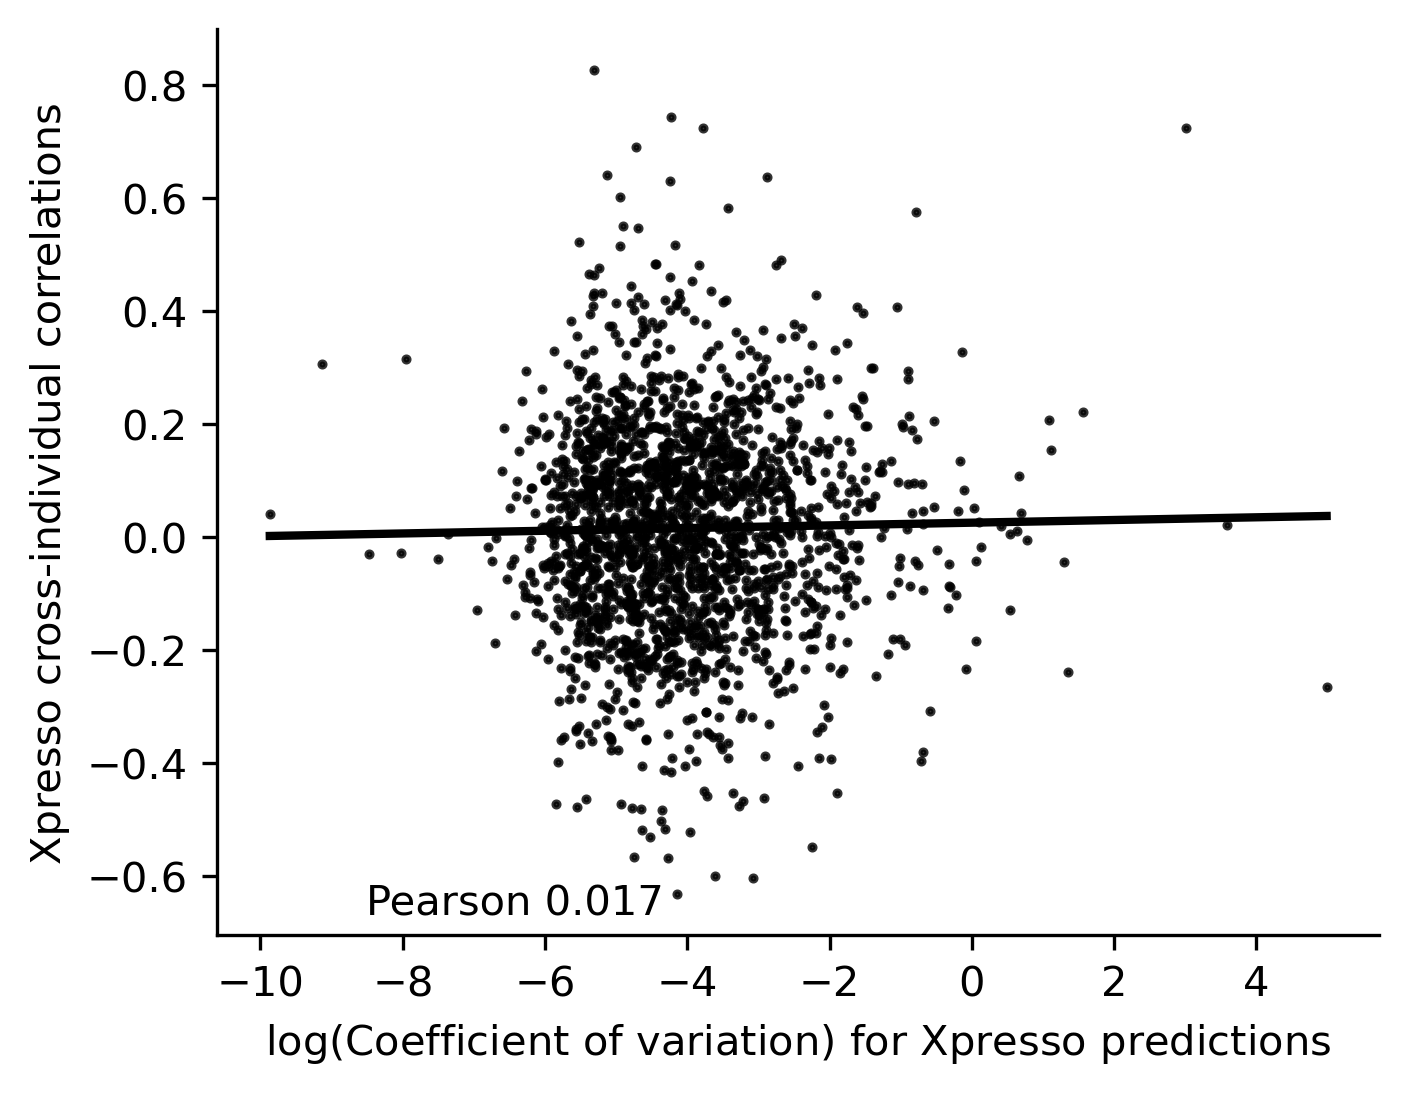

expectoCoefVar.pdf


/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log
/clusterfs/nilah/rkchung/torch36/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in log


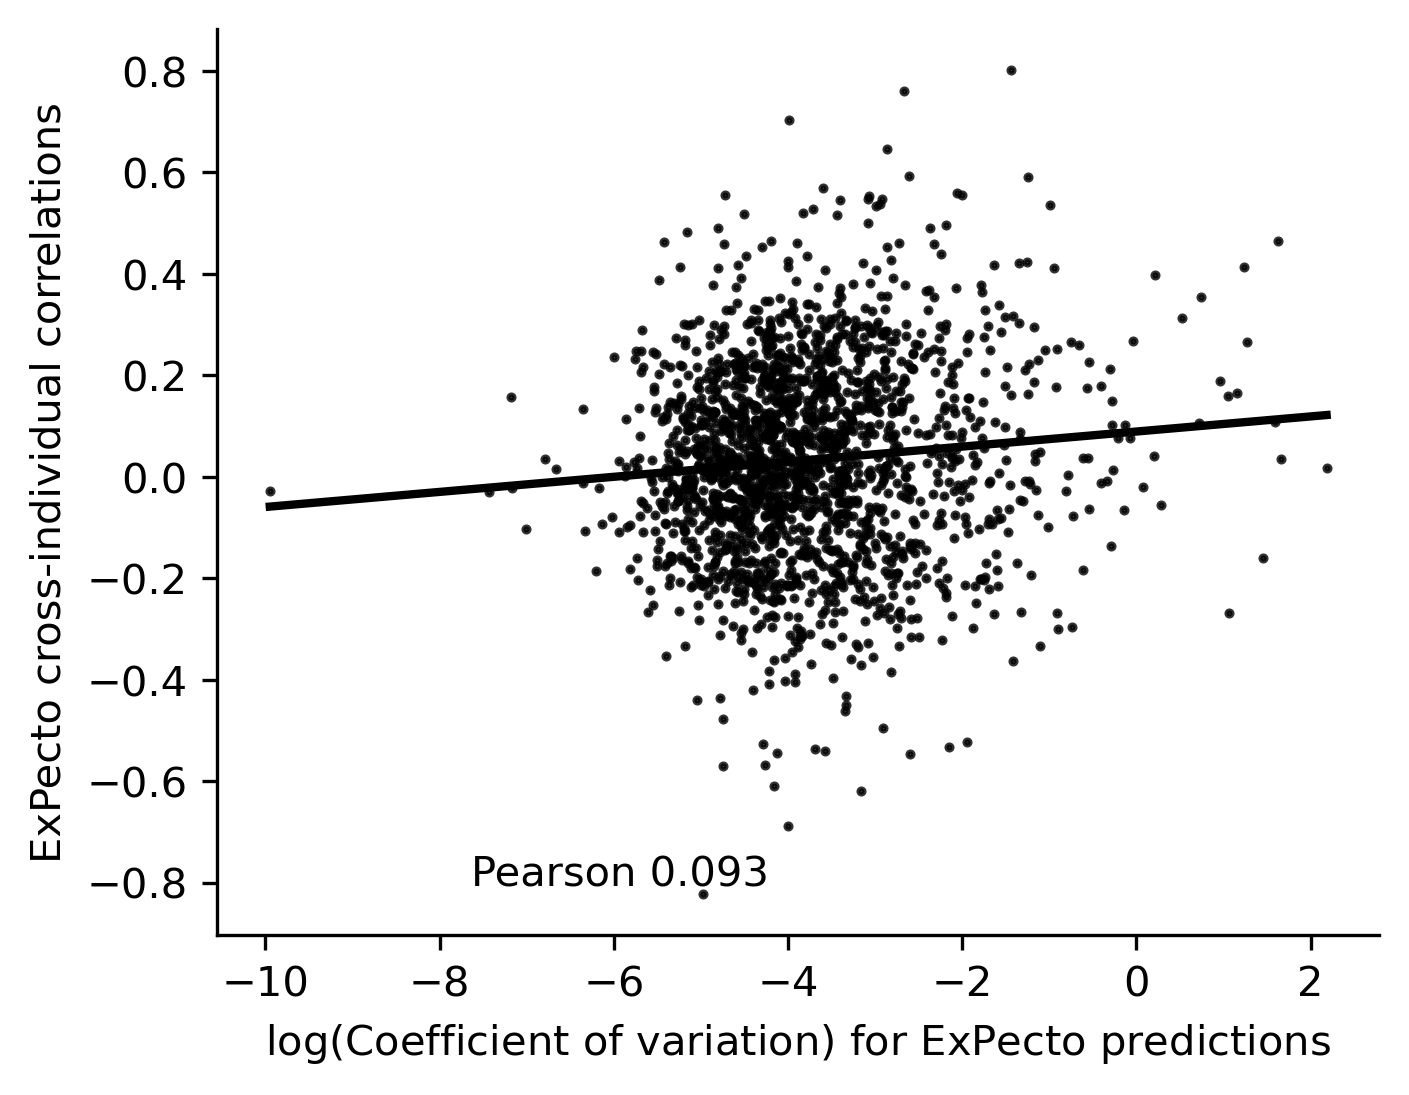

In [12]:
#models = ["AverageModel"]
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower()+"CoefVar.pdf")
    compare_to_model_coefficient_of_variation(corr_mapping[method_name], path_mapping[method_name], 
                                              xlabel=r"$\log$(Coefficient of variation) for %s predictions" % method_name,
                                              ylabel=f"{method_name} cross-individual correlations",
                                              pdf=method_name.lower()+"CoefVar.pdf")

In [21]:
#models = ["AverageModel"]
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower())
    compare_to_feat(corr_mapping[method_name], 
                               xlabel=r"pLI for %s predictions" % method_name,
                               ylabel=f"{method_name} cross-individual correlations",
                               pdf=method_name.lower()+"pli.pdf", feat="pLI")

enformer


KeyError: 'pLI'

In [37]:
def fork_plot(corrs, x, y, x_label, y_label, pdf=""):
    plt.rcParams['figure.figsize'] = [5, 4]
    merged = corrs.merge(eqtl_df, on="name")
    merged["abseffsize"] = merged["rvalue"].abs()

    
    merged["logdistance"] = np.log(merged["distance"]+1)
    
    fig, ax = plt.subplots(dpi=300)
    toplim = np.max(merged[y])+0.1
    #plt.axhspan(0, toplim, facecolor='black', alpha=0.1)
    res = dv.regplot(data=merged[merged[y]>0], x=x, y=y, ci = 0,
                     line_kws={"c":bloodorange}, scatter_kws={"s":2, "c":"black"}, ax=ax)
    nona = merged[merged[y]>0][[x, y]].dropna()
    pearsonout = scipy.stats.pearsonr(nona[x], nona[y])
    text_left = 0.01*(np.max(merged[x])-np.min(merged[x]))+np.min(merged[x])
    plt.text(text_left, np.max(merged[y]), "Pearson %.3f" %  pearsonout[0], color=bloodorange)

    res = dv.regplot(data=merged[merged[y]<0], x=x, y=y, ci = 0,
                     line_kws={"c":turquoise}, scatter_kws={"s":2, "c":"dimgrey"}, ax=ax)
    nona = merged[merged[y]<0][[x, y]].dropna()
    pearsonout = scipy.stats.pearsonr(nona[x], nona[y])
    plt.text(text_left, np.min(merged[y]), "Pearson %.3f" %  pearsonout[0], color=turquoise2)

    #plt.ylim(-toplim, toplim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    
    if pdf!="":
        plt.savefig(pdf, format="pdf")
    plt.show()

enformerEqtlPval.pdf


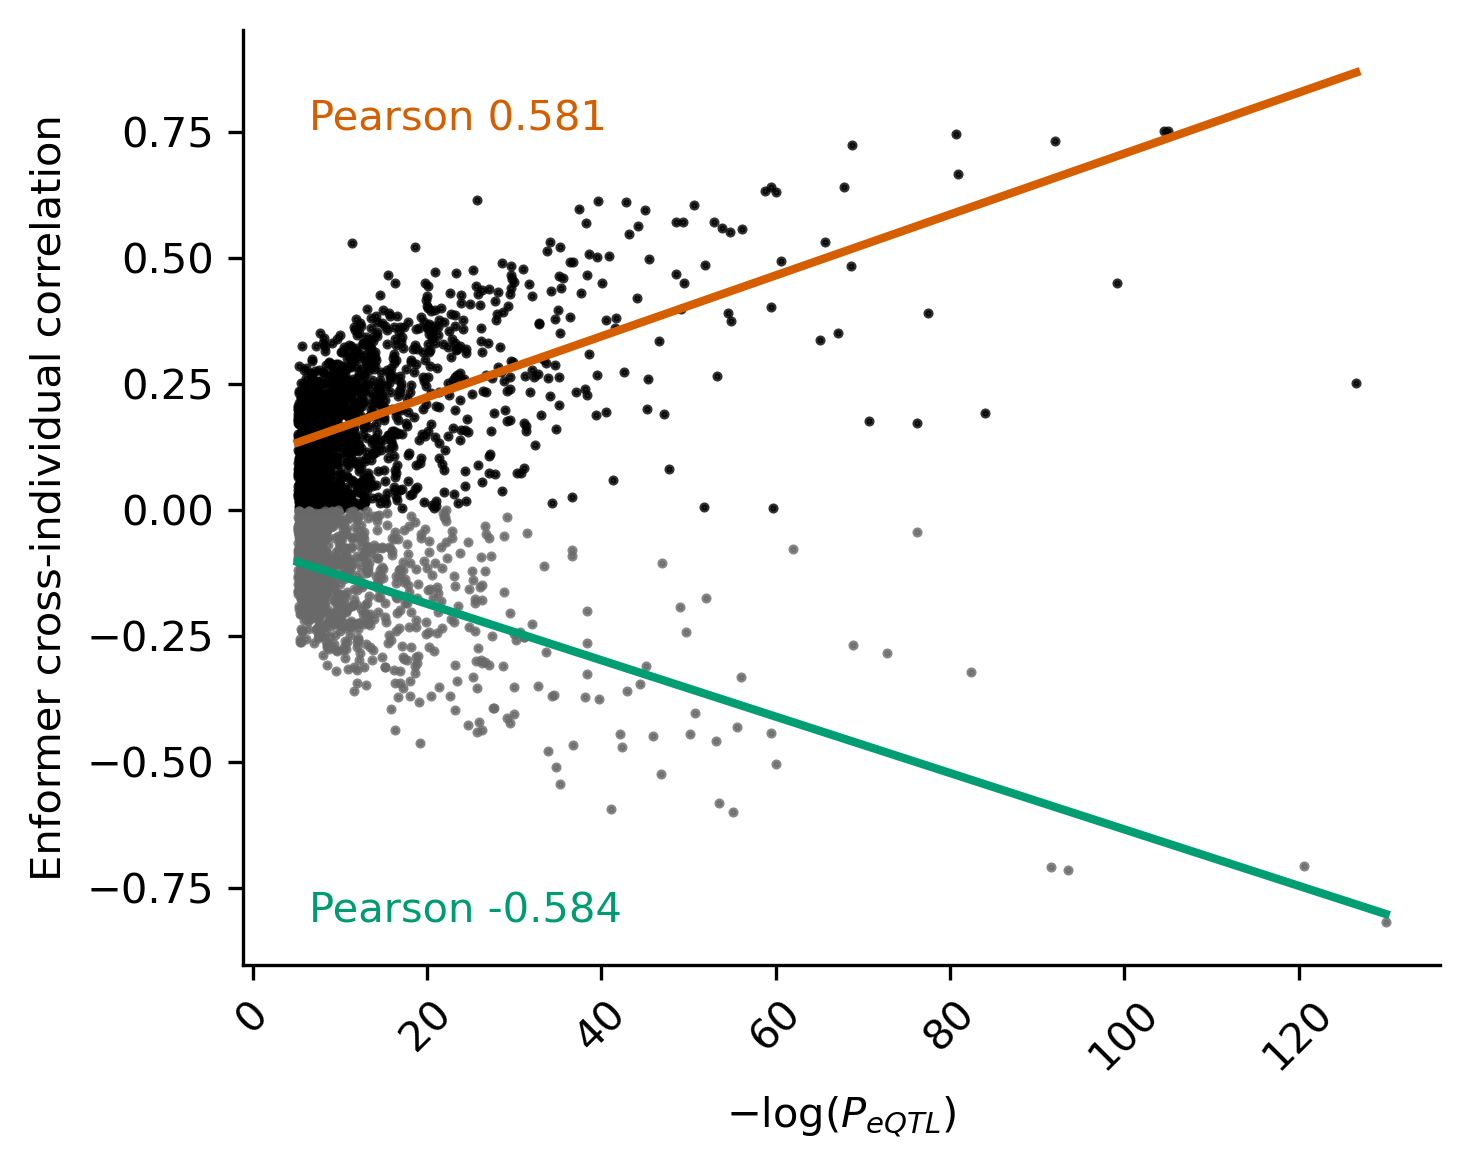

basenji2EqtlPval.pdf


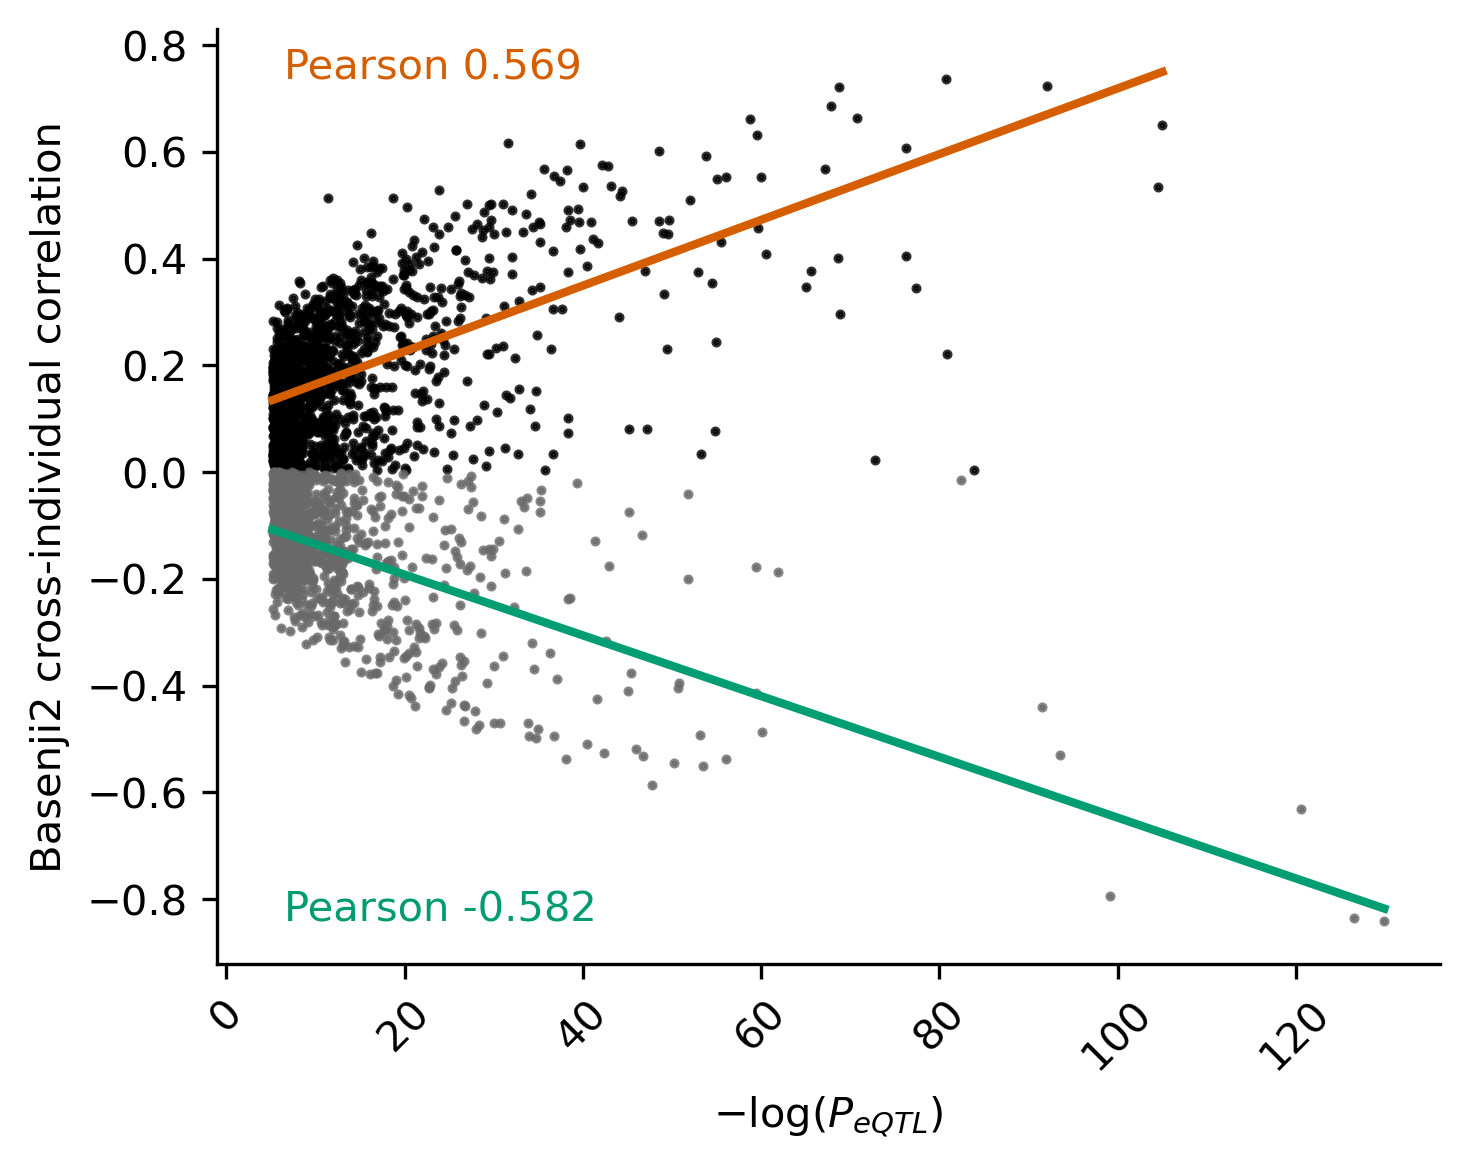

xpressoEqtlPval.pdf


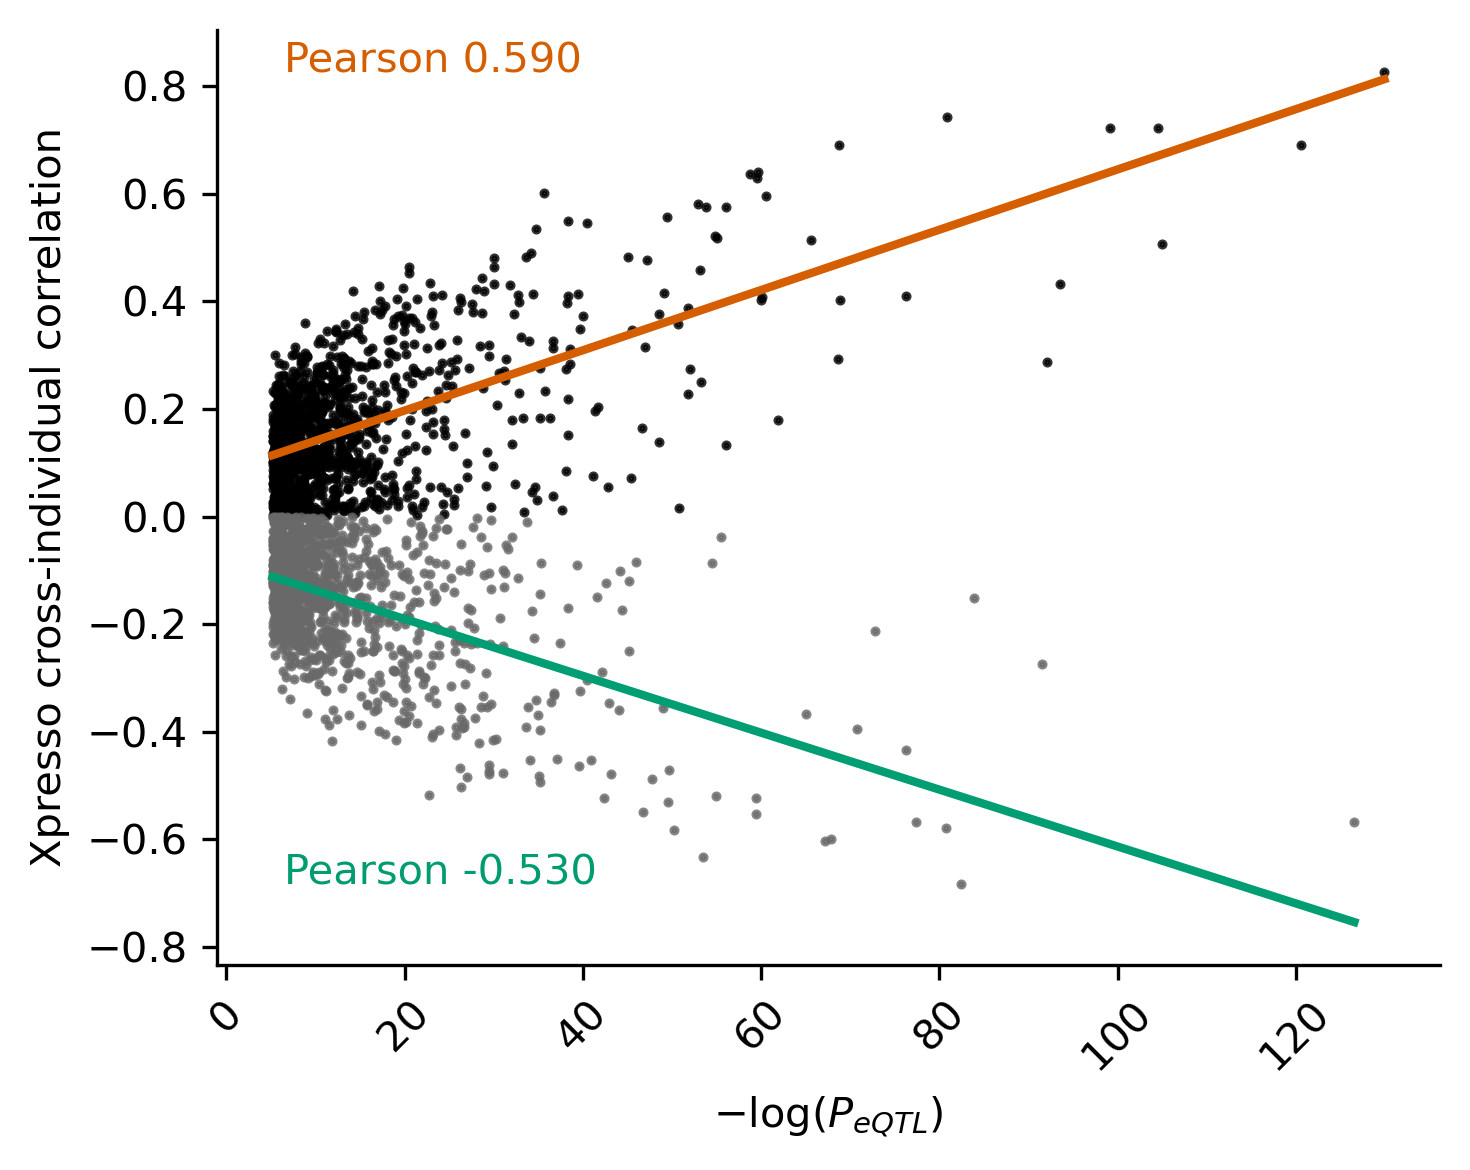

expectoEqtlPval.pdf


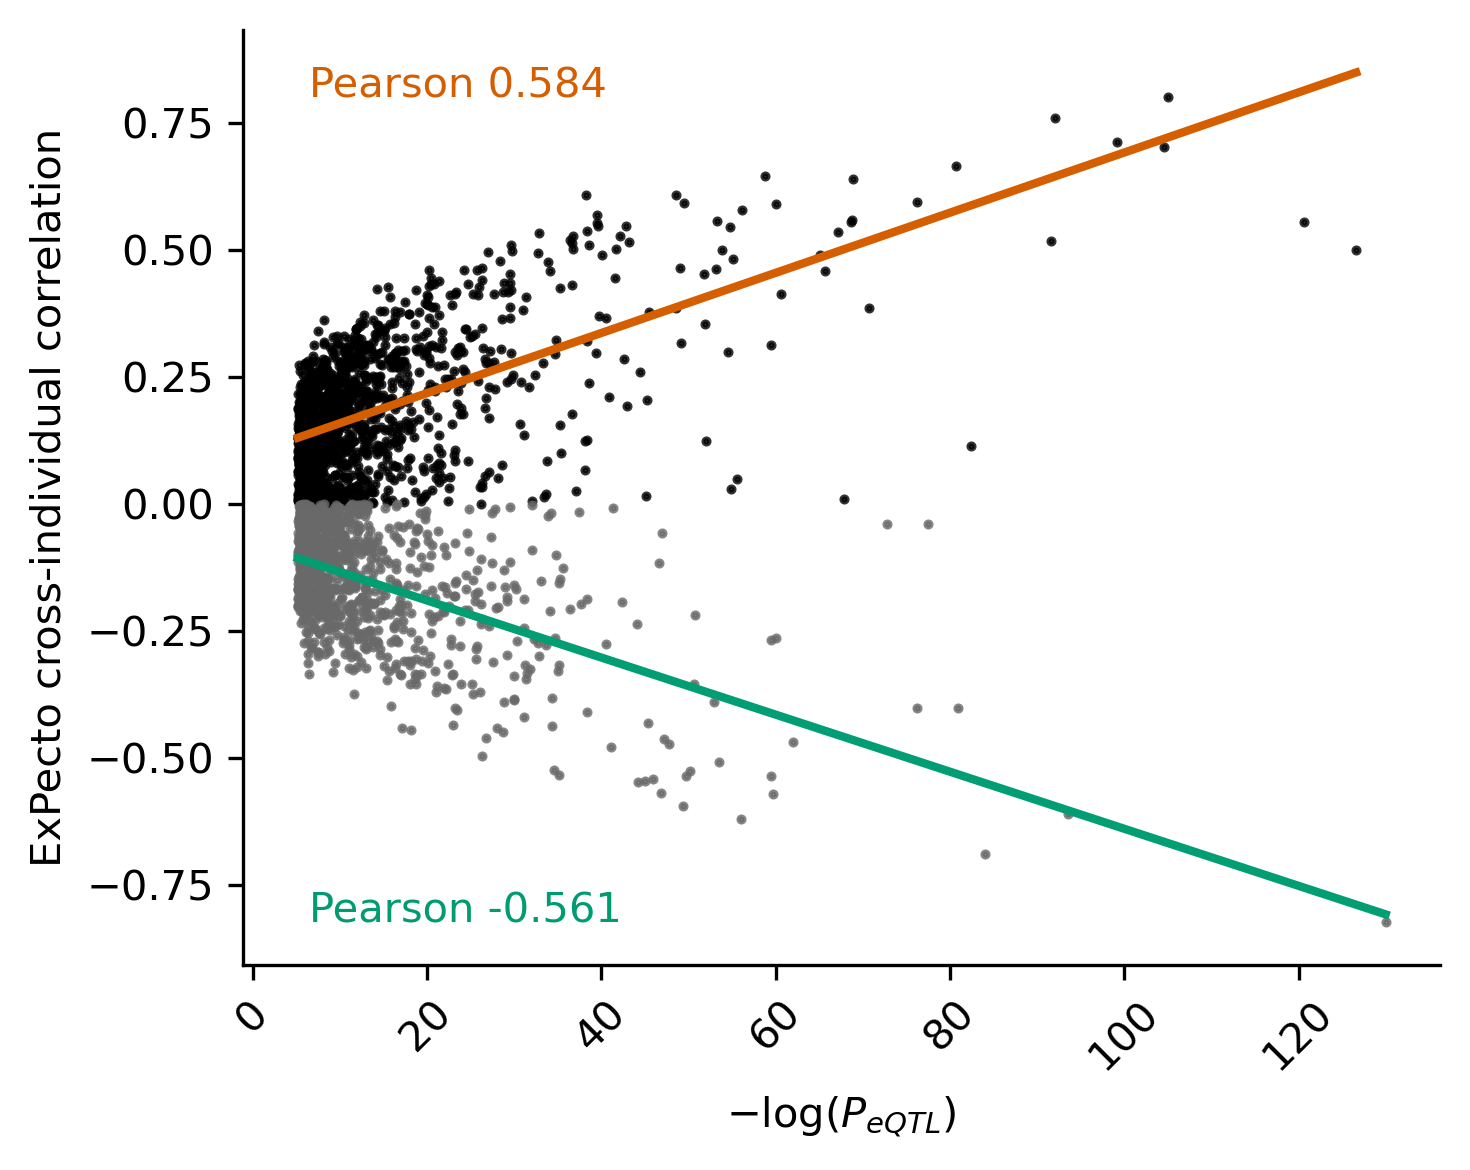

In [45]:
y = "spearman"
x = "log10pvalue"

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower()+"EqtlPval.pdf")
    
    fork_plot(corr_mapping[method_name], x, y, r'$-\log(P_{eQTL})$', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlPval.pdf")

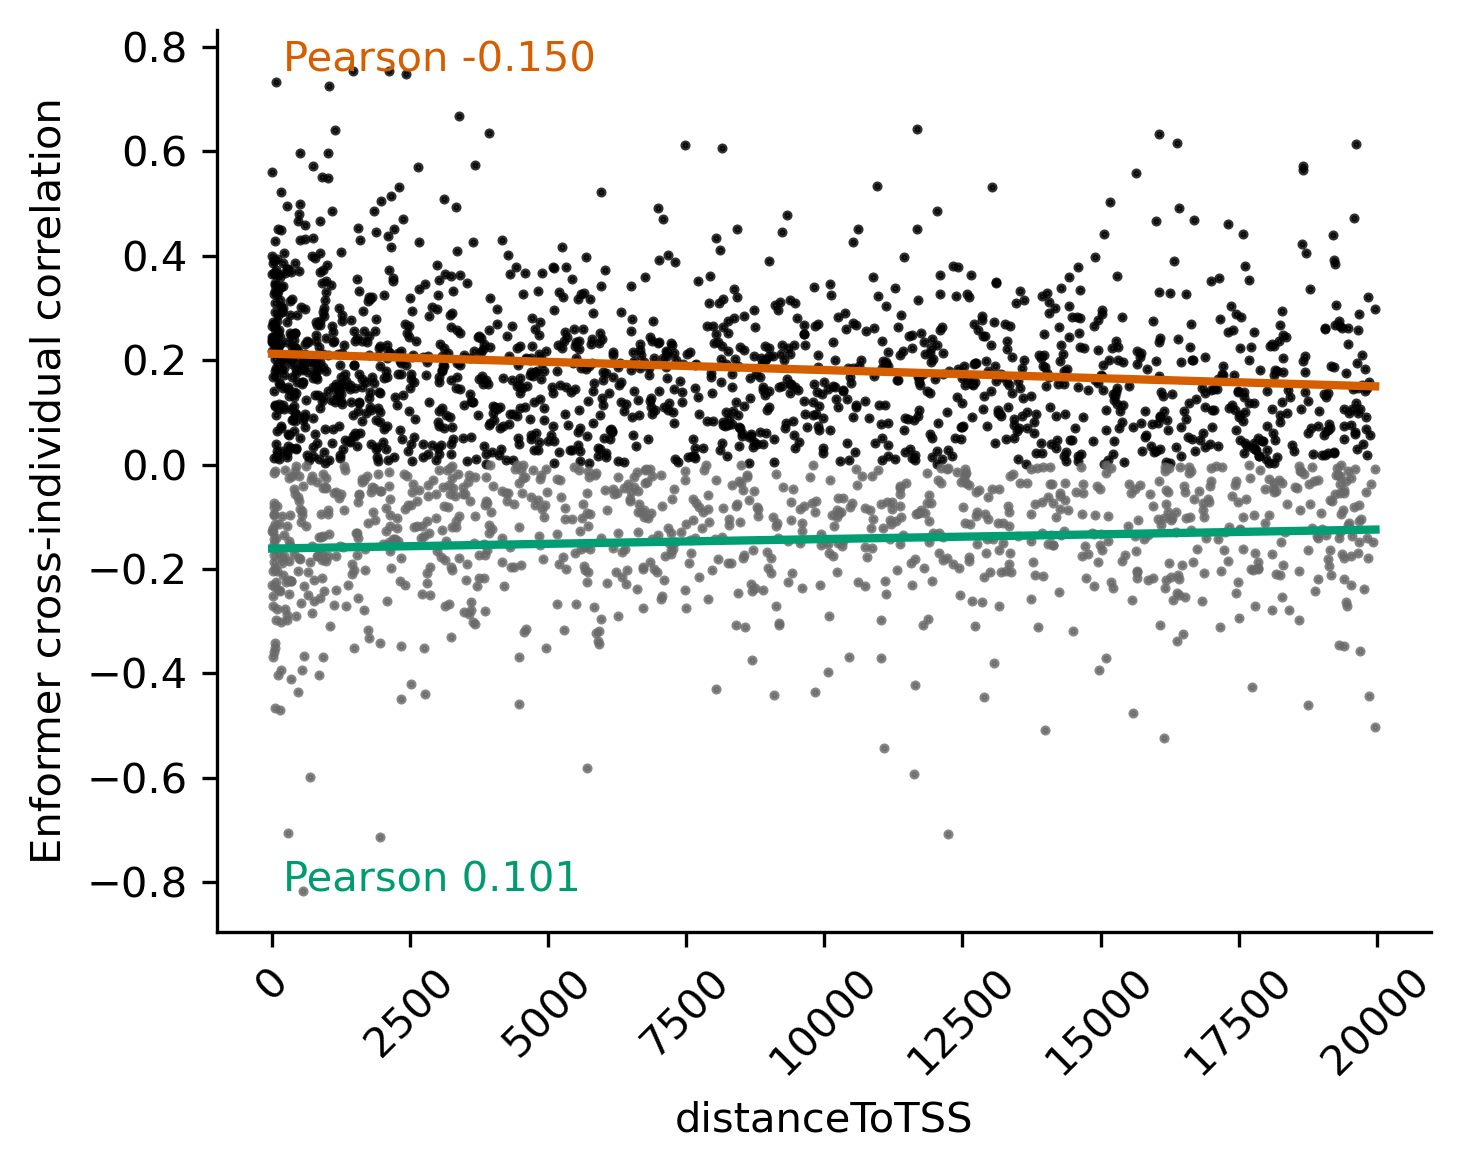

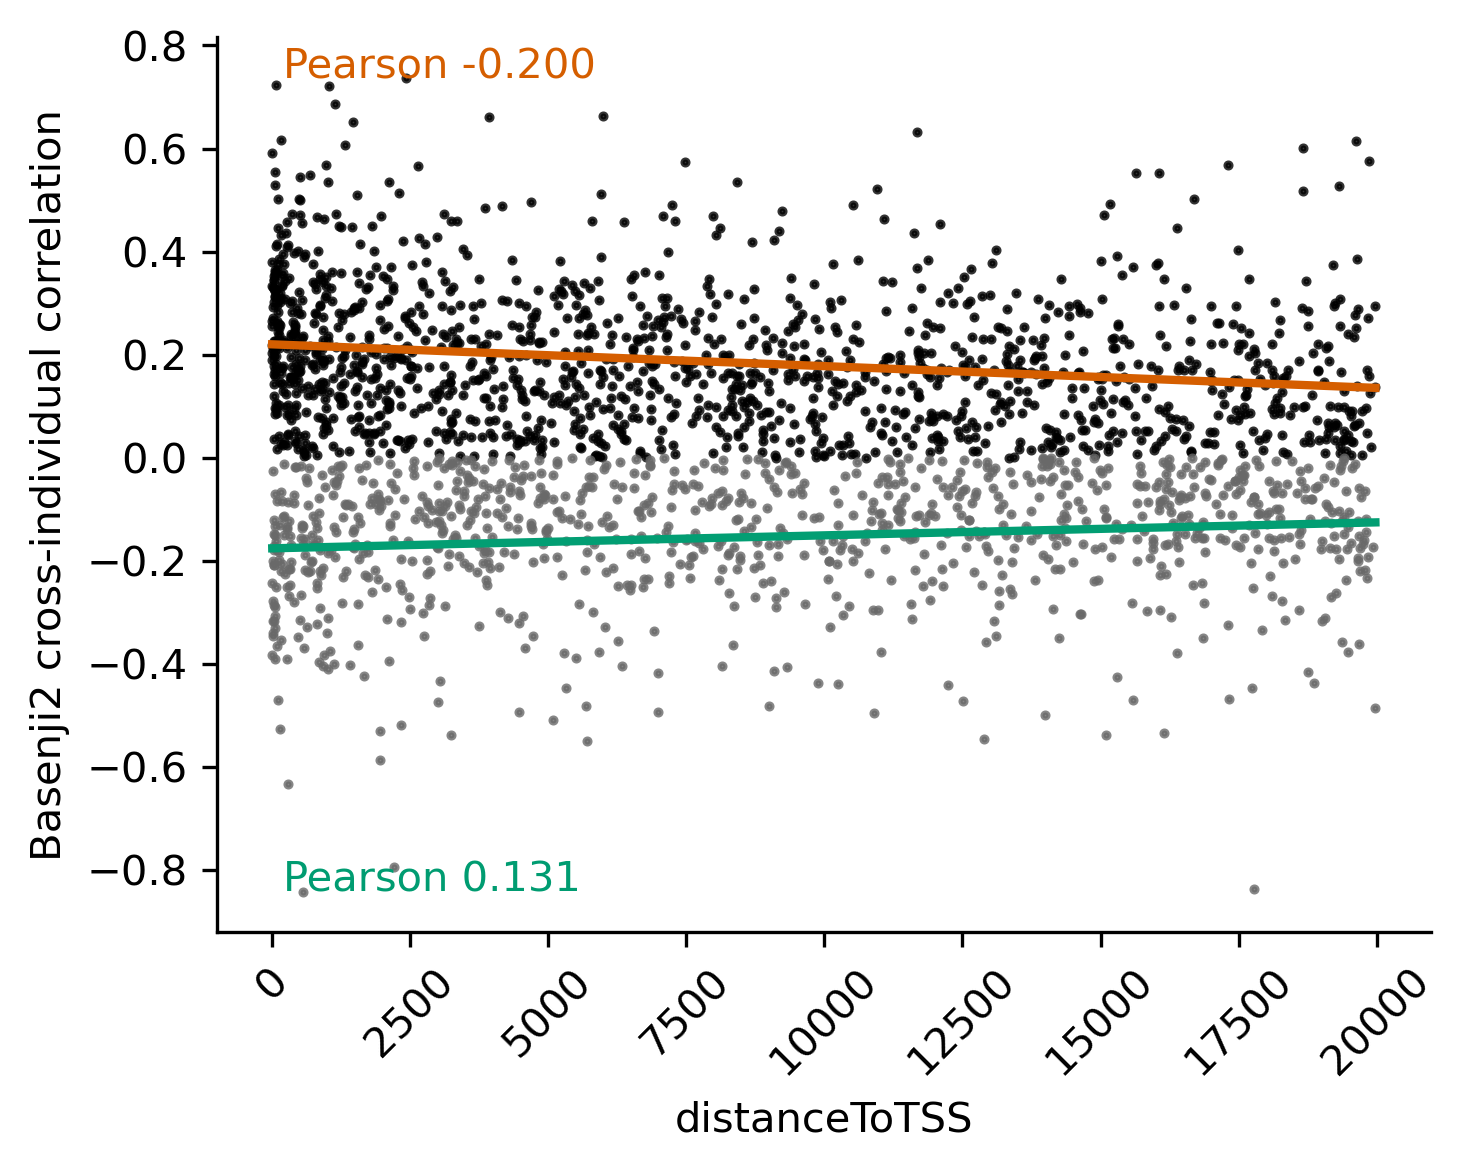

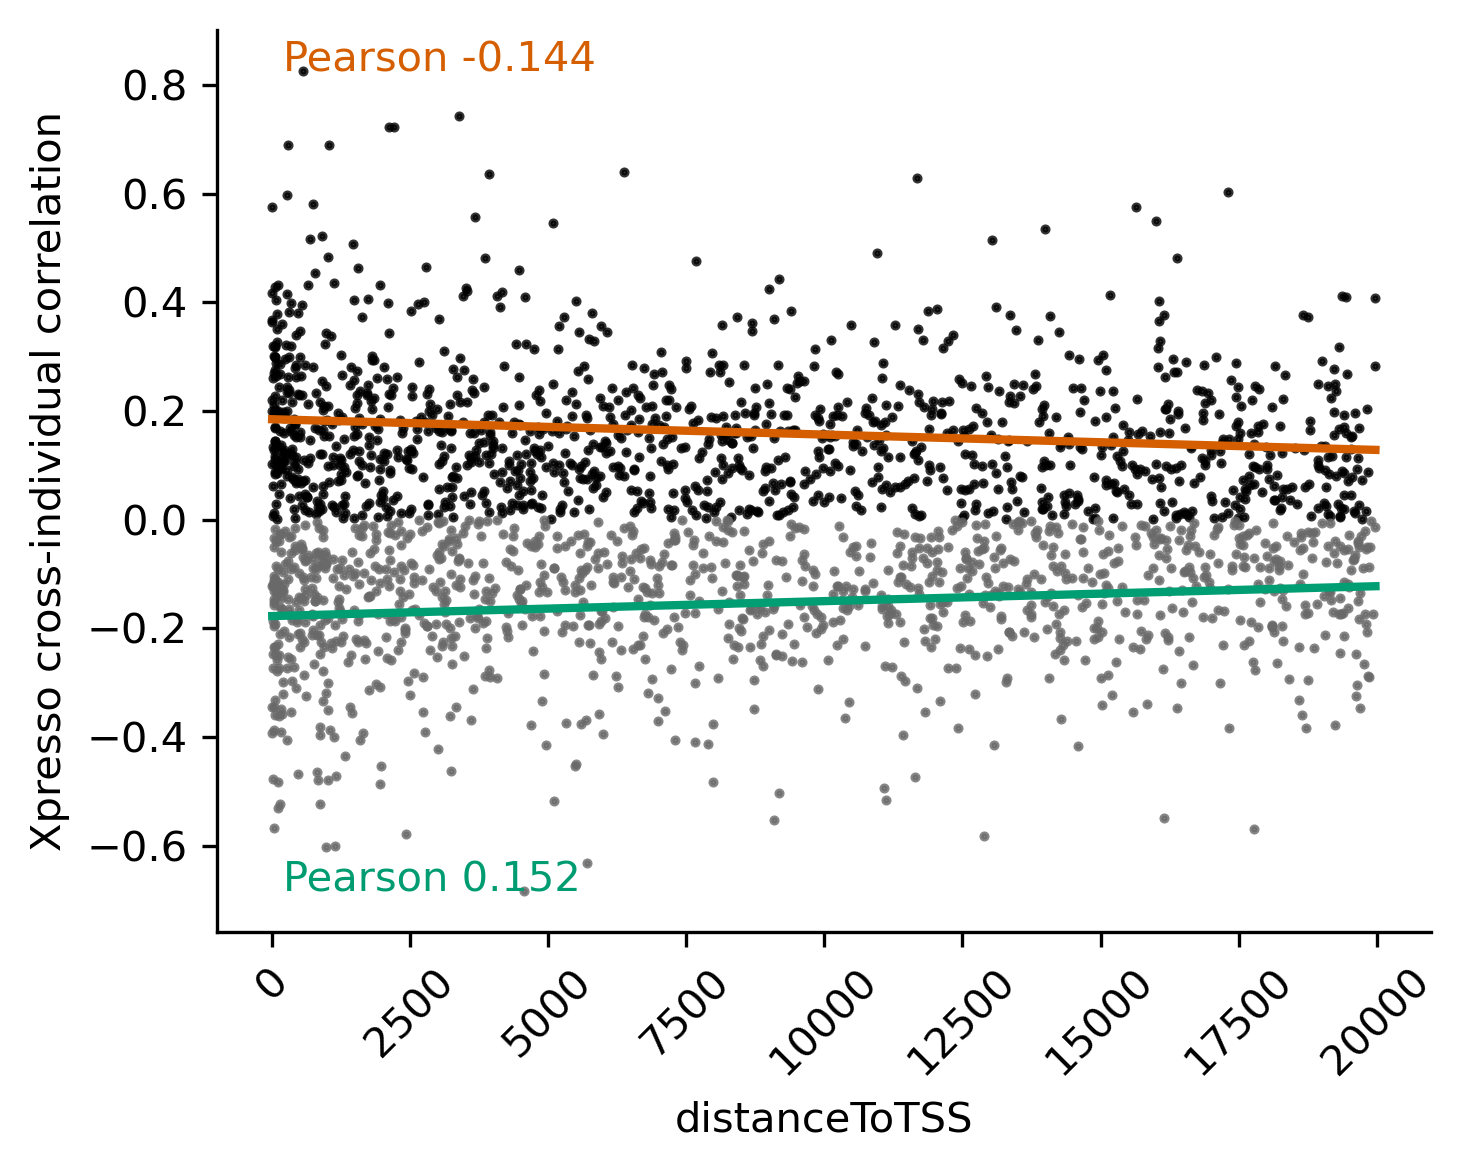

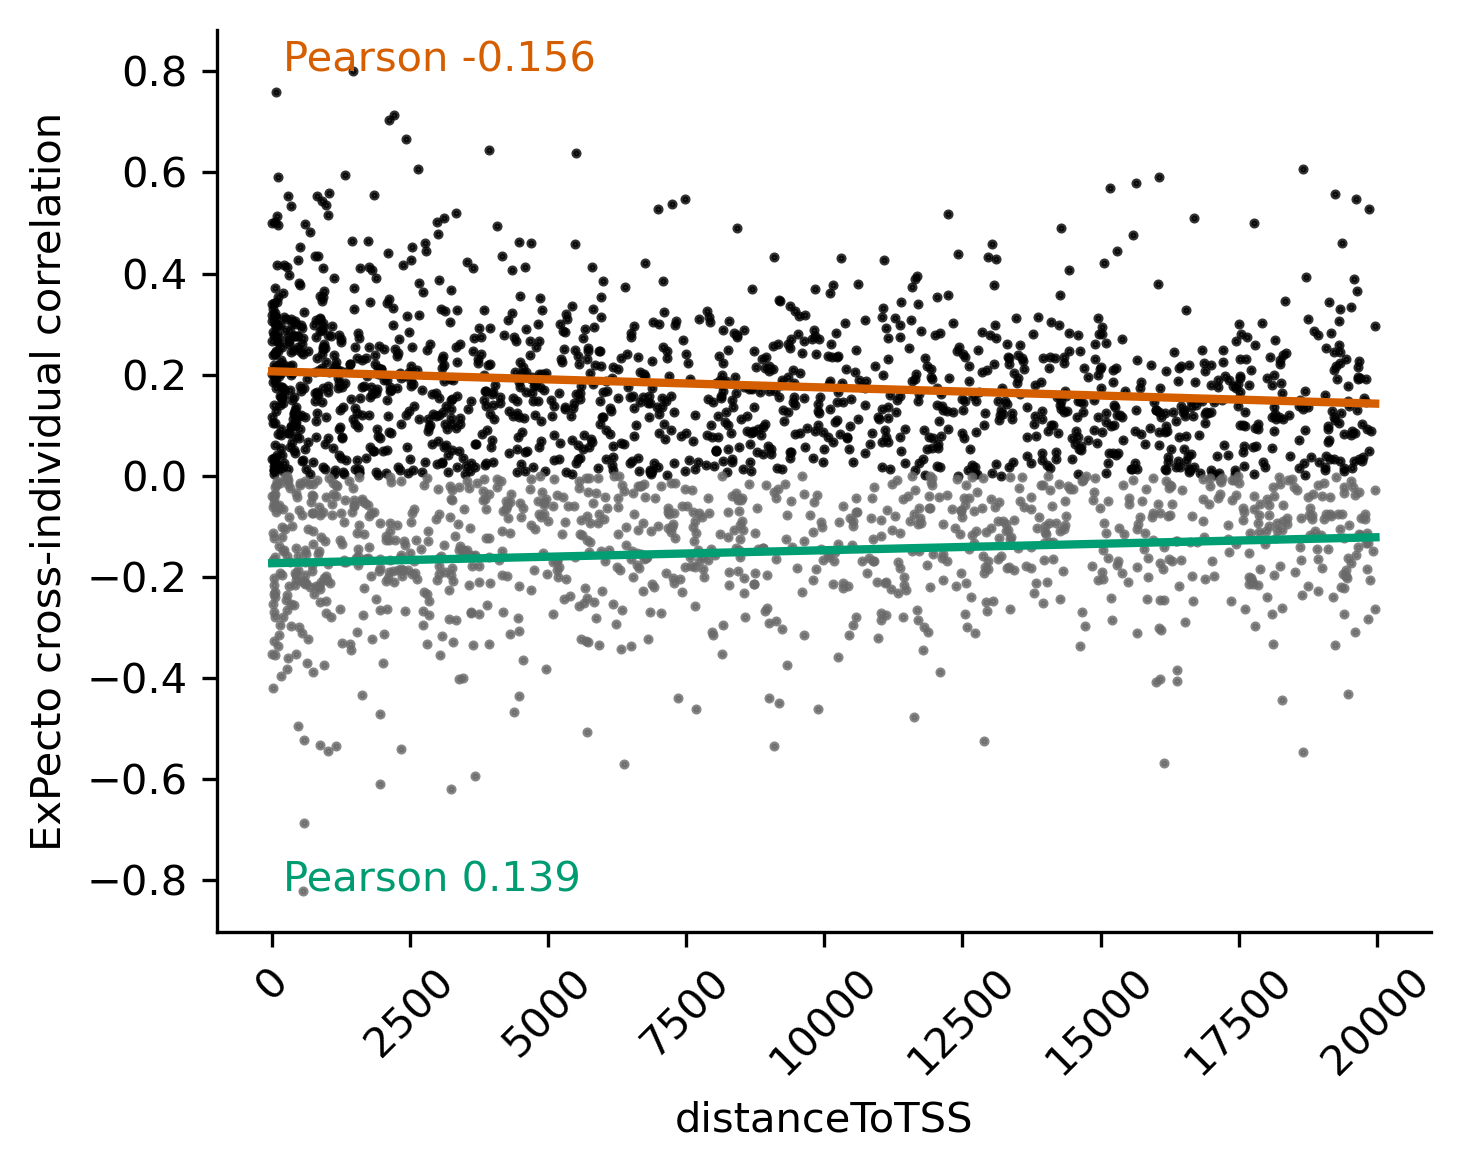

In [46]:
y = "spearman"
x = "distance"

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    fork_plot(corr_mapping[method_name], x, y, r'distanceToTSS', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlDistance.pdf")

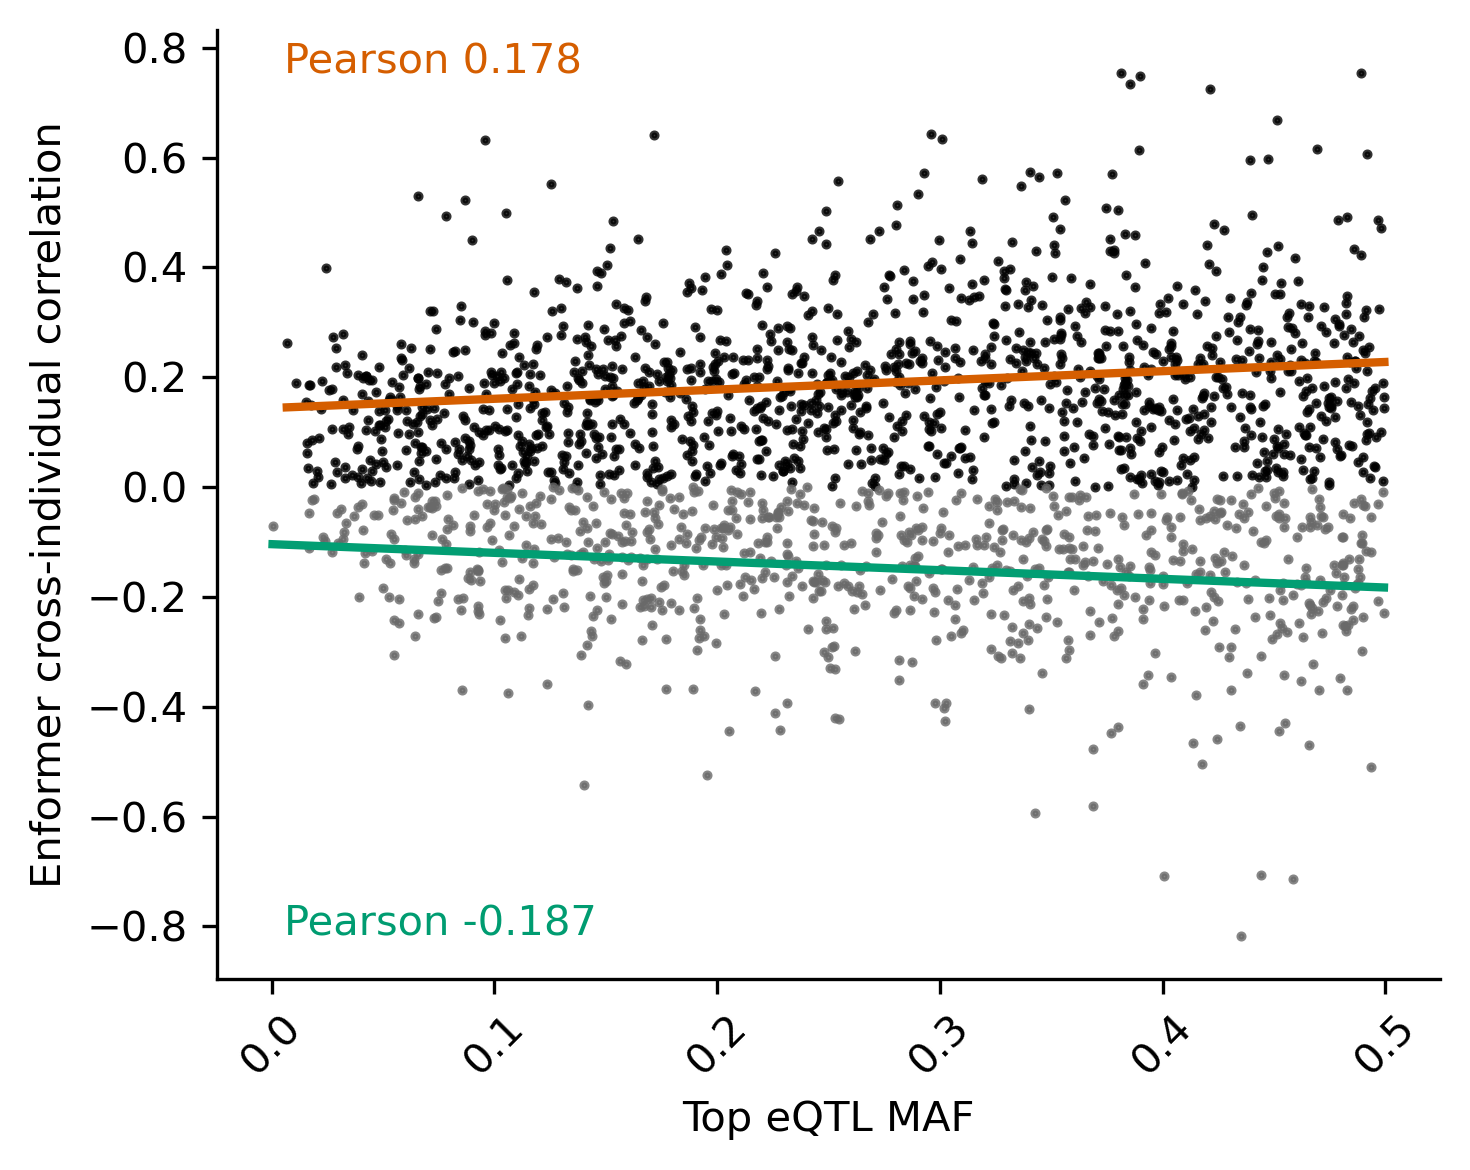

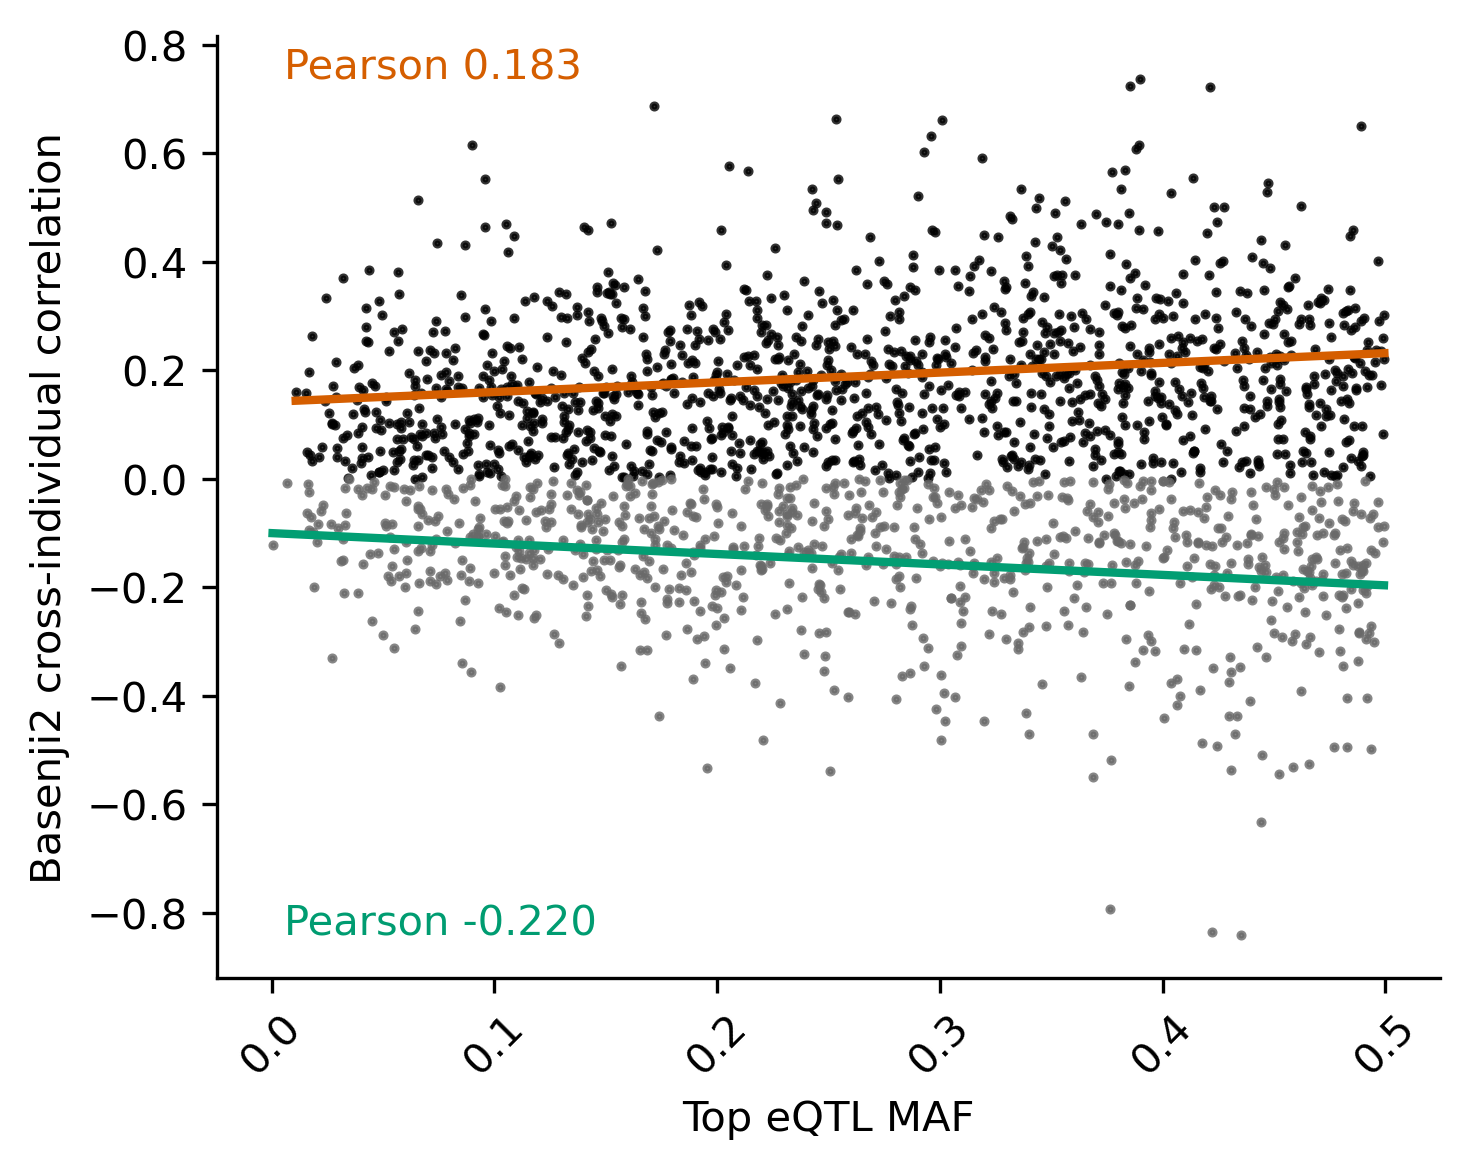

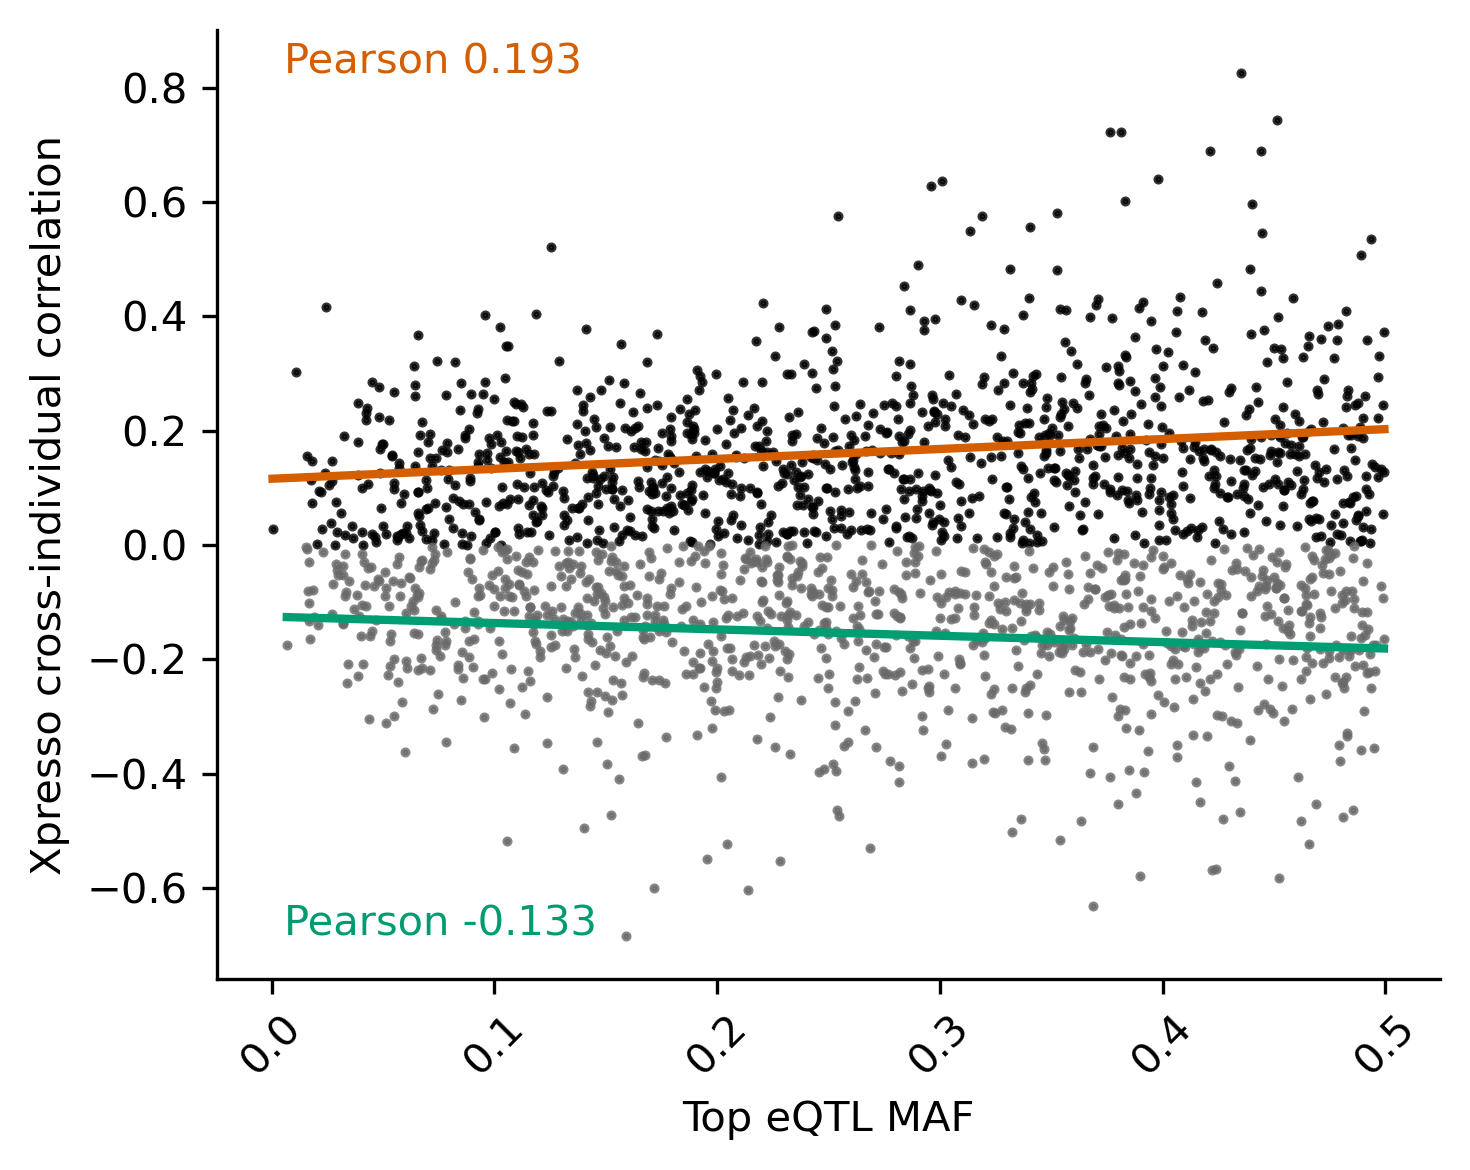

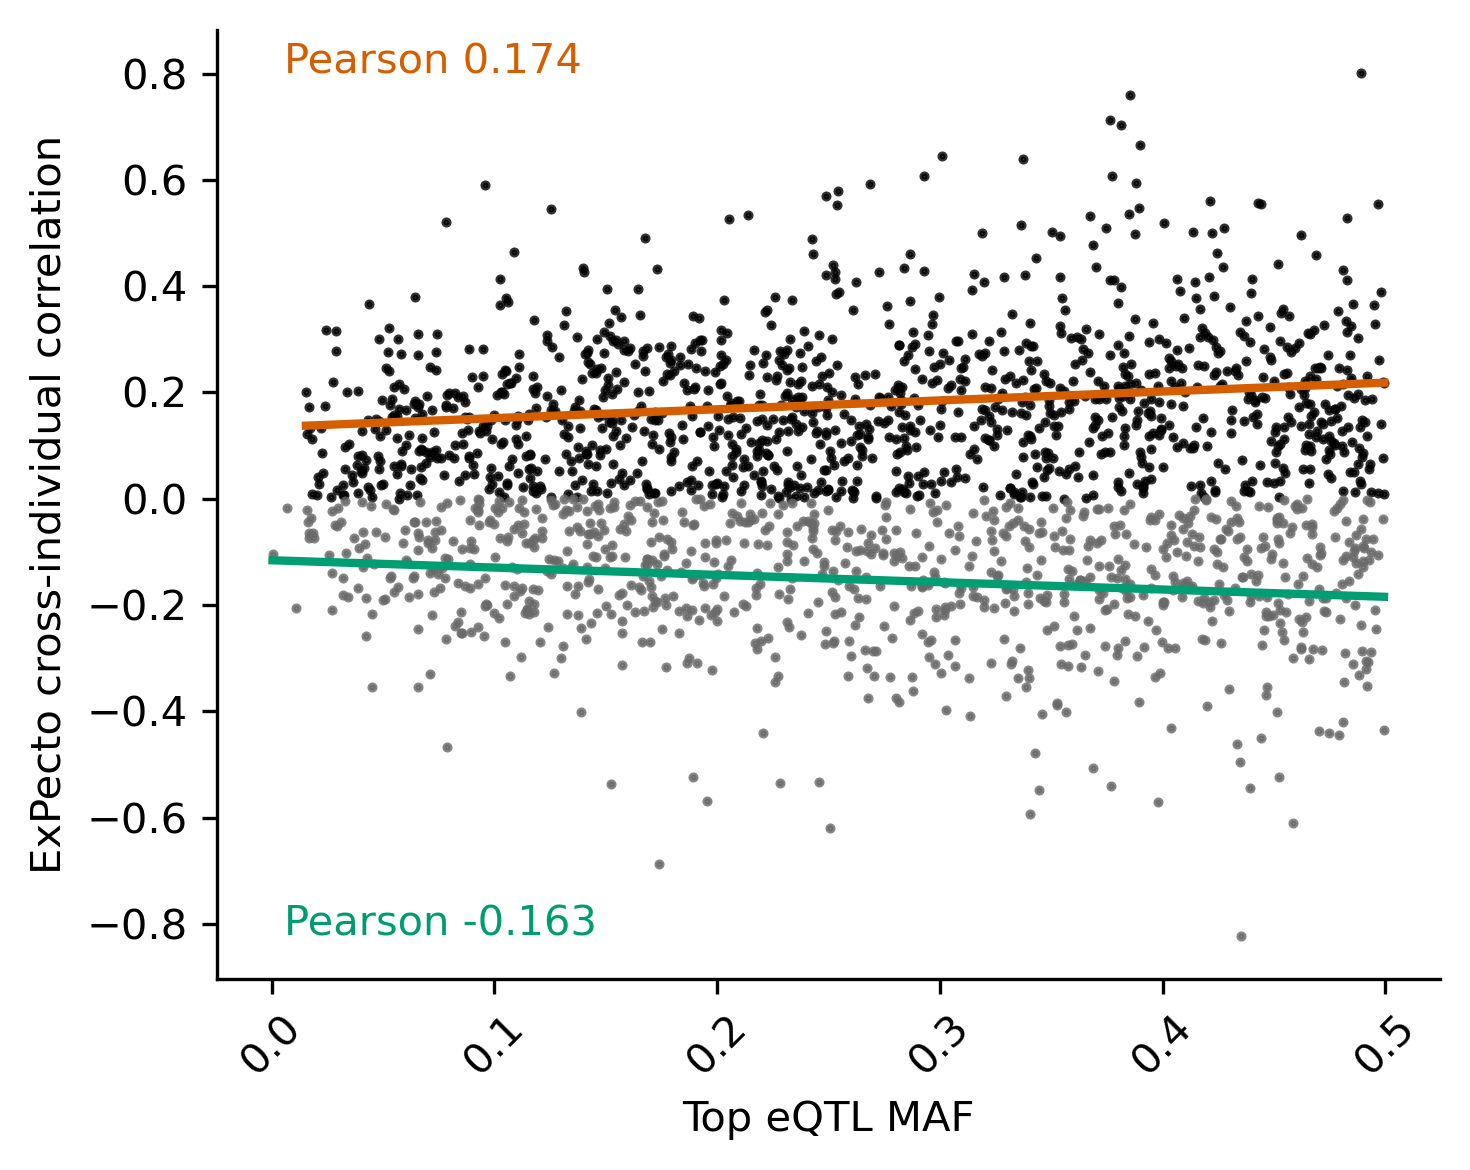

In [47]:
y = "spearman"
x = "minor_allele_freq"

models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    fork_plot(corr_mapping[method_name], x, y, 'Top eQTL MAF', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlAF.pdf")

enformerEqtlEffsize.pdf


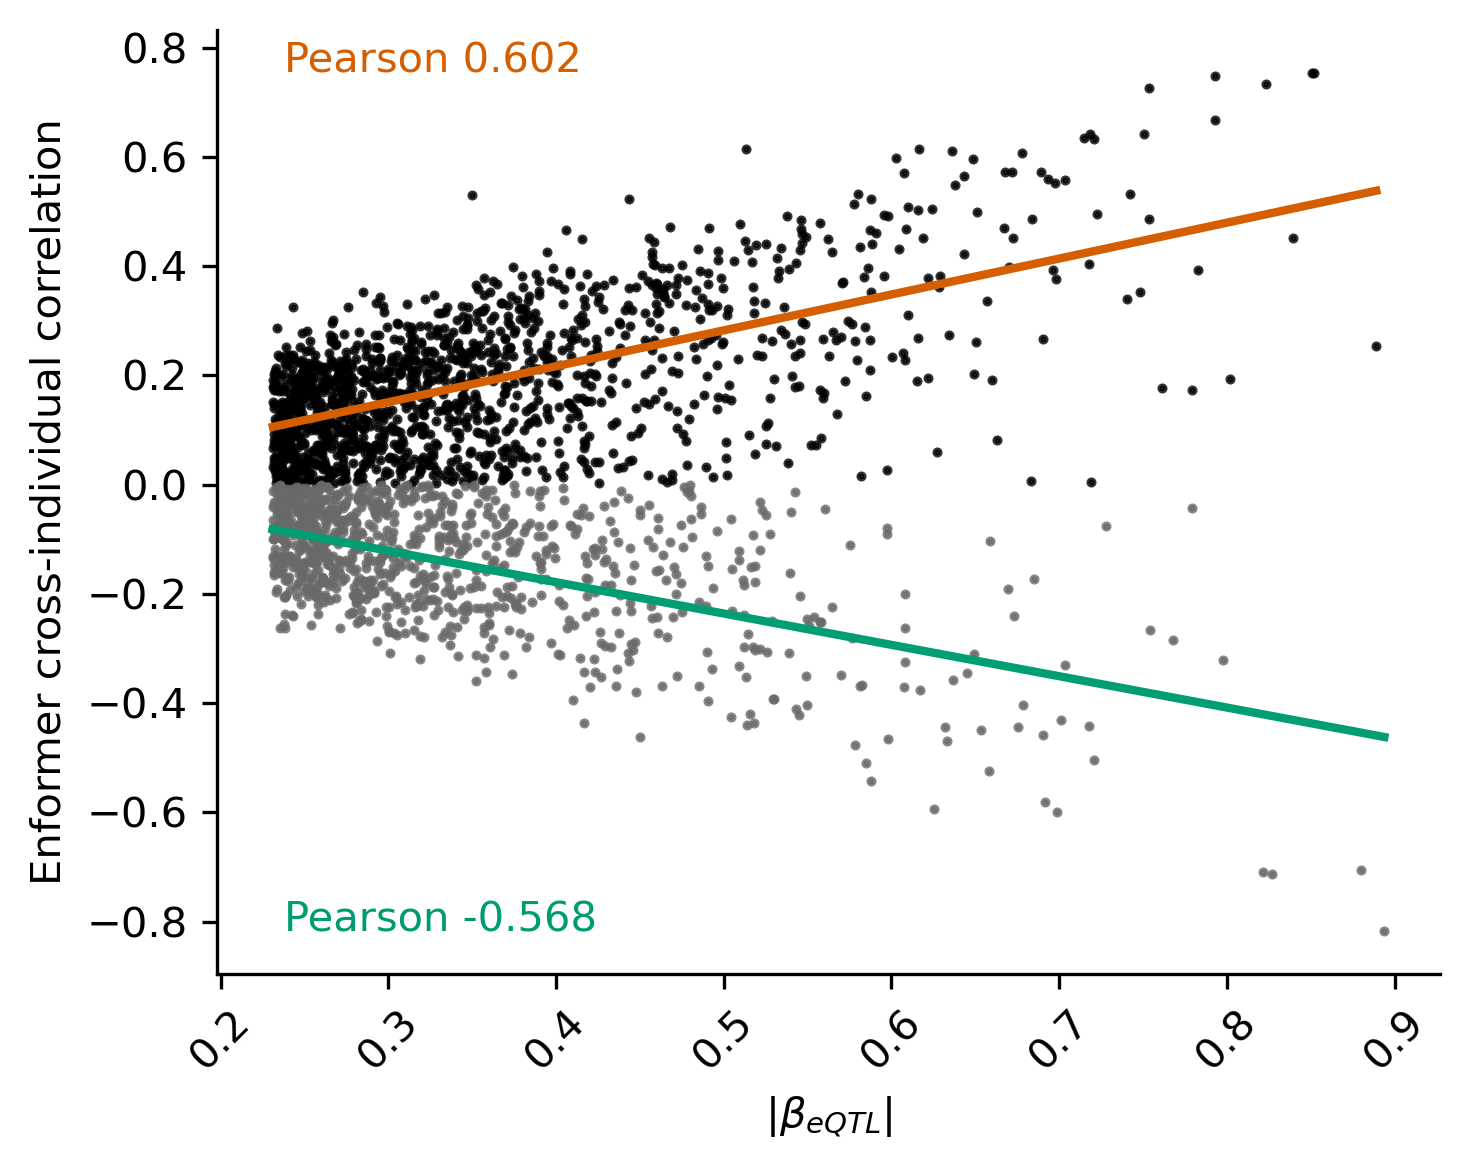

basenji2EqtlEffsize.pdf


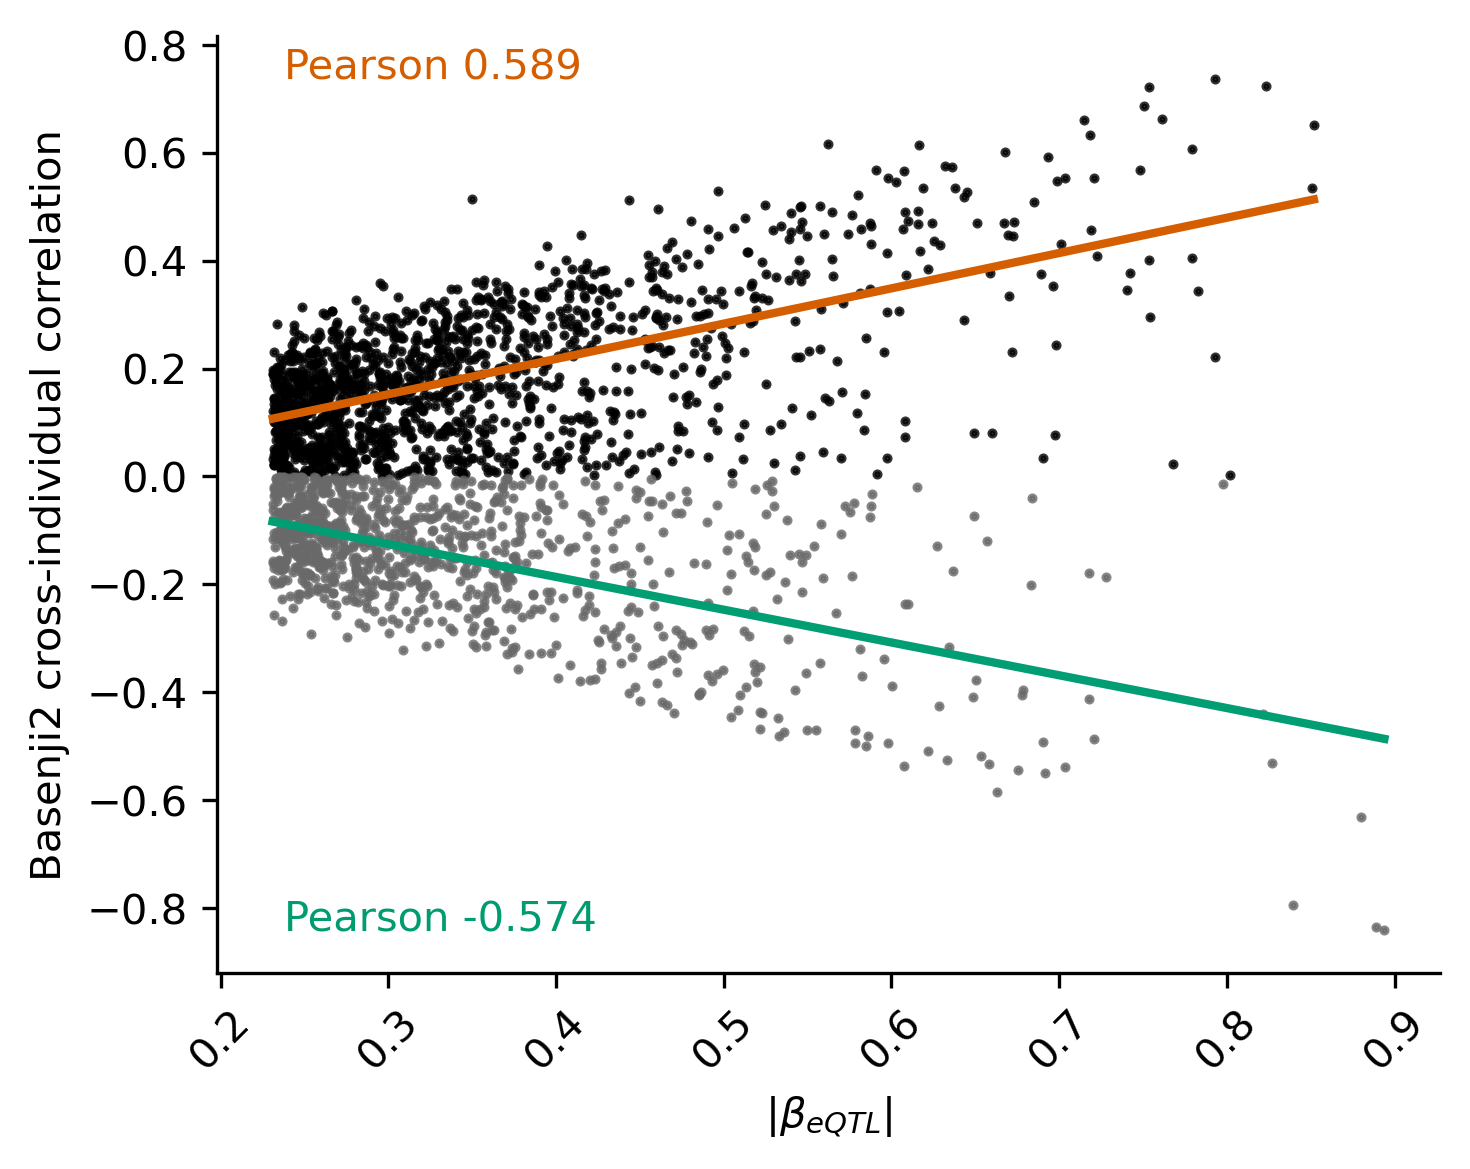

xpressoEqtlEffsize.pdf


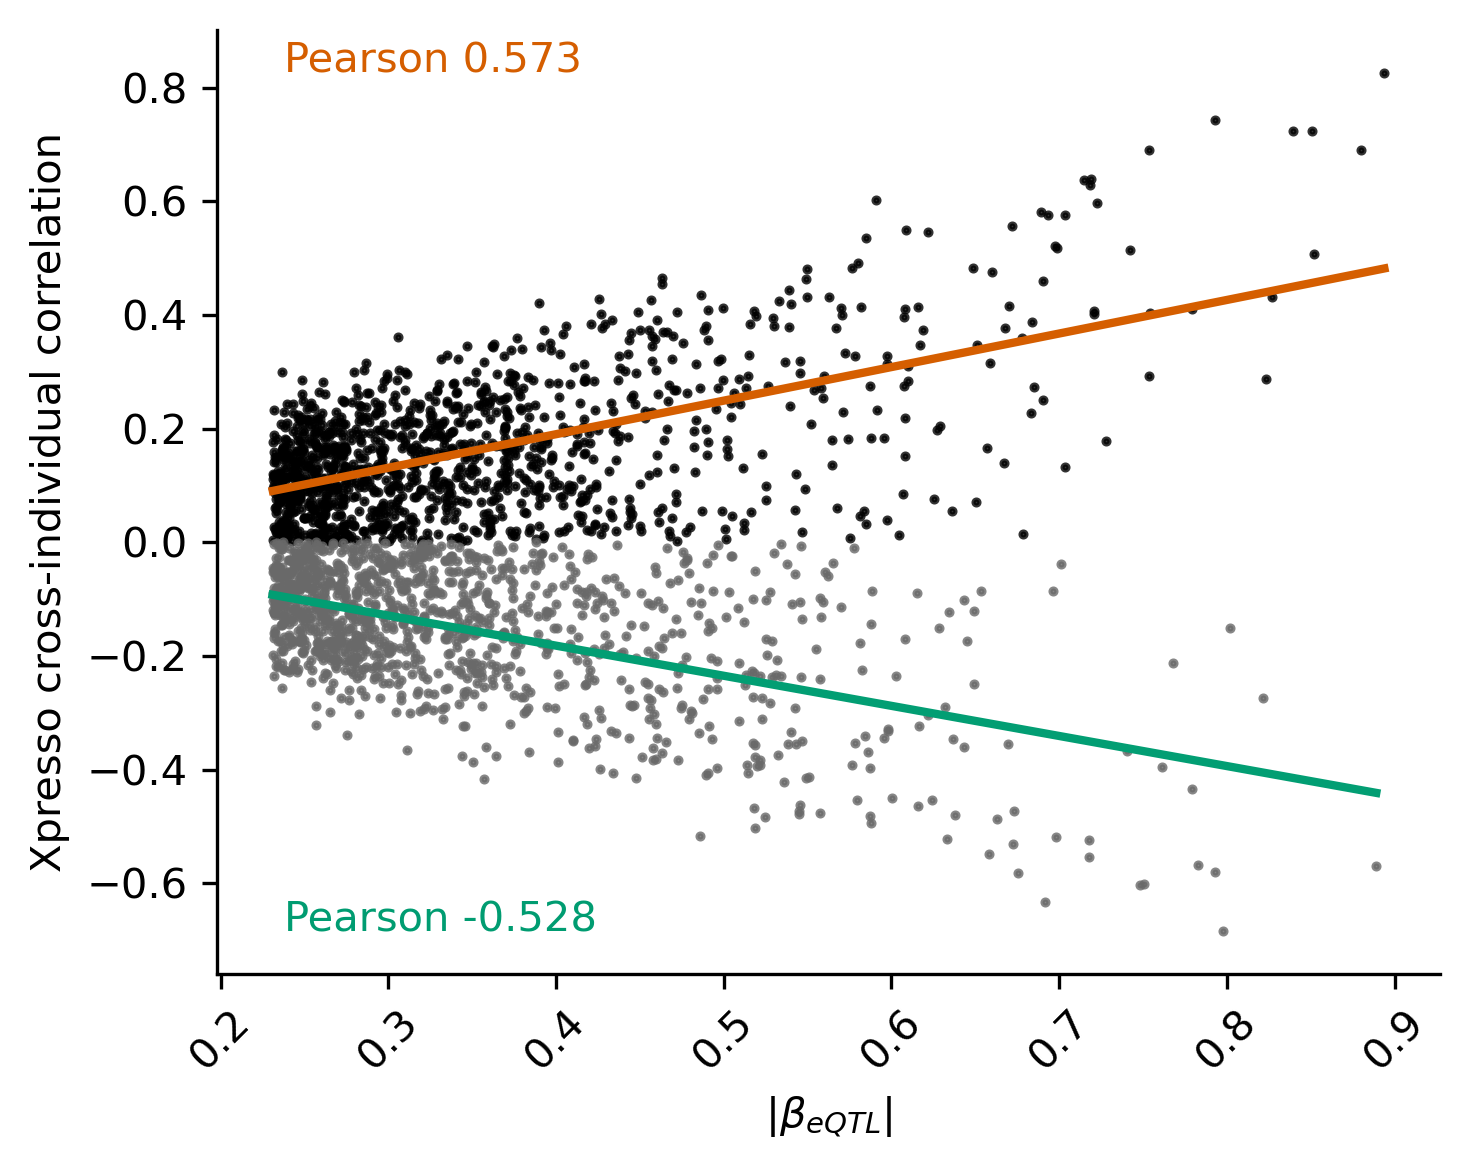

expectoEqtlEffsize.pdf


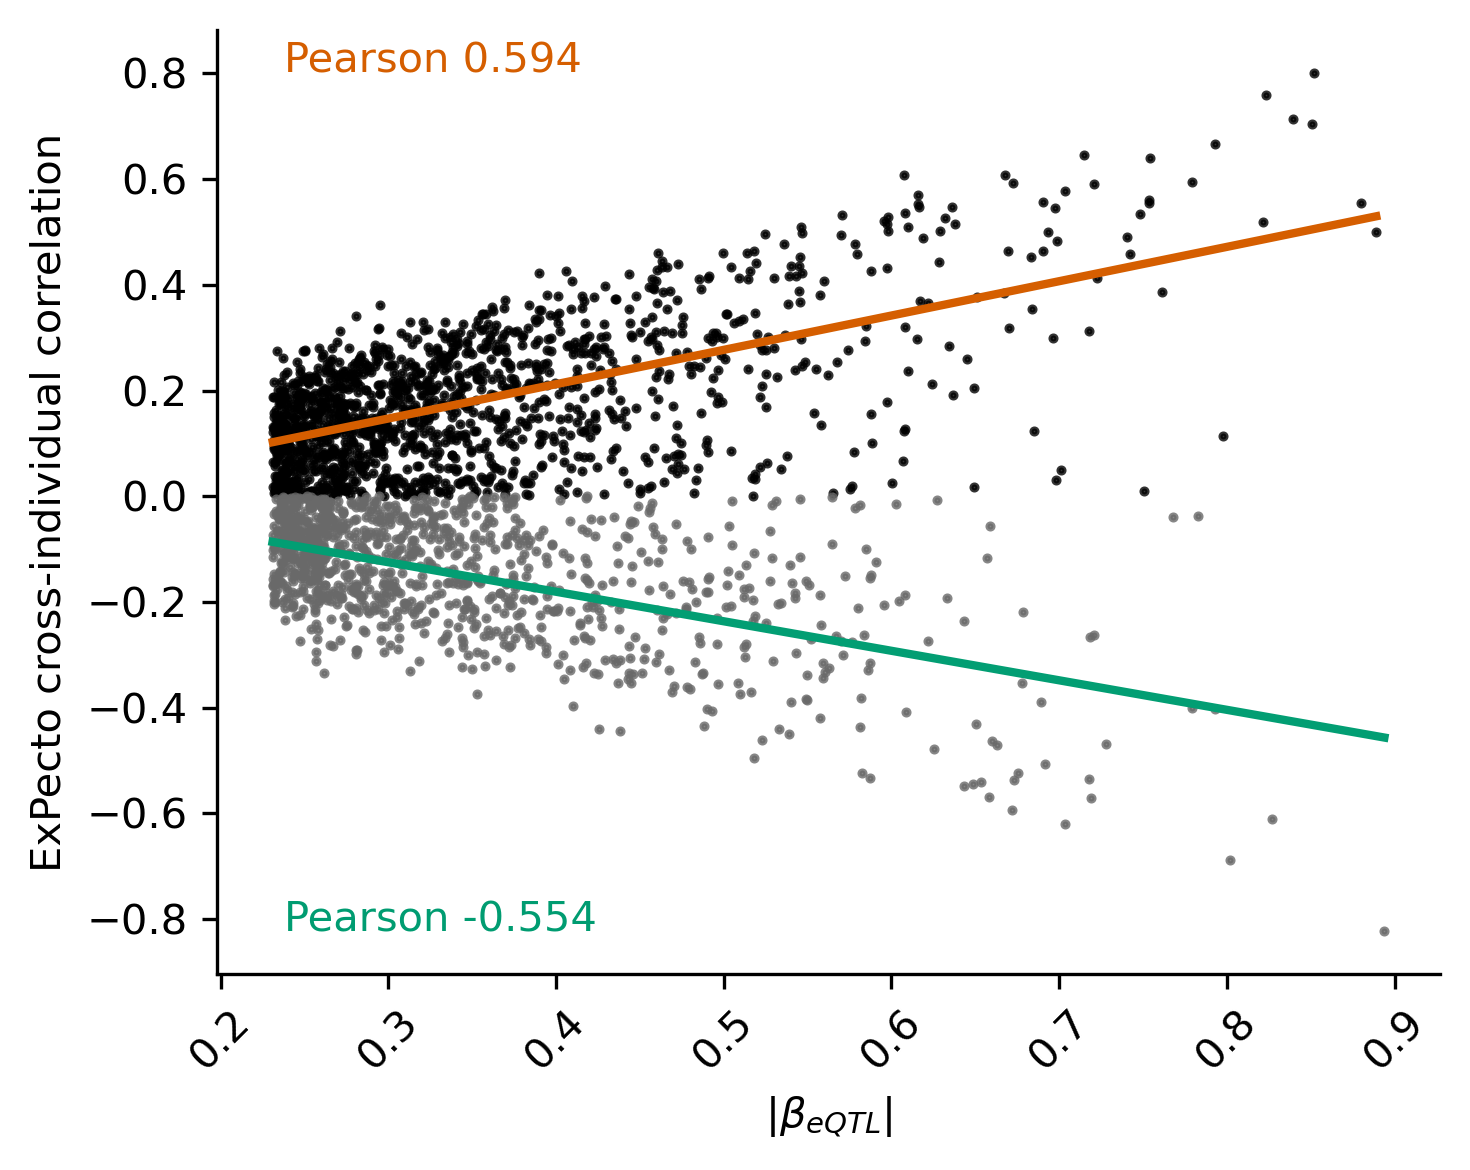

In [48]:
y = "spearman"
x = "abseffsize"
models = ["Enformer", "Basenji2", "Xpresso", "ExPecto"]

for method_name in models:
    print(method_name.lower()+"EqtlEffsize.pdf")

    fork_plot(corr_mapping[method_name], x, y, r'$|\beta_{eQTL}$|', 
              f"{method_name} cross-individual correlation", 
              pdf=method_name.lower()+"EqtlEffsize.pdf")